## Goal:  Explore kickstarter projects and to determine what parameters influence whether the project is a success or failure

Dataset details: Kickstarter is the world's largest funding platform for creative projects. A home for film, music, art, theater, games, comics, design, photography, and more.

Kickstarter works on an all or nothing basis i.e if a project doesn’t meet it goal, the project owner gets no money at all. For example: if a projects’s goal is USD 500. Even if it gets to 499 by the deadline, the project is deemed a failure.


[Read about / download dataset](https://www.kaggle.com/codename007/funding-successful-projects-old)

Variable Description 

project_id unique id of project name name of the project

desc description of project

goal the goal (amount) required for the project

keywords keywords which describe project

disable communication whether the project authors has disabled communication option with people donating to the project

country country of project

author currency currency in which goal (amount) is required

deadline till this date the goal must be achieved (in unix timeformat)
state_changed_at at this time the project status changed. Status could be successful, failed, suspended, cancelled etc. (in unix timeformat) created_at at this time the project was posted on the website(in unix timeformat) launched_at at this time the project went live on the website(in unix timeformat) 

backers_count no. of people who backed the project 

final_status whether the project got successfully funded (target variable – 1,0)


First I explore the dataset to explore all the features and then form hypotheses that will help be determine what influences a successful kickstarter campaign.

# 1. Data exploration

##### Loading necessary packages...

In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
%matplotlib inline

#For converting different currencies to USD
from forex_python.converter import CurrencyRates

#Counting the number of occurences of words
from sklearn.feature_extraction.text import CountVectorizer

#lexicon and rule-based sentiment analysis tool 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Preprocessing
from sklearn import preprocessing

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

##### Loading the dataset...

In [2]:
train = pd.read_csv("data/kickstarter/train.csv", header=0)

train.columns


Index(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at', 'backers_count',
       'final_status'],
      dtype='object')

## Preliminary exploration of features available in the dataset

##### The data structure contains the following features:

1. **Project ID** : A unique identification number for each row. 

2. **Name**: A first look to a potential backer as to what the project is about. An eye-catching name could increase the traffic to the page and increase backing.

3. **Description**: The details. *I am curious as to whether the sentiment of the name and description could affect the outcome, more positive projects could attract more backers. The name many not be descriptive enough to pick up the sentiment but the description should.
4. **Goal**: I would think this is very important. Smaller goals are easier to reach.

5. **Keywords**: Important to bring traffic to the page, I would like to analyze keywords to see if there is a difference between keywords used in successful and failed projects.

6. **Disable communication**: Disabling communication should negatively impact the campaign.

7. **Country**: People usually back projects in their countries especially when it's a physical product -- shipping can be expensive!

8. **Currency** should be highly related to country, except for common currencies like euro

9-12. **Deadline**/ 
    **State changed at**/
    **Created at**/ 
    **Launched at**/ These four parameters will help compare different times for successful and failed projects (e.g.: time it takes to launch a project from time of creation)
    
13: **Backers count**: Very important! More backers, more money?

*and*

Label: **Final Status** tells us whether the project is is successfully funded or not.


## 1. The goals are in in the local currency, I convert  to USD for easy comparison.  

**Note: Many other factors come into play such as purchasing power, model of kickstarter in the country etc. but I ignore them for this analysis; I also use current currency rates**

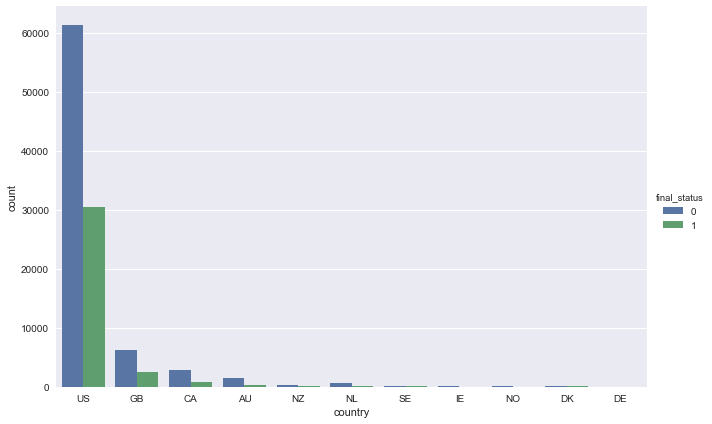

In [53]:
# g = sns.factorplot(x="currency", data=train, hue='final_status', kind="count", size=6, aspect=1.5)
g = sns.factorplot(x="country", data=train, hue='final_status', kind="count", size=6, aspect=1.5)

In [7]:
US_projects=train[train['country']=='US'].size*100/train.size
Non_US_projects=100-US_projects
print ('US projects make up',US_projects, '% of the total projects' )

US projects make up 85.1140767047 % of the total projects


In [8]:
train['country']=='US'

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
108099    False
108100    False
108101     True
108102     True
108103     True
108104    False
108105     True
108106     True
108107     True
108108    False
108109     True
108110     True
108111     True
108112     True
108113    False
108114    False
108115     True
108116     True
108117     True
108118     True
108119    False
108120     True
108121     True
108122    False
108123    False
108124     True
108125     True
108126     True
108127     True
108128     True
Name: country, Length: 1

In [55]:
c = CurrencyRates()
dictionary_USD=c.get_rates('USD') # get conversion rates from others to USD
dictionary_USD['USD']=1.00 # Add USD to the list at 1.00
train['currency_convert']=train['currency']
train.currency_convert=train.currency_convert.map(dictionary_USD)
train.goal=train.goal/train.currency_convert #convert all goals to USD from local currency
## Not accounted for features of local market, purchasing power parity

## 2. Since not all projects on kickstarter are funded, I determine the number projects that are successfuly funded.

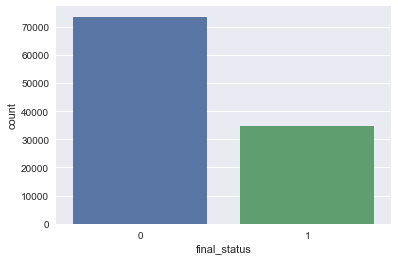

In [56]:
sns.countplot(x='final_status',data=train)

**only about 30% of the projects are successfully funded.**

## 3. Projects will more backers should have a greater rate of success, also goals that are too lofty might not be reached. 

So, I check if **final_status** correlates with **backers_count** and **goal**

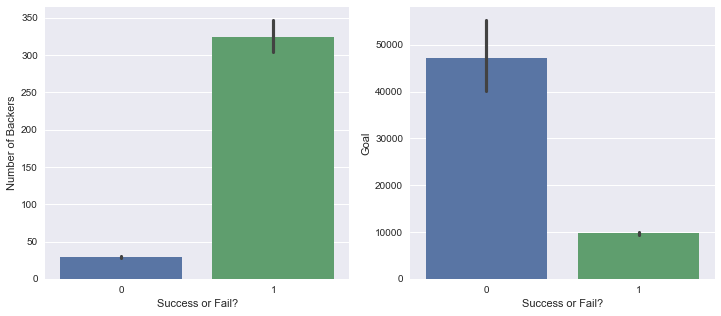

In [352]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.barplot ('final_status','backers_count',  data=train, ax=ax1)
ax1.set(ylabel='Number of Backers', xlabel='Success or Fail?') 
sns.barplot ('final_status','goal',  data=train, ax=ax2)
ax2.set(ylabel='Goal', xlabel='Success or Fail?') 

In [353]:
#goal
mean_goal=train.groupby('final_status')['goal'].mean().T
median_goal=train.groupby('final_status')['goal'].median().T
#backers
mean_backers=train.groupby('final_status')['backers_count'].mean().T
median_backers=train.groupby('final_status')['backers_count'].median().T

print ('Successful kickstarters have' )
print('mean_goal: $',mean_goal[1], 'mean_backers:',mean_backers[1])
print('median_goal: $',median_goal[1], 'median_backers:',median_backers[1])

print ('\n\nFailed kickstarters have' )
print('mean_goal: $',mean_goal[0], 'mean_backers:',mean_backers[0])
print('median_goal: $',median_goal[0], 'median_backers:',median_backers[0])

Successful kickstarters have
mean_goal: $ 9721.36464871 mean_backers: 323.981800295
median_goal: $ 3200.0 median_backers: 75


Failed kickstarters have
mean_goal: $ 47147.2708026 mean_backers: 29.3445078847
median_goal: $ 5500.0 median_backers: 5


**Successfully funded projects have a median goal of  3250;
Failed projects wanted 2250 USD more, at 5500 USD!**

**The median successful project also had 15x more backers.** 

## 4. When project authors disable communication with backers - they always fail

(0, 400)

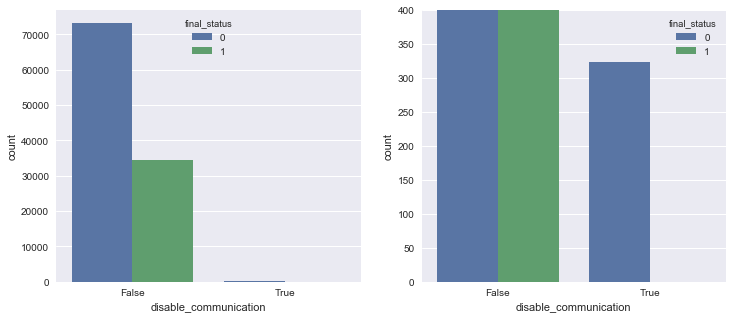

In [103]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
sns.countplot(x='disable_communication',data=train, hue='final_status', ax=ax1)
sns.countplot(x='disable_communication',data=train, hue='final_status', ax=ax2)
sns.plt.ylim(0,400)

**Projects with communication disabled always failed!**

## 5. How does time information provided affect project success?

Converting times in **unix timeformat** to **days**

In [215]:

date_times=['deadline','state_changed_at','created_at','launched_at',]

for i in date_times:
    train[i]=train[i].apply(lambda x: 
    datetime.datetime.fromtimestamp(int(x)).strftime("%Y-%m-%d %H:%M:%S"))
    train[i]=pd.to_datetime(train[i])


In [216]:
create_to_launch=(train.launched_at)-(train.created_at)
launch_to_deadline=(train.deadline)-(train.launched_at)
deadline_to_statechange=(train.state_changed_at)-(train.deadline)
train['create_to_launch']=(create_to_launch)
train['launch_to_deadline']=(launch_to_deadline)
train['deadline_to_statechange']=(deadline_to_statechange)


In [217]:
# conv_to_seconds=['create_to_launch','launch_to_deadline','deadline_to_statechange']
train['create_to_launch']=train['create_to_launch'].apply(lambda x:x.total_seconds()/3600/24)
train['launch_to_deadline']=train['launch_to_deadline'].apply(lambda x:x.total_seconds()/3600/24)
train['deadline_to_statechange']=train['deadline_to_statechange'].apply(lambda x:x.total_seconds()/3600/24)
train.head(100)

project_id                                               name  \
0   kkst1451568084                                drawing for dollars   
1   kkst1474482071  Sponsor Dereck Blackburn (Lostwars) Artist in ...   
2    kkst183622197                                      Mr. Squiggles   
3    kkst597742710                     Help me write my second novel.   
4   kkst1913131122             Support casting my sculpture in bronze   
5   kkst1085176748                                       daily digest   
6   kkst1468954715                          iGoozex - Free iPhone app   
7    kkst194050612                             Drive A Faster Car 2.0   
8    kkst708883590  """"""""""""""""""""""""""""""""""""""""""""""...   
9    kkst890976740  Choose Your Own Adventure - A Robot Painting S...   
10  kkst2053381363  Anatomy of a Credibility Meltdown — a book abo...   
11   kkst918550886  No-bit: An artist book of analog drawings insp...   
12   kkst934689279  Indie Nerd Board Game, Needs Player Character ...   
13   kkst191414809                         Icons for your iPhone apps   
14   kkst569584443  HAPPY VALLEY: Dexter meets 6 Feet Under. For t...   
15   kkst485555421                                      Project Pedal   
16  kkst1537563608            Frank Magazine Erotica Issue Party, NYC   
17  kkst1261713500                                 Crossword Puzzles!   
18   kkst910550425                               Run, Blago Run! Show   
19   kkst139451001                            It Might Become a Movie   
20  kkst1765345673                                      365 Postcards   
21   kkst858578162                                  Up North Cookbook   
22  kkst1714875186  Take a postcard trip with Anita as she waterco...   
23  kkst1055594093                    Decorative Nihilism Art Catalog   
24  kkst2097371618                            Unschooling : The Movie   
25   kkst700257702                        Send some kids to GameCamp!   
26  kkst1026630838                        Smogr Alert Field Recording   
27   kkst289563306  Unbunny's """"""""""""""""""""""""""""""""""""...   
28  kkst1298731864                          Help fund Flying Kebab #4   
29  kkst1066861265                                  Firewall of Sound   
..             ...                                                ...   
70   kkst946192531  Give a Greenlight to Socially Responsible Shop...   
71  kkst1389465571                       Man Chair iPhone Application   
72   kkst361178459  Support Independent Music: State of Man Tourin...   
73  kkst1488260038                                 Tattoo Documentary   
74   kkst238173443                                           Arise 3D   
75  kkst1623651727                      Help Shwa Make A Record? Yes!   
76   kkst367344056                 New Orleans POP (Party On Purpose)   
77  kkst1132301936                     LET'S SAIL AROUND THE WORLD !!   
78   kkst232946563                             MR. DREAM GOES TO JAIL   
79   kkst390712575                   The Ficly Server Support Project   
80  kkst1549078350                          Customer Service is Dead!   
81    kkst39562428  Community Mosaic Mural Project with Youth in N...   
82  kkst1949668698                      The Old Three Hundred Tribute   
83   kkst923461374   Gimme Shelter: A Children's Book on Dog Adoption   
84    kkst69905647       Music Lovers Unite For The Critical Darlings   
85   kkst963977251  Help Ozy Reigns complete and market his new EP...   
86  kkst1357825396  No Scroll Email (Custom Timesaving Email Appli...   
87  kkst1676616929                           The Redeemers Issues 1-4   
88  kkst1683169511  My debut album """""""""""""""""""""""""""""""...   
89   kkst928371912  Make the new Laura Meyer album, Back in New York!   
90  kkst1739328311                Health Reform: a visual explanation   
91  kkst1823457275       Keep Music Indie: April Smith Makes a Record   
92   kkst781690240                                 Start my studio

(0, 65)

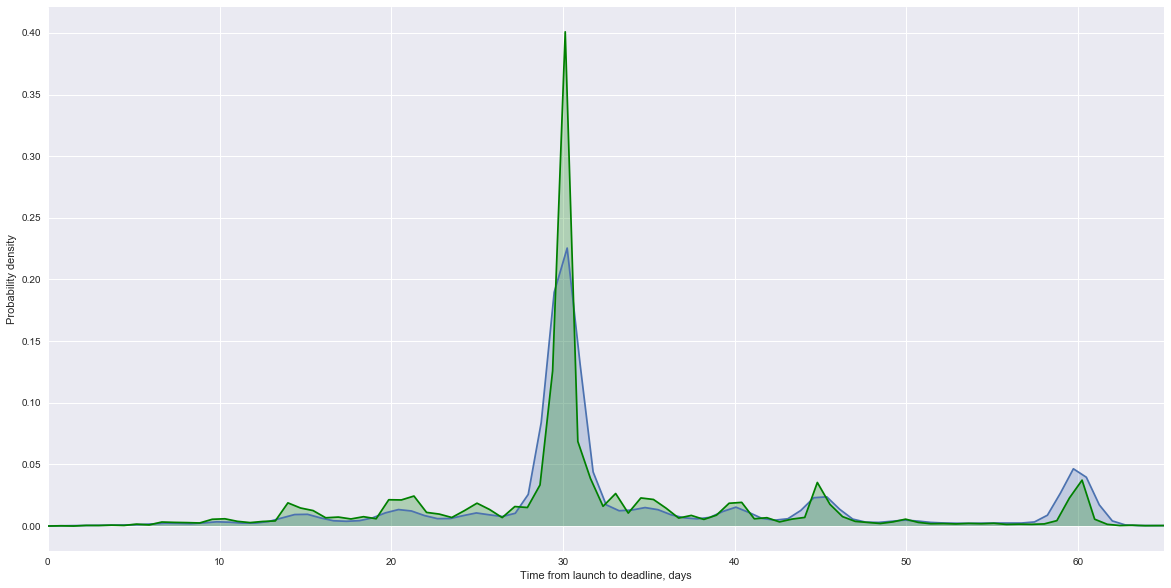

In [351]:
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(20, 10))
ax1=sns.kdeplot(train[train.final_status==0]['launch_to_deadline'], shade=True)

ax1=sns.kdeplot(train[train.final_status==1]['launch_to_deadline'], color='green', shade=True )
sns.plt.xlim(0,65)

ax1.set(xlabel='Time from launch to deadline, days', ylabel='Probability density') 
ax1.legend_.remove()
plt.show()

** 40 % **of successful projects set the deadline to **~30 days after launch**, while only **half (~22 %)** the number of failed projects did the same.

30 day projects may produce a sense of urgency while giving enough time to find backers.

## 6. Do certain keywords determine if the kickstarter campaign is a success or failure?

In [104]:
# splitting into successful and failed datasets
Positive=train[train.final_status==1]
Negative=train[train.final_status==0]

In [105]:
words = ' '.join(Positive['keywords'])
words=words.split('-' or ' ')
words=' '.join (words)
words

'drawing for dollars help me write my second novel drive a faster car 20 indie nerd board game needs hero miniature sculpted awesome icons for your iphone apps project pedal crossword puzzles it might become a movie 365 postcards up north cookbook take a postcard trip with anita as she watercolors decorative nihilism art catalog 0 unschooling the movie gamecamp athens unbunnys black strawberries limited edition lp flying kebab 4 firewall of sound help make attractive eighties womens new album offline wikipedia iphone app help us save our office put gareth asher on tour meeting andrei tarkovsky phase 2 produce a mean feature film skeletons dont sleep lexi street music project operation cd completio help make the new allison weiss ep uncle magazine issue 3 cheap art do it again one mans quest to reunite the kinks sycophants help bring our tv pilot to life 1 million inches in det frkwys excepter 12 a future now series led floaties at hoosac river lights laporte indiana our independent fea

In [106]:
failwords = ' '.join(Negative['keywords'])
failwords=failwords.split('-' or ' ')
failwords=' '.join (failwords)
failwords

'sponsor dereck blackburn lostwars artist in residence in kankakee illinois mr squiggles support casting my sculpture in bronze daily digest igoozex free iphone app lostles at tinys giant choose your own adventure a robot painting series anatomy of a credibility meltdown a book about the no bit an artist book of analog drawings inspired by digital pixels help me make my webseries pilot on crime and anti violence frank magazine erotica issue party nyc run blago run show smogr alert field recording bff tweetsourcing 2d side scrolling 16 bit with hand painted backgrounds action adventure game for xbox 360 live arcade iphone and pc innovating the way how children learn math zombie defense iphone app blow your money so we can blow your mind 0 gnash open source form management cms framework dawn of quixote rides to edinburgh fringe fest sleeping in a van metaphysical archaeology cities x design help me prototype an led light for the kindle help me finish my book and share it with the world n

In [135]:
# counts_success =[] 
# vocab_success =[]
cv = CountVectorizer(min_df=0, stop_words="english",analyzer='word', max_features=50 )
counts_success = cv.fit_transform([words]).toarray().ravel()                                                  
vocab_success = cv.get_feature_names()

cv2 = CountVectorizer(min_df=0, stop_words="english", max_features=50)
counts_fail = cv2.fit_transform([failwords]).toarray().ravel()                                                  
vocab_fail = cv2.get_feature_names()
mean_success=float(counts_success.mean())
mean_fail=float(counts_fail.mean())

# # # #(normalizing to make it a metric for machine learning)                                                                                                                                            
counts_success = counts_success/ float(counts_success.mean())
counts_fail = counts_fail / float(counts_fail.mean())  #divide by mean count to compare both datasets 
                                                        ##--failed:succesful projects is 70:30
    

In [338]:
df_success=pd.DataFrame()
df_success['vocab']=vocab_success
df_success['counts']=counts_success
df_success['final_status']=counts_success/counts_success

df3_success=df_success.sort_values(['counts'], ascending=[0])

In [339]:
df_fail=pd.DataFrame()
df_fail['vocab']=vocab_fail
df_fail['counts']=counts_fail
df_fail['final_status']=0/counts_success

df3_fail=df_fail.sort_values(['counts'], ascending=[0])


In [340]:
df3=pd.concat([df3_success, df3_fail])


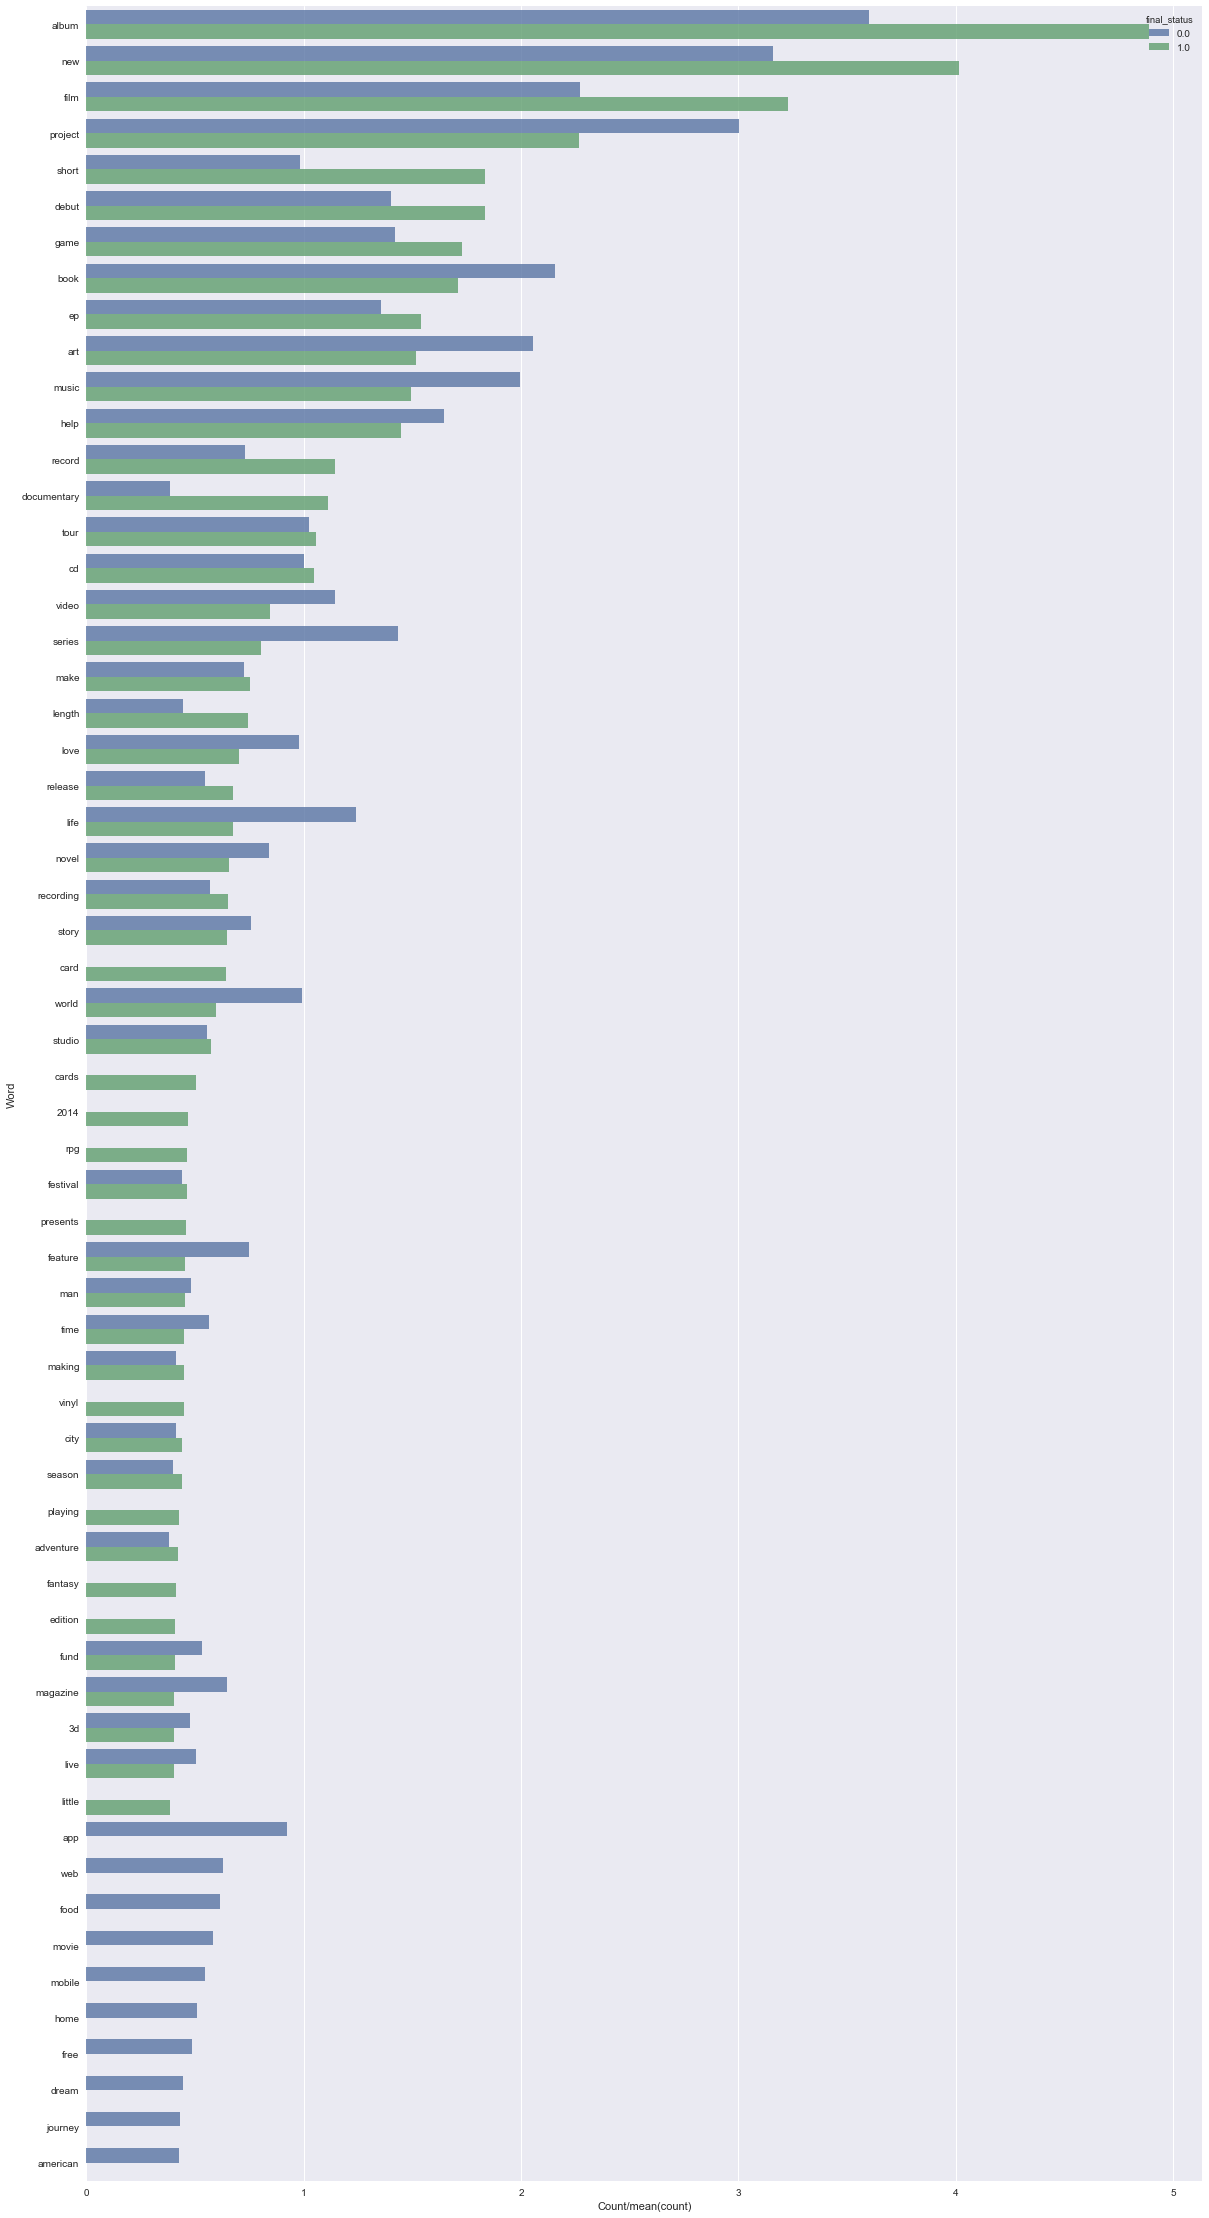

In [341]:
f, ax = plt.subplots(figsize=(20, 40))
ax = sns.barplot(x="counts",y='vocab', data=df3, hue='final_status' , alpha = 0.8  )
# ax2 = ax.twinx() 
# ax = sns.barplot(x="counts_s",y='vocab_s', data=df3_success, color ='green', alpha = 0.8 )



ax.set(xlabel='Count/mean(count)', ylabel='Word') 
plt.show()

# df2.plot(ax=ax)
#projects that use the word album succeed more often than they fail
#Top words used appear common among successful and failed projects

In [139]:
df4=df3.pivot(index='final_status', columns='vocab', values='counts')

df4.fillna(0, inplace=True)

df4.iloc[[0]]=df4.iloc[[0]]*-1
df4=df4.sum(axis=0)
df4
train.keywords.size

108129

In [125]:
train['keywords_value']=0
train.head()
for i in df4.index:
    for j in range(train.keywords.size):
        if '-' + i + '-' in train.keywords[j]:
            

            train.loc[j,('keywords_value')]=train.keywords_value[j]+df4[i]
            print(i, train.keywords[j],train.keywords_value[j] )
train.head()

2014 suny-purchase-class-of-2014-freshman-films 0.465624746943
2014 2013-2014-american-beauty-jumbo-oversize-calendar 0.465624746943
2014 south-jersey-writers-group-2014-anthology 0.465624746943
2014 modern-superstar-nothing-less-2013-2014-tour 0.465624746943
2014 zion-theatre-companys-2014-season 0.465624746943
2014 spectacular-sunrise-and-sunsets-the-2014-calendar 0.465624746943
2014 vlads-undead-angels-2014-calendar-posters-and-t-sh 0.465624746943
2014 12-black-lines-2014-calendar-and-limited-edition-p 0.465624746943
2014 meadowlark-music-festival-2014-season 0.465624746943
2014 support-sheandher-productions-2013-2014-season 0.465624746943
2014 the-daily-cat-a-2014-video-calendar 0.465624746943
2014 cantata-profanas-2013-2014-season 0.465624746943
2014 the-art-of-alzheimers-2014-calendar 0.465624746943
2014 dames-a-dozen-2014-pet-calendar-project 0.465624746943
2014 summer-exhibition-2014-from-copycats-to-true-artis 0.465624746943
2014 willow-grove-pirates-guild-2014-pirate-festival

2014 erin-and-the-wildfire-2014-single-fresh 0.465624746943
2014 trickor-halloween-trading-cards-inaugural-2014-col 0.465624746943
2014 sequel-to-truth-or-dare-2014-is-i-will-if-you-will 0.465624746943
2014 daehan-drama-awards-2014-ceremony 0.465624746943
2014 buskny-2014-we-are-culture 0.465624746943
2014 bent-con-2014-5th-anniversary-convention 0.465624746943
2014 sukkah-city-stl-2014-between-absence-and-presence 0.465624746943
2014 ghostwoods-books-our-2014-15-list-of-6-to-8-books 0.465624746943
2014 dont-miss-live-looping-at-the-2014-loopfests 0.465624746943
2014 vice-and-virtue-2014-a-dark-and-violent-fantasy-th 0.465624746943
2014 4-buckeyes-o-h-i-o-animating-the-2014-football-sea 0.465624746943
2014 uspf-2014-streaming 0.465624746943
2014 denver-dynamite-2014-15-season-fieldhouse-drive 0.465624746943
2014 one-last-thing-2014-csulb-bfa-graphic-design-show 0.465624746943
2014 the-holiday-experience-2014-a-jazzy-christmas-cele 0.465624746943
2014 2-bit-palomino-the-2014-cd-campaign

3d four-realz-3d-film-photography-in-4-dimensions -0.0754702306577
3d cnc-to-3d-printer -0.0754702306577
3d designed-for-healthy-eating-foodini-a-3d-food-prin -0.0754702306577
3d goodnight-lad-childrens-book-and-interactive-3d-ap -0.0754702306577
3d dots-the-point-a-3d-pointillist-painting -0.0754702306577
3d the-micro-the-first-truly-consumer-3d-printer -0.0754702306577
3d pungas-3d-printed-shoe-accessories -0.0754702306577
3d amaker-worlds-first-dual-arm-open-source-3d-printe -0.0754702306577
3d deltatrix-3d-printer -0.0754702306577
3d lix-the-smallest-3d-printing-pen-in-the-world -0.0754702306577
3d mamba3d-high-quality-open-source-3d-printer -0.0754702306577
3d lazeeeye-turn-your-smartphone-into-a-3d-camera -0.0754702306577
3d spooler-mini-a-3d-printing-material-winding-soluti -0.0754702306577
3d the-lunatic-3d-maze-puzzles-with-new-designs -0.0754702306577
3d bounce-metronome-tune-smithy-lissajous-3d-on-intel -0.0754702306577
3d dimenco-no-glasses-3d-tv-in-your-home-for-899 -0.075

3d printthebus-the-first-3d-printed-satellite-for-eve -0.0754702306577
3d boxzy-rapid-change-fablab-mill-laser-engraver-3d-p -0.0754702306577
3d 3dformer-a-pen-draws-3d-models-in-air-instantaneou -0.0754702306577
3d renderbot-3d-printer -0.0754702306577
3d stepcraft-2-universal-desktop-cnc-3d-printer-for-e -0.0754702306577
3d precino-opportunity-for-cheap-3d-print-sla -0.0754702306577
3d filamento-worlds-next-generation-3d-printer-materi -0.0754702306577
3d tiko-the-unibody-3d-printer -0.0754702306577
3d the-ekocycle-3d-printer-project -0.0754702306577
3d loco-3d-animated-original-series -0.0754702306577
3d the-diamond-hotend-single-nozzle-multi-color-3d-pr -0.0754702306577
3d inovated-3d-telescope -0.0754702306577
3d cordless-3d-print-finishing-tool -0.0754702306577
3d retouch3d-a-brand-new-way-to-finish-3d-prints -0.0754702306577
3d xeos-3d-printer -0.0754702306577
3d conspiracy-wearables-3d-printed-etle-universe-ring -0.0754702306577
3d sinterhard-metal-filled-filaments-for-3d-print

adventure crossing-souls-an-adventure-between-life-and-death 0.0425114222602
adventure wizards-day-an-indie-adventure-game-for-pc-mac-and 0.0425114222602
adventure the-gem-people-a-ya-fantasy-adventure-novel 0.0425114222602
adventure around-animated-adventure-film 0.0425114222602
adventure viktor-a-steampunk-adventure-demo-included 0.0425114222602
adventure califoryoucom-your-california-adventure-guide 0.0425114222602
adventure i-adventure-childrens-books 0.0425114222602
adventure selatria-a-classic-2d-role-playing-adventure-game 0.0425114222602
adventure scientific-adventure-into-the-depths-of-human-engi 0.0425114222602
adventure california-guild-adventure-for-freedom 0.0425114222602
adventure overture-the-16-bit-action-adventure-roguelike 0.0425114222602
adventure no-turning-back-the-pixel-art-action-adventure-rog 0.0425114222602
adventure paradise-city-golf-and-mystery-adventure-game 0.0425114222602
adventure help-make-the-kayak-adventure-series-fishing-pilot 0.0425114222602
adventu

album a-new-album-by-damian-quinones-y-su-nuevo-conjunto 1.29205936961
album self-titled-album-release 1.29205936961
album pandas-full-length-album-dare-to-care-athon 1.29205936961
album momentum-ldb-and-the-tyrant-producing-album-w-gram 1.29205936961
album cameron-mcgill-and-what-armys-new-album-is-a-beast 1.29205936961
album distribute-the-greatest-diy-compilation-album-ever 1.29205936961
album make-an-album-with-seth-abram-bible 1.29205936961
album urban-suns-push-to-complete-their-2nd-album-trunk 1.29205936961
album full-length-album-by-when-comets-collide 1.29205936961
album the-round-album-project 1.29205936961
album kelly-carvin-first-album-release 1.29205936961
album phylles-launch-of-the-album-the-coming 1.29205936961
album the-golden-cicada-album-project-for-welcome-to-sam 1.29205936961
album to-all-my-dear-friends-album-and-tour 1.29205936961
album jeremy-buck-and-the-bang-brand-new-album-and-2-mus 1.29205936961
album judith-avers-new-album-god-bless-the-brooders 1.292059369

album patrick-nortons-debut-album-easy-come-easy-go 1.29205936961
album dan-vaillancourt-live-album-tunes-and-tangents 1.29205936961
album first-album-for-james-lambert-band 1.29205936961
album we-are-church-christian-rock-album-by-michael-jame 1.29205936961
album war-drums-new-album-fortune-finder-and-tour 1.29205936961
album reunite-mini-cassette-recorder-for-an-album-in-sco 1.29205936961
album alice-practices-first-album-the-girls-without-face-0 1.29205936961
album mistaken-help-save-the-album-as-an-art-form 1.29205936961
album st-elias-help-us-make-album-2 1.29205936961
album in-the-days-of-noe-album-get-involved 1.29205936961
album the-marital-album-one 1.29205936961
album megan-jean-and-the-kfb-sophomore-album-ready-to-re 1.29205936961
album widening-circles-a-solo-guitar-album-by-benjamin-b 1.29205936961
album freelance-romantics-first-album-in-two-years 1.29205936961
album em-can-make-their-second-album-if-you-can-help-the 1.29205936961
album saul-new-album-2012 1.29205936961
a

album crystal-dennis-debut-album-and-christmas-album-rel 1.29205936961
album curious-poses-the-new-album-from-groove-8 1.29205936961
album three-simple-rules-first-born-premier-album-projec 1.29205936961
album scattered-birdz-is-releasing-an-album-you-betcha 1.29205936961
album jessica-is-dangerous-debut-album-gebrochene-herzen 1.29205936961
album hickory-robot-record-their-2nd-album-sawyer 1.29205936961
album r3igns-new-album-black-and-white 1.29205936961
album cali-lili-tm-rock-n-roll-indie-film-with-album-deb 1.29205936961
album the-making-of-rachel-lynns-breakthrough-album-rave 1.29205936961
album derwoods-smoke-filled-veins-album-release 1.29205936961
album new-tear-out-the-heart-album-project 1.29205936961
album second-album-creation-all-my-life 1.29205936961
album marketing-of-the-new-lina-fouro-album-and-music-pr 1.29205936961
album erin-sylvesters-album-project 1.29205936961
album amanda-marsten-butterfly-album-2012-and-music-vide 1.29205936961
album be-a-part-of-potcheens-6th

album grethor-album-hell-yes 1.29205936961
album rose-and-the-nightingales-album-the-spirit-of-the 1.29205936961
album spontaneous-album-creation 1.29205936961
album 7ray-album-release 1.29205936961
album maria-diebolt-wants-to-record-her-debut-album-inne 1.29205936961
album discount-cinemas-album-release 1.29205936961
album titled-an-album-of-songs-named-by-you 1.29205936961
album bullets-and-belles-premiere-full-length-album-be-g 1.29205936961
album postscript-the-brand-new-studio-album-from-ryan-co 1.29205936961
album glad-hearts-new-album-twenty-two-on-vinyl 1.29205936961
album little-city-the-new-album-from-jonathan-shue 1.29205936961
album polyphonic-sprees-next-studio-album-live-album-and 1.29205936961
album park-xxvii-album-release 1.29205936961
album the-sammus-theory-new-album-2013-project 1.29205936961
album vhs-vadun-holtwick-stecki-full-length-album-cd-fun 1.29205936961
album lancxeon-musicks-new-album-sanity-is-madness 1.29205936961
album 14-yr-old-singer-song-need-assist

album pre-order-our-new-album-blunt-force-trauma 1.29205936961
album douglas-county-daughters-studio-album-going-home 1.29205936961
album jimlapbaps-next-album-of-cover-songs-arrangements 1.29205936961
album festes-debut-album-first-folio 1.29205936961
album the-dead-armadillos-second-album-full-of-folk-rock 1.29205936961
album the-boobytraps-recording-our-second-album-help-fun 1.29205936961
album shameless-rob-bands-new-rock-album-project 1.29205936961
album heidi-jean-debut-album-release 1.29205936961
album grana-sabana-32-years-electronic-album-original-re 1.29205936961
album ian-torres-big-band-wants-to-release-debut-album-j 1.29205936961
album dan-johnson-and-the-expert-sidemen-studio-album-tw 1.29205936961
album throw-money-an-album-by-glenn-case 1.29205936961
album vinyl-release-of-wealthy-ghosts-debut-album-good-l 1.29205936961
album my-first-ep-album-against-the-grain 1.29205936961
album proj-tales-of-a-mad-man-album-release 1.29205936961
album the-new-album-january 1.29205936

album timothy-holts-first-cd-electronica-album-2nd-sessi 1.29205936961
album the-willie-hines-band-whatever-album-final-mix-ses 1.29205936961
album benjamin-david-hall-records-an-album-fathers-heart 1.29205936961
album topic-to-release-his-sophomore-album-be-good-and-d 1.29205936961
album the-approach-and-the-execution-album-2-kings-among 1.29205936961
album tonya-gilmore-presents-her-new-album-phantoms-fill 1.29205936961
album jipsy-magic-album-kickstarter-appeal 1.29205936961
album sammi-t-album-project-we-are-raising-funds-to-reco 1.29205936961
album aans-debut-album-amor-ad-nauseum 1.29205936961
album the-lost-tapes-album-the-name 1.29205936961
album kingdoms-new-album-redeemer 1.29205936961
album promote-5-album-series-with-timeless-songs-from-ye 1.29205936961
album synergy-new-cello-rock-album-expect-nothing-less 1.29205936961
album 4th-studio-album-0 1.29205936961
album sleepers-release-debut-album-on-vinyl 1.29205936961
album stukenbergs-new-album-novella 1.29205936961
album so

album molly-ryans-hot-new-jazz-album-and-music-video 1.29205936961
album six-to-midnights-debut-album-its-rock-n-roll 1.29205936961
album noah-hall-and-whiskey-priests-new-album-almost-sat 1.29205936961
album soundscape-a-new-album-from-dj-g 1.29205936961
album music-album-recordingmixing-and-mastering 1.29205936961
album bring-to-life-the-broken-home-album-with-kurse 1.29205936961
album tilts-second-album-release-on-vinyl-digital-and-wa 1.29205936961
album heartstrings-album-mastering-and-cd-production 1.29205936961
album when-oceans-rise-debut-album-find-a-way 1.29205936961
album tides-album-project 1.29205936961
album ian-ridenhour-new-album-kickstarter 1.29205936961
album the-book-of-life-vol1-album-release-and-tour-launc 1.29205936961
album recording-my-debut-album-songs-of-life-and-love-bo 1.29205936961
album votiv-debut-rock-album-limited-edition-exclusive-c 1.29205936961
album harakiri-album-tour-2014 1.29205936961
album an-album-of-10-jazz-art-songs-by-matthew-john-mort 1.2920

album laura-mam-records-her-new-album-in-search-of-heroe 1.29205936961
album cynonyte-dead-dream-gallery-new-album-for-2014 1.29205936961
album new-full-length-album-from-the-modern-savage 1.29205936961
album team-cybergeist-new-album-and-tour 1.29205936961
album ryan-harners-full-length-album-the-wonder-of-the-s 1.29205936961
album michael-riesenbeck-ii-album-melodic-rock 1.29205936961
album rocket-and-a-bomb-live-dvd-album-new-michael-knott 1.29205936961
album kyles-debut-album-0 1.29205936961
album colors-the-3rd-album-from-recording-artist-kanude 1.29205936961
album sightline-to-record-album-for-10-year-anniversary 1.29205936961
album socially-conscious-hip-hop-album-launch 1.29205936961
album saka-is-doing-an-album-and-we-want-you-to-be-apart 1.29205936961
album pre-order-the-new-album-from-controllar-osan 1.29205936961
album restraints-album-fund 1.29205936961
album new-album-featuring-a-major-artist 1.29205936961
album david-l-jarvis-new-album-0 1.29205936961
album produce-elain

album caitlin-jemma-and-the-goodness-full-length-album-a 1.29205936961
album the-reschad-oliver-experience-new-album-premiere 1.29205936961
album produce-sumkalis-3rd-album-tihai 1.29205936961
album i-thought-you-were-someone-else-album-release 1.29205936961
album nature-album-tamiasciurus 1.29205936961
album preorder-ben-masons-new-album-shed-need-a-heart 1.29205936961
album side-street-steppers-new-album-for-2015 1.29205936961
album marah-in-the-mainsails-full-length-album-thaumatro 1.29205936961
album listen-2-this-compilation-album-and-showcase-serie 1.29205936961
album walbum-the-world-album-photo-sharing-by-location 1.29205936961
album my-next-album-my-songs-my-dream-we-can-do-this 1.29205936961
album new-album-from-the-soul 1.29205936961
album the-greatest-album-covers-poster-you-choose-the-50 1.29205936961
album jordan-hope-millers-album-reflect-progress-transce 1.29205936961
album help-twin-brothers-with-album-we-make-hip-hop-musi 1.29205936961
album we-want-to-record-our-9th-

american wargaming-terrain-for-the-american-frontier-0 -0.425443841413
american el-ivy-eye-inn-the-great-american-novel-2013 -0.425443841413
american hitchnfish-a-real-american-story -0.425443841413
american african-musical-influences-on-american-classical-m -0.425443841413
american the-meatmen-new-album-and-north-american-tour 0.866615528201
american palisades-virtuosi-new-american-masters-volume-5 -0.425443841413
american 100-years-in-the-life-of-an-american-girl-1910-201 -0.425443841413
american help-us-create-the-all-american-cold-brew-coffee -0.425443841413
american the-skeptical-son-a-memoir-of-american-atheism -0.425443841413
american get-rich-quick-the-new-american-way -0.425443841413
american first-american-art-magazine-printing-issue-no-1 -0.425443841413
american hello-american-lady-creature-what-i-learned-in-qat -0.425443841413
american 100-native-american-dance-music-walk-in-beauty-lp -0.425443841413
american living-american-composer-roger-petrich-trumpet-con -0.42544384141

app ninepin-bowling-app-for-windows-phone -0.924477968908
app gorun-a-unique-new-fitness-app-with-real-world-rew -0.924477968908
app tapper-quest-for-the-cherry-an-android-app-video-g -0.924477968908
app creating-make-your-friends-app-so-i-can-pay-it-for -0.924477968908
app transit-app-for-the-twin-cities -0.924477968908
app a-mobile-app-that-sight-reads-sheet-music -0.924477968908
app surv-app-for-iphone -0.924477968908
app changing-gaming-one-app-at-a-time -0.924477968908
app help-me-finish-breach-my-4th-app-for-the-app-store -0.924477968908
app coffeenotes-app-a-new-way-to-think-about-brewing-c -0.924477968908
app flowdec-the-exciting-new-app-for-sports-fans -0.924477968908
app an-app-for-personalized-workouts-and-experimentati -0.924477968908
app the-grafi-app-mobile-messaging-in-your-own-handwri -0.924477968908
app flippenmusic-iphone-android-app-live-qanda-chat -0.924477968908
app appsamuck-over-30-new-online-iphone-app-developmen -0.924477968908
app viper-an-app-that-will-change

app the-bucketlist-app-0 -0.924477968908
app pulse-app-idea-for-ios-and-android -0.924477968908
app outflik-the-fashion-social-app-for-everyone -0.924477968908
app bipolar-daze-mobile-app-for-iphone -0.924477968908
app chill-time-the-app-for-the-perfectly-chilled-beero -0.924477968908
app pictora-a-mobile-app-relive-your-memories -0.924477968908
app standard-intake-an-app-that-modernizes-medical-pap -0.924477968908
app line-up-q-r-interaction-app-and-web -0.924477968908
app injury-prone-an-app-for-the-injury-phone -0.924477968908
app tank-stock-an-app-for-aquarists -0.924477968908
app flarecast-the-app-that-alerts-others-if-your-batte -0.924477968908
app market-the-perfect-stock-market-app-for-iphone -0.924477968908
app peerless-tutor-the-app-for-college-students -0.924477968908
app rudi-rainbow-an-educational-childrens-app-for-the -0.924477968908
app tag-me-a-photo-sharing-app-using-facial-recognitio -0.924477968908
app m-app-multi-select-mobile-file-management-applicat -0.92447796890

art junk-on-the-playa-burning-man-art-music-and-film-p -0.538461658505
art ecliptic-art-of-sun-gazing -0.538461658505
art snowjob-burning-man-art-car-fundraiser -0.538461658505
art hoololi-the-environmental-art-garden -0.538461658505
art make-a-beautiful-mistake-with-art-as-action -0.538461658505
art local-creations-art-festival -0.538461658505
art sweetie-potamus-art-car-for-burning-man -0.538461658505
art artbloc-a-mobile-art-space-made-from-2-shipping-co -0.538461658505
art tourist-in-chief-public-art-installation-by-leon-r -0.538461658505
art 88dc-burning-man-art-installation-singularity -0.538461658505
art flow-a-contemporary-windmill-art-recycling-wind -0.538461658505
art rites-of-passage-mobile-art-and-music-project-nyc -0.538461658505
art perspectives-large-scale-burning-man-art-project -0.538461658505
art roadside-temple-a-burning-man-art-installation -0.538461658505
art wild-and-scenic-pop-environmental-art-installation-0 -0.538461658505
art threshold-at-stone-quarry-hill-art

art tranceporter-ii-by-love-potion-burning-man-art-car -0.538461658505
art celebrities-on-canvas-the-key-club-exclusive-art-g -0.538461658505
art ginormous-exhibition-my-art-debut -0.538461658505
art introducing-kaye-art-jobs -0.538461658505
art diana-randolph-art-poetry-book -0.538461658505
art godly-acts-a-fine-art-series -0.538461658505
art intermittent-polarity-art-book-by-brent-and-kayla -0.538461658505
art vox-3-debut-recording-art-song-in-the-second-city -0.538461658505
art drews-art-show-2012 -0.538461658505
art sport-in-art-poster-project-2-baseball-and-3-footb -0.538461658505
art divine-feminine-art-project-burningman-2012-fertil -0.538461658505
art olde-school-honour-art-show-ft-nwk-john-guiney -0.538461658505
art kittykats-new-book-of-art-poetry-and-songs -0.538461658505
art art-now-rockports-art-exchange -0.538461658505
art an-abstract-art-event-in-kyiv-ukraine -0.538461658505
art create-art-with-the-conservatory -0.538461658505
art owls-for-the-playa-public-art-for-burnin

art kory-rox-art-painting-performance-exhibit -0.538461658505
art lizzie-hingley-brick-lane-art-exhibition -0.538461658505
art native-art-playing-cards -0.538461658505
art east-lake-gear-exchange-guitar-art-project -0.538461658505
art sweet-art-songs-of-hope-in-life-and-death -0.538461658505
art social-practice-art-with-children-in-taraz-kazakhs -0.538461658505
art rescued-heroes-veterans-edition-art-of-service-dog -0.538461658505
art henri-yoki-new-album-art-book-documentary-film-mor 0.753597711109
art the-handsome-cab-and-3room-art-gallery -0.538461658505
art love-to-make-art-want-to-make-it-on-a-much-bigger -0.538461658505
art the-art-of-loneliness -0.538461658505
art marthas-vineyard-public-art-project -0.538461658505
art cosmic-oasis-a-burning-man-art-installation-and-he -0.538461658505
art mural-and-art-garden -0.538461658505
art acre-kitchen-food-art-and-community -0.538461658505
art the-art-of-angels-an-illustrated-guide -0.538461658505
art urban-renewal-a-crowd-funded-public-a

art wrong-a-zine-of-art-and-design -0.538461658505
art zoofest-music-and-art-festival -0.538461658505
art 10-how-to-art-books-ready-for-printing-by-don-norr -0.538461658505
art sherwood-forest-fine-art-prints -0.538461658505
art under-one-roof-art-for-the-arts -0.538461658505
art the-art-and-science-of-natural-plaster -0.538461658505
art nails-the-contraption-art-and-science-on-the-playa -0.538461658505
art metal-art-project -0.538461658505
art making-a-scene-2013-art-book-art-from-classic-movi -0.538461658505
art through-the-flower-art-publication -0.538461658505
art dream-big-the-ix-art-park-project -0.538461658505
art need-to-promote-my-art-in-a-rented-space-for-galle -0.538461658505
art shoal-a-touring-interactive-art-installation -0.538461658505
art anne-and-marks-art-party-build-the-gallery-walls -0.538461658505
art minimalist-art-kentucky-derby -0.538461658505
art clouds-roadkill-the-fine-art-of-stephen-paternite -0.538461658505
art teoremi-performance-art-festival -0.5384616585

art slap-happy-sticker-poster-and-street-art-expo -0.538461658505
art angels-art-shop -0.538461658505
art color-collaboration-interactive-fiber-art-installa -0.538461658505
art the-cabbage-art-and-scarf-invitational -0.538461658505
art red-dragonfly-project-art-therapy-for-homicide-sur -0.538461658505
art the-art-of-darkness -0.538461658505
art telstra-aboriginal-art-prize-2015 -0.538461658505
art retro-dollys-mobile-art-therapy-studio -0.538461658505
art the-stories-art-can-tell -0.538461658505
art consequences-art-exhibition-in-london -0.538461658505
art washington-a-fine-art-expedition -0.538461658505
art beauty-in-darkness-the-art-book-by-zay -0.538461658505
art operation-art-rescue -0.538461658505
art the-art-is-jim -0.538461658505
art dawn-of-the-anthropocene-public-art-ice-sculpture -0.538461658505
art the-art-of-dying-2 -0.538461658505
art the-intergalactic-planetary-art-show -0.538461658505
art northwest-progressive-publications-art-politics-mu -0.538461658505
art she-looked-l

art 1-personalized-art-project -0.538461658505
art the-da-vinci-art-culture-and-education-center -0.538461658505
art the-art-of-fashion -0.538461658505
art les-jeunes-hommes-fine-art-male-photography -0.538461658505
art kickstart-colorado-art-with-crave-magazine -0.538461658505
art open-an-art-studio-in-fremont-ca -0.538461658505
art twenty-five-dollarsyou-get-a-limited-edition-art-g -0.538461658505
art different-art-from-every-state -0.538461658505
art meow-wolf-art-complex-ft-the-house-of-eternal-retu -0.538461658505
art the-naked-pixel-fine-art-nudes-collection-jordanle -0.538461658505
art the-scribblers-co-art-enrichment-program -0.538461658505
art intergalactic-poetry-art-music -0.538461658505
art your-art-book -0.538461658505
art a-dogs-life-a-photography-art-book -0.538461658505
art tattoos-legs-females-photography-art-book -0.538461658505
art double-glass-art-using-light-and-transparency-fami -0.538461658505
art my-art-for-the-world-to-open-a-lucrative-art-studi -0.538461658505

book all-downhill-from-ivan-puffenbarger-a-book-of-humo -0.449624733267
book first-interactive-book-no-more-national-debt -0.449624733267
book the-internet-of-elsewhere-european-book-tour -0.449624733267
book five-million-people-one-book-0 -0.449624733267
book sexy-solitary-suicides-six-book-spectacular -0.449624733267
book boiled-fish-art-book-project -0.988086391772
book klimt-schiele-art-book-love-and-other-violations-1 -0.988086391772
book the-veterans-book-project -0.449624733267
book erin-atlantis-book-one -0.449624733267
book idrawalot-book-series-4-years-of-drawings-collecti -0.449624733267
book wine-book-small-and-beautiful-wine-regions-by-wine -0.449624733267
book between-love-and-doctrine-a-dissertation-book-proj -0.449624733267
book the-truth-of-yesterday-book-tour -0.449624733267
book publishing-and-marketing-my-book-a-diary-of-the-un -0.449624733267
book wanted-a-professional-book-review-for-kids-recycli -0.449624733267
book when-suddenly-a-short-film-for-comic-book-fans 

book help-fund-my-1st-childrens-book-a-star-in-queens -0.449624733267
book all-fixed-up-a-red-piggy-press-book-app -0.449624733267
book intermittent-polarity-art-book-by-brent-and-kayla -0.988086391772
book born-to-tears-a-book-of-life-changing-poetry -0.449624733267
book the-sickness-book-1 -0.449624733267
book the-book-of-seconds -0.449624733267
book kittykats-new-book-of-art-poetry-and-songs -0.988086391772
book finally-a-book-on-fabric-die-cutting -0.449624733267
book werewarrior-mesr-book-1-silent-beasts-and-soldiers -0.449624733267
book publish-my-book-the-powered -0.449624733267
book botanique-a-hand-made-book-of-art-prints-by-harold -0.988086391772
book engraving-for-nerds-the-book-tour -0.449624733267
book scott-daniel-ellisons-book-project -0.449624733267
book imagine-me-book-series -0.449624733267
book the-lab-a-book-by-am-james -0.449624733267
book the-book-of-sean-a-short-film -0.449624733267
book the-boys-book-to-learning-what-love-is -0.449624733267
book new-book-from-au

book light-at-the-end-of-tunnels-an-interactive-book-of -0.449624733267
book shake-well-before-use-a-book-of-paintings-about-as -0.449624733267
book the-book-the-first-apple -0.449624733267
book split-souls-book-1-resurgere -0.449624733267
book murderville-comic-book-1-a-farewell-to-armories -0.449624733267
book juan-bleas-new-book-journey-to-aztlan -0.449624733267
book eclipse-book-2-in-the-bright-horizons-series -0.449624733267
book if-dogs-could-do-chores-a-kids-book-from-a-kid -0.449624733267
book the-art-of-words-first-poetry-book-publication -0.988086391772
book producing-book-2-of-the-coven-series -0.449624733267
book i-was-panics-bitch-book-about-surviving-a-panic-di -0.449624733267
book faith-illustrated-an-inspirable-book-on-faith -0.449624733267
book gayle-skidmore-new-music-video-coloring-book-and-t -0.449624733267
book portland-oregon-street-art-graffiti-book-volume-on -0.988086391772
book writing-a-book-for-females-with-aspergers-syndrome -0.449624733267
book tattoo-art-b

book the-secret-cake-book-project -0.449624733267
book karas-memiors-a-book-project -0.449624733267
book heaven-if-you-dont-have-a-prayer-read-this-book-as -0.449624733267
book the-lord-of-shadows-book-2 -0.449624733267
book make-medicine-dog-the-book-trailer-spread-the-pupp -0.449624733267
book help-produce-my-book-lincoln-nine-hours-before-dea -0.449624733267
book echoes-of-the-mystic-chords-book-1-leibniz-demon-t -0.449624733267
book 5-year-journey-book-one -0.449624733267
book bohemian-pipe-dreams-book-of-poetry-and-artwork -0.449624733267
book my-mothers-book-second-door-to-the-right -0.449624733267
book anne-of-green-gables-the-kitten-easy-reader-book-p -0.449624733267
book the-newest-book-on-the-blue-willow-pattern -0.449624733267
book the-horrors-coloring-book-of-cryptids-ghosts-and-m -0.449624733267
book chaos-awakens-book-2 -0.449624733267
book broken-flame-voice-of-hituni-ian-book-1 -0.449624733267
book the-azure-syndicate-trilogy-novels-book-one-the-ic -0.449624733267
book 

book dragons-song-an-art-book-a-novel-and-a-bs-degree -0.988086391772
book imperfect-comic-book-series -0.449624733267
book gone-to-the-dogs-book-about-the-search-for-the-bes -0.449624733267
book debut-book-same-child-different-day-several-years -0.449624733267
book new-childrens-book-project -0.449624733267
book online-sticker-book-vending-machine -0.449624733267
book help-lauren-get-to-art-book-clubs-september-show -0.988086391772
book chicago-mazes-a-book-where-puzzles-and-art-meet -0.988086391772
book al-rio-tribute-art-book-volume-one -0.988086391772
book disneyland-book-of-secrets-2015-independent-magic -0.449624733267
book creepy-scarlett-book-one-1 -0.449624733267
book coloring-book-by-linebyline -0.449624733267
book a-book-that-celebrates-diversity -0.449624733267
book forever-fearless-book-and-research -0.449624733267
book the-you-tell-me-what-to-draw-book-of-heroic-illust -0.449624733267
book in-the-arms-of-the-angels-book-manuscript-publicat -0.449624733267
book picture-boo

book the-boy-scout-book-project-saving-scout-fiction-19 -0.449624733267
book to-donate-maine-book-solace-to-ne-libraries-and-sc -0.449624733267
book nandibearcom-book-tracking-website -0.449624733267
book chubby-the-pug-book-series-part-1 -0.449624733267
book trapped-on-the-titanic-dramatized-audio-book-for-d -0.449624733267
book bring-your-own-book-the-game-of-borrowed-phrases -0.449624733267
book avas-demon-book-two -0.449624733267
book childrens-book-teaching-spanish-featuring-a-dalmat -0.449624733267
book the-dragons-quest-national-book-signing -0.449624733267
book the-man-book-coffee-table-book -0.449624733267
book gemini-crisis-book-i-records-of-the-slave-knights -0.449624733267
book wrote-a-book-wanna-read-it -0.449624733267
book the-razors-edge-based-on-the-book-giggling-in-fair -0.449624733267
book untitled-3rd-book-of-the-continuation-of-days-seri -0.449624733267
book tracy-wrote-a-book-help-publish-it-burgundy-boots -0.449624733267
book monsterkind-book-one -0.449624733267
b

card sketch-card-art-portfolio-project 0.103290710108
card flame-war-the-card-game-of-extreme-moderation 0.641752368613
card nova-cry-an-explosive-sci-fi-card-game-for-2-6-pla 0.641752368613
card kill-the-overlord-party-card-game 0.641752368613
card tooth-and-nail-factions-a-new-card-game-from-small 0.641752368613
card your-art-card-sleeves 0.103290710108
card bulrup-the-mystical-card-game-of-abstract-agricult 0.641752368613
card creative-dubuque-letterpress-post-card-series 0.641752368613
card goalstarter-accomplish-goals-one-index-card-at-a-t 0.641752368613
card first-card-deck-2012 0.641752368613
card make-blazon-the-card-game-a-reality 0.641752368613
card spider-kingdoms-playing-card-series-3-decks 0.641752368613
card the-great-heartland-hauling-co-a-card-game-for-2-4 0.641752368613
card solforge-digital-trading-card-game 0.641752368613
card s-is-for-ska-the-trading-card-series 0.641752368613
card plague-the-card-game 0.641752368613
card the-ichigen-san-card-a-minimal-bus-map-of-ky

card gvs-card-for-the-raspberry-pi-b-plus 0.641752368613
card 1876-mauger-quadruplicate-playing-card-restoration 0.641752368613
card boss-monster-dungeon-building-card-game-for-ios-an 0.641752368613
card stained-glass-business-card-holder 0.641752368613
card name-this-card-game 0.641752368613
card customizable-wooden-business-card-pen 0.641752368613
card pirate-loot-a-card-game-of-treasure-and-treachery 0.641752368613
card sawdust-circus-playing-card-deck-uspcc-printed 0.641752368613
card jane-austens-matchmaker-a-card-game 0.641752368613
card dithrandir-trading-card-game 0.641752368613
card seasons-a-changing-playing-card-series-printed-by 0.641752368613
card elemon-the-digital-monster-trading-card-game 0.641752368613
card my-cancer-card-and-other-titles-that-are-by-me 0.641752368613
card quad-video-card-crossfire-benmarking 0.641752368613
card periodyx-an-elemental-card-game 0.641752368613
card war-horn-card-battle 0.641752368613
card the-and-card-game 0.641752368613
card cosmic-rall

cards bicycle-army-men-playing-cards-deck 0.506113855373
cards a-deck-of-playing-cards-by-pedale-design 0.506113855373
cards aurum-custom-playing-cards-from-encarded 0.506113855373
cards bohemia-playing-cards-deck 0.506113855373
cards sic-cards-from-the-slightly-imperfekt-card-company 1.14786622399
cards akiva-art-project-52-playing-cards-featuring-origi -0.0323478031323
cards creature-cards-monstrous-playing-cards-for-games-o 0.506113855373
cards beautiful-and-inspirational-cards-and-gifts 0.506113855373
cards a-new-line-of-edgy-christmas-cards-from-twisted-an 0.506113855373
cards bicycle-black-tie-playing-cards-part-ii 0.506113855373
cards 8-bit-bicycle-playing-cards-0 0.506113855373
cards the-lincoln-deck-custom-design-playing-cards-uspc 0.506113855373
cards bicycle-the-lumberjacks-playing-cards-deck 0.506113855373
cards lucent-playing-cards-by-sean-whelan 0.506113855373
cards polaris-new-deck-from-vanda-playing-cards-printed 0.506113855373
cards freakies-playing-cards-custom-bicycl

cd phoenix-rising-the-five59-music-cd-project 0.0460002604622
cd renee-wahls-cumberland-moonshine-debut-cd-0 0.0460002604622
cd fund-new-cd-for-richard-cheese-and-lounge-against 0.0460002604622
cd farnell-newton-debut-cd-project-class-is-now-in-se-0 0.0460002604622
cd kate-macleod-and-kat-eggleston-duo-cd-2 0.0460002604622
cd first-professional-cd-recording 0.0460002604622
cd indie-music-cocktail-rock-cd-project-damn-handsome 0.0460002604622
cd sketches-in-time-poetry-book-audio-cd-and-doc-kick -0.403624472805
cd en-el-proximo-cd-de-origen-tu-eres-el-5to-miembro 0.0460002604622
cd chris-lavancher-debut-cd-roadside-attractions 0.0460002604622
cd adcas-debut-cd-will-bring-great-chamber-music-to-y 0.0460002604622
cd record-and-release-nicks-first-cd-string-quartet-n 0.0460002604622
cd new-cd-from-stewart-francke 0.0460002604622
cd carolina-bluesman-records-cd-north-mississippi-sty 0.0460002604622
cd production-of-cloning-around-music-cd-by-simply-we 0.0460002604622
cd tuesdays-letter-cd-p

cd jordan-rager-cd-project 0.0460002604622
cd beneath-the-apple-tree-on-professional-cd-release 0.0460002604622
cd the-second-cd-of-the-oringinal-works-of-the-wastel 0.0460002604622
cd coyote-cd-project-another-town-and-other-originals 0.0460002604622
cd new-cd-and-music-video-only-you-can-make-it-happen 0.0460002604622
cd jon-grinder-is-recording-his-first-studio-cd-lucky 0.0460002604622
cd modern-snack-bar-new-cd-from-who-are-those-guys 0.0460002604622
cd psyphen-debut-cd-ontogeny 0.0460002604622
cd 100-faith-jazz-gospel-cd-recording-project-2012 0.0460002604622
cd our-world-cd-production 0.0460002604622
cd charlies-new-live-cd-and-dvd-recording 0.0460002604622
cd jennie-avilas-new-civil-war-cd-voices-of-the-past 0.0460002604622
cd lena-bloch-debut-cd-unforeheard 0.0460002604622
cd ars-meta-omnisens-the-cd-dvd 0.0460002604622
cd new-cd-from-seven-years-past-w-multi-platinum-prod 0.0460002604622
cd debut-cd-of-rob-schreibers-standard-issue 0.0460002604622
cd stoneface-honey-cd-project

cd nightingale-set-to-record-their-debut-cd-cycle-of 0.0460002604622
cd bobs-new-irish-whistle-cd-my-lines 0.0460002604622
cd making-it-real-cd-tshirt-2xcombo 0.0460002604622
cd dr-shadenfreude-new-comedy-cd-by-c-axl-cones 0.0460002604622
cd static-illusion-debut-cd-kickstarter-project 0.0460002604622
cd bring-ty-durdens-album-to-cd-world-in-idaho-falls 1.33805963008
cd help-release-adoration-anthems-new-cd-by-josh-gilb 0.0460002604622
cd tony-copeland-new-cd-waterfalls 0.0460002604622
cd the-golden-thread-cd-project 0.0460002604622
cd manufacture-100-copies-of-debut-cd-by-punk-band-pe 0.0460002604622
cd saha-booker-churchville-cd-production 0.0460002604622
cd the-compositions-of-pepper-adams-big-band-cd-and-t 0.0460002604622
cd goeyvaerts-string-trios-new-cd-ft-avro-part-and-iv 0.0460002604622
cd scott-wests-austin-album-cd-music-for-the-austin-m 1.33805963008
cd the-boogaloos-need-to-record-a-4-track-cd-of-origi 0.0460002604622
cd avian-cd-project-new-music-for-soprano 0.046000260462

cd gegenschein-dark-moon-over-paradise-cd-lp 0.0460002604622
cd destiny-a-cd-by-texas-guitar-legend-nathon-dees 0.0460002604622
cd bushmaster-featuring-gary-brown-live-dvd-cd-set 0.0460002604622
cd adriannas-debut-cd-canadian-american-and-original -0.379443580951
cd joey-green-fiction-and-truth-cd-crowd-funded 0.0460002604622
cd hudson-falcons-new-cd-peace-of-mind 0.0460002604622
cd invisible-house-a-history-of-the-world-new-cd-albu 0.0460002604622
cd bluetooth-cd-music-streaming 0.0460002604622
cd support-andy-byrons-new-cd-project 0.0460002604622
cd marcus-mcconico-cd-project-italian-and-neapolitan 0.0460002604622
cd 2-bit-palomino-the-2014-cd-campaign 0.511625007405
cd brave-new-year-libby-wiebel-cd-project 0.0460002604622
cd lou-tambones-greatest-hits-debut-album-cd-digital 1.33805963008
cd the-king-book-and-audio-cd-with-music -0.403624472805
cd newpoli-southern-italian-folk-new-cd-nun-te-vuta 0.0460002604622
cd a-vocalis-christmas-cd-of-a-cappella-music 0.0460002604622
cd fil-cam

city the-philharmonia-of-greater-kansas-city-performanc 0.0273859226726
city winter-in-the-city-a-collection-of-urban-fantasy-t 0.0273859226726
city big-city-dream-show 0.0273859226726
city our-city-denver-and-delve-denver 0.0273859226726
city the-city-of-hope 0.0273859226726
city send-city-of-fallen-kings-to-the-studio 0.0273859226726
city get-a-custom-hat-save-a-new-york-city-factory 0.0273859226726
city fund-songs-for-a-high-school-dance-lp-by-city-rain 0.0273859226726
city 101-monumental-new-york-city-events 0.0273859226726
city arcanis-the-cradle-of-empires-the-first-city-sourc 0.0273859226726
city ether-q-windy-city-diary-hip-hop-album 0.0273859226726
city an-writer-trapped-in-the-body-of-a-city-worker 0.0273859226726
city tales-of-the-crescent-city-from-golden-goblin-pres 0.0273859226726
city middle-twin-city-of-gold-ep 0.0273859226726
city treachery-in-beatdown-city-a-tactical-beat-em-up 0.0273859226726
city making-music-city-sing 0.0273859226726
city are-you-ready-for-the-chap

debut the-debut-a-feature-film-featuring-the-sights-and 0.431341783429
debut dinsmore-debut-ep 0.431341783429
debut the-woodshed-prophets-debut-record 0.431341783429
debut steven-jamails-solo-concert-debut-0 0.431341783429
debut vintage-modernists-debut-album 0.431341783429
debut you-can-release-ricky-raves-debut-album-0 1.72340115304
debut i-remember-you-wendy-hayes-debut-album 0.431341783429
debut heather-christian-and-the-arbornauts-debut-album-c 1.72340115304
debut the-other-shore-marta-topferovas-debut-album-in-en-0 1.72340115304
debut the-sneaky-misters-debut-album-pretty 1.72340115304
debut carousel-rogues-master-and-press-their-debut-album 0.431341783429
debut renee-wahls-cumberland-moonshine-debut-cd-0 0.477342043891
debut blue-oaks-debut-album 0.431341783429
debut flying-a-kite-in-my-underwear-mana-maddys-debut-ep 0.431341783429
debut anna-haas-records-her-debut-album-crazy-is 1.72340115304
debut the-nuclears-debut-full-length-album 0.431341783429
debut farnell-newton-debut-c

debut tammy-rochelle-and-joseph-bamber-debut-duo-record 0.431341783429
debut whats-up-its-me-new-randb-from-debut-artist-rod-cl 0.431341783429
debut leave-her-crying-mississippi-punk-rock-debut-album 0.431341783429
debut opium-symphony-debut-album-blame-it-on-the-radio 1.72340115304
debut subsoniqs-debut-ep-and-music-video-project 0.431341783429
debut gas-station-disco-debut-album-project 1.72340115304
debut amerakin-overdose-debut-full-length-album 0.431341783429
debut pulse-dfw-debut-album 0.431341783429
debut heres-to-sorrow-debut-cd 0.431341783429
debut help-fund-kristina-kidd-and-the-coalitions-debut-e 0.431341783429
debut impulse-debut-album 0.431341783429
debut zacc-harris-group-debut-album 0.431341783429
debut the-hoons-record-their-debut-album 0.431341783429
debut help-cowgill-record-side-one-of-their-debut-album 0.431341783429
debut jump-start-your-heart-debut-ep 0.431341783429
debut stone-bullet-debut-album 0.431341783429
debut meagan-adele-lopez-debut-novel-three-questions 

debut project-one-the-jen-oikawa-trio-debut-album 0.431341783429
debut complete-partitas-by-js-bach-for-pianists-debut-al 0.431341783429
debut mid-octobers-debut-demo 0.431341783429
debut moxy-go-gos-debut-record 0.431341783429
debut by-george-debut-album 0.431341783429
debut hannalee-records-its-debut-ep 0.431341783429
debut tro1010-debut-vinyl-lp 0.431341783429
debut joeys-debut-record 0.431341783429
debut recording-debut-album 0.431341783429
debut lets-do-this-trisha-luries-debut-albumromancing-ne 0.431341783429
debut hal-9000s-debut-rap-album 0.431341783429
debut the-field-day-jitters-debut-album 0.431341783429
debut stinky-pinkys-debut-lp-a-rose-by-any-other-name 0.431341783429
debut release-and-promote-anna-carows-debut-album-city-s 1.75078707572
debut eric-shouse-is-recording-his-debut-solo-album 0.431341783429
debut help-nations-record-a-debut-ep 0.431341783429
debut digital-noise-academy-debut-album-completion 1.72340115304
debut vessels-debut-album 0.431341783429
debut audio-

debut how-weve-changed-jesus-neal-samudres-debut-book 0.431341783429
debut publish-the-seventh-sin-my-debut-novel 0.431341783429
debut old-meets-new-elephant-rescues-debut-album 0.431341783429
debut jason-lee-and-the-rip-tides-debut-album-project 1.72340115304
debut unknow-you-debut-album 0.431341783429
debut the-romance-of-liszt-and-schubert-a-debut-album 0.431341783429
debut four-corners-debut-album 0.431341783429
debut avalanche-creeks-debut-album 0.431341783429
debut the-tyler-mire-big-band-debut-recording 0.431341783429
debut roll-it-overs-debut-album 0.431341783429
debut rhythm-and-bruise-the-debut-of-the-private-instiga 0.431341783429
debut leng-debut-ep-fruity-0 0.431341783429
debut leslie-odom-jr-debut-album-project 1.72340115304
debut john-scott-youngs-debut-album 0.431341783429
debut leona-x-records-her-debut-ep-ready-for-this 0.431341783429
debut yes-dears-debut-studio-album 0.431341783429
debut magics-debut-album 0.431341783429
debut be-apart-of-ryan-readys-debut-record 0.

debut stvalentinez-debut-album-bullet-with-the-butterfly 1.72340115304
debut rambling-spirit-debut-of-a-new-magazine 0.431341783429
debut the-buttress-behind-every-great-man-debut-ep 0.431341783429
debut julia-storms-tokyo-records-its-debut-ep 0.431341783429
debut beautiful-machines-debut-album-launch-disconnect-r 1.72340115304
debut gammabands-chemical-change-debut-album 0.431341783429
debut help-zack-vandermyde-make-his-debut-album 0.431341783429
debut my-debut-album-naturally 1.72340115304
debut kendra-rae-hites-debut-album 0.431341783429
debut paul-dietrich-quintet-debut-album-we-always-get-th 1.72340115304
debut jimmy-real-is-recording-a-debut-ep 0.431341783429
debut michael-zigon-debut-album 0.431341783429
debut eastman-film-music-ensemble-debut-concert 0.431341783429
debut choc-electrique-record-their-debut-album-smoke-and 1.72340115304
debut straightdavis-debut-cd-and-tour-launch 0.477342043891
debut help-fund-talos-debut-album 0.431341783429
debut dr-gregory-kyles-debut-cd-dia

debut kelly-bosworths-debut-album 0.431341783429
debut create-debut-music-video-for-a-new-christian-count 0.431341783429
debut chris-klaxtons-debut-record-release-and-recording 0.431341783429
debut scott-dichiaras-acoustic-debut-ep-one-of-a-kind 0.431341783429
debut a-commoners-revolt-debut-album 0.431341783429
debut barkada-quartets-debut-album-aventura 1.72340115304
debut theegeneral-is-creating-his-debut-ep-titled-free-s 0.431341783429
debut justice-cammacks-debut-cd-last-goodbyes 0.477342043891
debut the-cantabile-vocal-ensemble-to-record-debut-album 0.431341783429
debut elia-esparza-debut-ep 0.431341783429
debut ashland-air-debut-electronic-ep 0.431341783429
debut rick-barth-debut-cd-hand-me-down-soul 0.477342043891
debut no-snake-the-debut-album-by-kings-of-the-city 1.72340115304
debut john-thomas-drapers-debut-blues-roots-cd 0.431341783429
debut the-cut-losses-debut-album-and-tour 1.72340115304
debut 20-song-debut-demo-album-the-young-storyteller 1.72340115304
debut slam-mccrack

debut cloud-soul-debut-album-rnb 1.72340115304
debut funding-for-debut-studio-album 0.431341783429
debut pocket-parks-habitat-debut-album 0.431341783429
debut chris-quirarte-debut-solo-album 0.431341783429
debut christian-brays-debut-album 0.431341783429
debut richies-debut-album 0.431341783429
debut coburn-station-debut-lp 0.431341783429
debut help-fund-auburn-skys-debut-album 0.431341783429
debut crma-clb-help-us-fund-our-debut-album 0.431341783429
debut the-muchmores-debut-album 0.431341783429
debut watch-the-sky-debut-album-from-run 1.72340115304
debut otg-orient-towards-giving-musical-debut-ep 0.431341783429
debut help-the-band-j4-make-their-debut-ep 0.431341783429
debut rays-debut-album-is-already-in-progress-lets-do-th 1.72340115304
debut tripp-powell-and-co-debut-album-vintage-revival 1.72340115304
debut andrew-russells-debut-ep 0.431341783429
debut mcdaid-debut-album-a-bridge-from-scotland-to-ameri 1.72340115304
debut highdives-debut-full-length-album 0.431341783429
debut sai-

documentary iceland-documentary-with-mary-ellen-mark 0.727101479889
documentary oxyana-a-feature-documentary-directed-by-sean-dunn 0.727101479889
documentary spectacular-movements-documentary-post-production 0.727101479889
documentary halfway-home-the-documentary-film 0.727101479889
documentary jabari-presents-season-2-documentary-web-series 0.727101479889
documentary antarctica-a-year-on-ice-documentary-feature-film 0.727101479889
documentary the-cheer-ambassadors-documentary-film 0.727101479889
documentary the-surrounding-game-a-documentary-film 0.727101479889
documentary words-of-witness-documentary-film-tour 0.727101479889
documentary help-produce-a-tv-documentary-about-treasure-insid 0.727101479889
documentary see-know-evil-a-documentary-film 0.727101479889
documentary k2-documentary-film 0.727101479889
documentary whoopi-goldbergs-documentary-i-got-somethin-to-tel 0.727101479889
documentary in-the-trenches-of-rock-and-roll-a-documentary-fil 0.727101479889
documentary jessica-gonz

documentary the-perfect-storm-documentary-on-the-94-montreal-e 0.727101479889
documentary the-world-is-yours-documentary-on-hip-hop-and-the 0.727101479889
documentary gary-baseman-documentary-mythical-creatures 0.727101479889
documentary oyler-a-documentary-film 0.727101479889
documentary the-groove-is-not-trivial-documentary-film 0.727101479889
documentary b1g-baseball-on-the-road-documentary-series 0.727101479889
documentary zone-9-a-documentary-film 0.727101479889
documentary medicaid-expansion-documentary-series-entitled-to 0.727101479889
documentary model-citizens-a-model-railroading-documentary-in 0.727101479889
documentary living-springs-a-documentary-series-about-barton-s 0.727101479889
documentary fund-my-trip-to-iraq-to-film-a-documentary-on-isil 0.727101479889
documentary the-baggage-project-a-documentary-photography-proj 0.727101479889
documentary until-20-a-feature-documentary-film 0.727101479889
documentary a-house-divided-a-new-documentary-about-debate-in 0.727101479889


dream dave-crater-and-his-dream-team-are-recording-timel -0.442691564713
dream wide-awake-dream-a-new-album-by-cordelia-stephens 0.849367804901
dream a-midsummer-nights-dream-at-the-winter-garden -0.442691564713
dream the-dream-square-project -0.442691564713
dream tibetan-dream-yoga-masters-of-lucid-dreaming -0.442691564713
dream hartford-river-dream-1-no-one-wants-to-be-the-rive -0.442691564713
dream fulfilling-a-dream-my-first-major-solo-exhibition -0.442691564713
dream my-dream-is-to-publish-a-collection-of-personal-vi -0.442691564713
dream a-dream-in-the-making -0.442691564713
dream justines-dream-an-art-gallery -0.981153223219
dream magic-dream-ambigrams -0.442691564713
dream making-a-my-dream-a-reality-my-country-music-album -0.442691564713
dream loving-vibes-a-living-dream-catcher -0.442691564713
dream the-dream-cycle-of-randolph-carter-web-series -0.442691564713
dream wolf-a-book-a-dream-a-legacy -0.89231629798
dream living-the-dream-now-from-dreamers-to-reality-make -0.4426915

edition letter-to-a-future-lover-limited-edition-a-book-in -0.0406847381254
edition prntposters-limited-edition-prints 0.408939995141
edition underground-playing-cards-diamond-edition-printed 0.915053850514
edition dragon-age-collectors-edition-review 0.408939995141
edition john-ambrose-rsma-exhibition-and-limited-edition-p 0.408939995141
edition house-of-perception-a-limited-edition-artists-book 0.408939995141
edition limited-edition-every-round-counts-boxset 0.408939995141
edition limited-edition-art-apparel-arkado-tee -0.129521663364
edition boy-king-islands-super-limited-edition-new-album 0.408939995141
edition simply-paper-air-planes-limited-edition-n-stuff 0.408939995141
edition macleod-dragons-11x17-limited-edition-calendar 0.408939995141
edition bear-vs-gorilla-vs-ceo-vs-hippie-1st-edition-last 0.408939995141
edition curium-magazine-edition-one 0.408939995141
edition agents-of-smersh-2nd-edition-the-ultimate-collecti 0.408939995141
edition the-wormworld-saga-book-edition-volume

ep sierra-west-hold-your-fire-ep-keep-it-burning 0.184064917132
ep memphibians-the-dirty-future-ep-and-national-tour 0.184064917132
ep melisa-le-rue-debute-ep-unite 0.184064917132
ep are-we-there-yet-ep-1-turkey-crossroads-of-the-wor 0.184064917132
ep naia-kete-ep-recording-and-music-video 0.184064917132
ep wait-for-it-ep-never-come-home 0.184064917132
ep underhander-debut-ep-and-video-documentary 0.615406700561
ep help-the-sleep-design-fund-an-ep-and-get-to-corner 0.184064917132
ep metaphorias-debut-ep-album 0.615406700561
ep it-came-from-over-there-ep-release 0.184064917132
ep super-nice-ep-2012 0.184064917132
ep nick-ladish-2012-ep-project 0.184064917132
ep rock-n-roller-remote-controller-ep-5 0.184064917132
ep beautiful-soul-ep-0 0.184064917132
ep debut-ep-by-austin-w-powell 0.184064917132
ep you-will-come-ep-project 0.184064917132
ep debut-ep-cd-for-the-monster-fool-duo 0.230065177595
ep davey-browns-first-ep-release 0.184064917132
ep all-we-know-ep-launch 0.184064917132
ep castin

ep terror-ep-by-do-you-like-bugs 0.184064917132
ep semper-die-ep-release 0.184064917132
ep no-strings-attached-electro-ep-by-sumhero 0.184064917132
ep awake-the-fate-studio-and-ep-production 0.184064917132
ep a-new-ep-from-matthew-squires-and-the-learning-dis 0.184064917132
ep new-ep-recording-project 0.184064917132
ep brave-ulysses-records-their-debut-ep-brave-ulysses 0.615406700561
ep bayless-ep-produced-by-jon-steingard-of-hawk-nelso 0.184064917132
ep max-lane-and-companys-debut-ep-san-jose 0.615406700561
ep pre-order-our-new-ep-get-busy-living 0.184064917132
ep anomaly-ep-rap 0.184064917132
ep fragile-strength-is-the-debut-ep-from-christopher 0.615406700561
ep garls-debut-ep-namesake 0.615406700561
ep sunset-to-burns-ready-to-record-new-ep-whiskey-sto 0.184064917132
ep 7suns-new-ep-launch-mama-raised-you-brave 0.184064917132
ep lewis-j-smiths-first-ep-moonlight-and-magnolias 0.184064917132
ep dayna-brown-jazz-vocalist-ep-pressing-discs 0.184064917132
ep help-fund-lindsay-bruces-ep-

ep scott-dichiaras-acoustic-debut-ep-one-of-a-kind 0.615406700561
ep theegeneral-is-creating-his-debut-ep-titled-free-s 0.615406700561
ep new-ep-album-from-mrd 1.47612428675
ep and-she-dances-the-new-ep-from-the-discount-orches 0.184064917132
ep veteran-ep-drive 0.184064917132
ep philip-marino-6-track-ep-produced-by-simone-felice 0.184064917132
ep slope114-the-satyagraha-ep-12-vinyl 0.184064917132
ep trish-mcaleny-ep-project 0.184064917132
ep very-unpopular-web-show-ep-1 0.184064917132
ep courtney-noes-debut-ep-1011-randb-rap-pop-yes-rap 0.615406700561
ep kept-quiet-ep-music-video 0.184064917132
ep eric-stuart-band-4-song-ep-character 0.184064917132
ep lauren-claires-ep-beautifully-you 0.184064917132
ep summer-heat-ep-donations 0.184064917132
ep project-phase-00001-debut-ep-creation-and-release 0.615406700561
ep centrefolds-the-tide-ep-release 0.184064917132
ep lvls-4th-ep-release 0.184064917132
ep thayer-cabin-hopes-to-release-a-new-ep-chapter-one 0.184064917132
ep dayz-rich-is-launch

fantasy tarnish-a-fantasy-novel-by-j-d-brink 0.412988905984
fantasy worlds-of-magic-a-new-classic-4x-fantasy-game 0.412988905984
fantasy dark-urban-fantasy-uf-novel-release-know-thy-frien 0.412988905984
fantasy fae-and-fantasy-caricature-garden-sculptures 0.412988905984
fantasy toolcards-fantasy-gm-cards 0.412988905984
fantasy xarken-dark-fantasy-web-series 0.412988905984
fantasy gravitys-revenge-an-epic-fantasy-w-internal-illust 0.412988905984
fantasy harmion-independent-fantasy-feature-film 0.412988905984
fantasy delve-a-sci-fi-fantasy-short-film 0.412988905984
fantasy wish-it-inc-a-comedy-fantasy-web-series 0.412988905984
fantasy help-turn-my-mg-ya-fantasy-novel-into-an-amazing-a 0.412988905984
fantasy lineage-fantasy-series-lineage-of-visions-and-line 0.412988905984
fantasy numin-uia-a-whimsical-epic-fantasy-novel-in-two-pa 0.412988905984
fantasy over-the-rainbow-a-gay-ya-fantasy-novel 0.412988905984
fantasy lucid-dream-fantasy-portrait-art -0.0297026587292
fantasy print-and-distri

fantasy witch-a-dark-modern-fantasy-role-play-game 0.412988905984
fantasy wyrd-bound-urban-fantasy-series 0.412988905984
fantasy citadel-of-the-sky-epic-fantasy-novel 0.412988905984
fantasy orc-princess-28mm-scale-fantasy-wargames-and-rpg-m 0.412988905984
fantasy glittership-an-lgbtq-science-fiction-and-fantasy-p 0.412988905984
fantasy kiron-fantasy-web-series 0.412988905984
fantasy saga-android-fantasy-rpg 0.412988905984
fantasy grinidon-a-fantasy-graphic-novel 0.412988905984
fantasy the-codex-lacrimae-an-epic-fantasy-trilogy 0.412988905984
fantasy to-break-my-enemies-a-modern-fantasy-novel 0.412988905984
fantasy a-game-of-thrones-fantasy-gaming-coins-by-shire-po 0.412988905984
fantasy voltara-battle-for-the-galaxy-scifi-book-fantasy-a -0.0366358272824
fantasy fierce-winds-rising-a-fantasy-novel 0.412988905984
fantasy snapdrafts-daily-fantasy-sports 0.412988905984
fantasy final-fantasy-an-animated-tribute 0.412988905984
fantasy the-sapphire-wave-a-sci-fi-fantasy-novel 0.412988905984
f

feature the-cylinder-feature-film -0.293048721407
feature never-too-much-feature-film -0.293048721407
feature thorium-remix-2012-feature-film-to-propagate-hard -0.293048721407
feature what-luck-feature-film-seeks-completion-funds -0.293048721407
feature barmy-feature-film-needs-digital-print-for-festiva -0.293048721407
feature independent-feature-horror-film-community-service -0.293048721407
feature mahogany-sunrise-feature-film -0.293048721407
feature as-it-is-in-heaven-independent-feature-film -0.293048721407
feature character-design-for-the-animated-feature-film-los -0.293048721407
feature the-dark-tales-of-el-diablo-feature-film -0.293048721407
feature kazu-the-feature-film -0.293048721407
feature v3-a-feature-film-project-created-by-cwu-students -0.293048721407
feature headlines-an-educational-feature-film-project -0.293048721407
feature your-girl-is-mine-feature-film -0.293048721407
feature thicker-than-water-a-feature-film -0.293048721407
feature one-way-a-feature-film -0.293048

feature god-grant-me-a-feature-length-independent-film -0.293048721407
feature coming-out-a-feature-documentary -0.293048721407
feature amnesia-independent-feature-film -0.293048721407
feature off-time-feature-film -0.293048721407
feature our-lost-sons-feature-documentary -0.293048721407
feature is-a-feature-film-set-on-the-threshold-of-infinity -0.293048721407
feature the-sound-of-sangre-a-feature-length-documentary -0.293048721407
feature umbrella-feature-film-post-production -0.293048721407
feature safaar-sci-fi-action-feature-film -0.293048721407
feature precipice-hours-post-apocalyptic-feature-film -0.293048721407
feature khoya-a-feature-film-in-post-production -0.293048721407
feature the-stray-independent-feature-film-horror-drama-th -0.293048721407
feature do-you-remember-a-feature-film -0.293048721407
feature the-ascent-feature-film-post-production -0.293048721407
feature comedy-feature-this-is-sanlitun-festival-funding -0.293048721407
feature stanford-and-sons-feature-film -0.

feature fish-and-men-a-documentary-feature-film 0.434052758482
feature greenhorn-feature-film -0.293048721407
feature the-get-money-feature-film-production -0.293048721407
feature the-acts-of-thaddeus-a-dramatic-feature-film -0.293048721407
feature terrific-tales-a-horror-thriller-feature-film-proj -0.293048721407
feature brujo-horror-art-house-feature-film -0.831510379912
feature the-chosen-a-feature-film -0.293048721407
feature the-lotus-eater-feature-length-queer-film -0.293048721407
feature you-can-stay-or-you-can-go-a-feature-film -0.293048721407
feature a-certain-evil-feature-film -0.293048721407
feature pms-cop-feature-horror-film -0.293048721407
feature maya-horror-feature-film-post-production -0.293048721407
feature brew-house-feature-film -0.293048721407
feature dont-move-in-feature-film -0.293048721407
feature the-black-mist-feature-supernatural-film -0.293048721407
feature ninja-turtles-feature-fan-film -0.293048721407
feature alien-vs-predator-dissolution-a-feature-length-

festival siena-music-festival-and-competition-thomas-hunter 0.0211839678267
festival new-fangled-festival-of-opera 0.0211839678267
festival los-angeles-st-davids-day-festival-national-day-of-0 0.0211839678267
festival unorthodox-film-festival-tour 0.0211839678267
festival womens-festival-of-sacred-music-2014 0.0211839678267
festival visions-film-festival-roundup 0.0211839678267
festival broken-side-of-time-film-festival-edition 0.0211839678267
festival the-international-conductors-festival-2013 0.0211839678267
festival shall-we-gather-selected-for-festival-performance 0.0211839678267
festival 2013-bicycle-music-festival-permit-push 0.0211839678267
festival pikes-falls-chamber-music-festival-in-2013-halfway 0.0211839678267
festival founding-a-new-orchestra-the-raleigh-festival-orch 0.0211839678267
festival lollapalooza-festival-guide-2013 0.0211839678267
festival spike-and-mikes-sick-and-twisted-festival-of-anima 0.0211839678267
festival 2nd-annual-detroit-underground-film-festival-8-22

film ive-been-waiting-most-intense-short-film-of-the-ce 0.953732010849
film help-us-make-an-affair-a-feature-film-0 0.660683289441
film the-deteriorationists-a-short-film-by-jordan-quell 0.953732010849
film the-trial-a-short-film-by-davide-pasti 0.953732010849
film for-sale-a-short-film-inspired-by-hemingway 0.953732010849
film fitted-the-urban-day-rollerblading-film-by-joseph 0.953732010849
film girls-will-be-girls-2012-a-sequel-to-the-cult-film-0 0.953732010849
film room-of-rumble-short-film-for-festivals-0 0.953732010849
film between-us-dan-mirvishs-new-film-based-on-the-hit 0.953732010849
film alone-together-short-film-launch 0.953732010849
film brent-weichsels-thesis-film-corbin 0.953732010849
film feature-film-sf-bay-area-all-roads-lead-to-occiden-0 0.953732010849
film its-movie-film-time-on-a-rooftop-aiming-for-the-st 0.953732010849
film the-dinner-table-a-short-film-about-family 0.953732010849
film the-lemon-a-film-by-gabriel-wilson 0.953732010849
film hazard-a-new-film-by-nick

film the-physical-a-short-film-by-luke-condzal 0.953732010849
film microlending-film-project-saving-the-worlds-women 0.953732010849
film breaking-a-film-by-nicco-quinones 0.953732010849
film christian-faith-based-feature-film-away 0.660683289441
film blue-a-short-film-by-ambitious-film-college-studen 0.953732010849
film 1-2-a-film-by-rodrigo-del-campo 0.953732010849
film lunch-break-film-ii-fundraiser 0.953732010849
film beneath-the-flesh-an-independant-guerilla-film-ser 0.953732010849
film you-have-the-power-to-put-our-film-in-theaters 0.953732010849
film a-new-life-and-without-film-festival-run 0.974915978675
film workers-of-the-digital-harvest-film-budget 0.953732010849
film abacus-sundance-film-fest-2012 0.953732010849
film short-film-my-beautiful-malady 0.953732010849
film esther-a-short-film-based-upon-an-original-ww2-sto 0.953732010849
film scholar-the-real-deal-short-film-music-video 0.953732010849
film clique-an-independent-film-by-phuong-hoang 0.953732010849
film a-short-shor

film holy-land-a-documentary-film-about-the-west-bank 1.68083349074
film welcome-to-central-market-senior-film-project 0.953732010849
film official-horror-film-sculptures-beginning-with-nig 0.953732010849
film double-back-short-film-about-ocd 0.953732010849
film divided-families-film-project 0.953732010849
film indie-film-bruises-from-nice-productions 0.953732010849
film experimental-film-equinox 0.953732010849
film flip-a-short-film-project 0.953732010849
film flex-is-kings-premiere-at-tribeca-film-festival 0.953732010849
film fund-our-unknown-film-in-the-48-hour-sci-fi-challe 0.953732010849
film from-where-im-standing-student-film-by-max-dickins 0.953732010849
film mouse-trap-film-project 0.953732010849
film coal-comfort-a-film-in-progress 0.953732010849
film no-return-a-short-film-by-zach-frankart 0.953732010849
film stomping-ground-feature-film-finishing-funds 0.660683289441
film momentum-short-film-set-in-the-year-2043 0.953732010849
film out-youth-theater-film-project 0.953732010

film out-in-the-line-up-a-film-about-homosexuality-in-s 0.953732010849
film flyka-electric-tracking-dolly-for-film-and-tv-stea 0.953732010849
film im-gone-a-film-about-amy-documentary-feature 1.68083349074
film snap-a-short-film-about-destiny-and-hats 0.953732010849
film short-film-starring-kalki-koechlin 0.953732010849
film just-passing-through-2nd-film-by-14-year-old-luke 0.953732010849
film documentary-film-elliot 0.953732010849
film dressed-as-a-girl-the-cult-british-film-in-the-mak 0.953732010849
film mayhem-behind-movies-comedy-feature-film-mbm 0.660683289441
film 2014-atlanta-film-festival-bring-artists-to-atlant 0.974915978675
film we-will-sing-a-film-about-the-1991-lithuanian-revo 0.953732010849
film mr-gaga-a-documentary-film-about-ohad-naharin 1.68083349074
film quake-the-film-beneath-our-feet-beneath-our-skin 0.953732010849
film this-is-not-graffiti-a-film-on-revolutionary-graff 0.953732010849
film run-fast-a-short-film-by-anna-musso 0.953732010849
film ttd-a-short-film-tha

film bring-mobile-motion-film-festival-to-life 0.974915978675
film break-a-short-film-by-nick-moss 0.953732010849
film just-plain-dead-a-campy-film-noir 0.953732010849
film since-we-last-a-film-about-love-and-loss 0.953732010849
film friends-in-deed-a-film-by-keith-cannon 0.953732010849
film in-our-blood-feature-film-development 0.660683289441
film a-film-called-stay 0.953732010849
film the-worlds-shortest-film-ever 0.953732010849
film a-year-of-film-chasing-a-world-record 0.953732010849
film harvest-season-horror-feature-film-harvestseasonmo 0.660683289441
film manilenos-a-film-by-the-filipino-street-art-projec 0.415270352343
film short-student-film-family-friendly-oj-scandal 0.953732010849
film southern-nights-horror-film-feature-length 0.660683289441
film pacemaker-a-profound-social-film-of-the-highest-ma 0.953732010849
film the-bridges-a-short-film-by-austeja-urbaite 0.953732010849
film microbe-short-film-post-production 0.953732010849
film wingboys-film-festival-fundraiser 0.97491

food structure-food-decay-a-painting-exploration -0.614018949499
food fast-food-vs-aliens -0.614018949499
food trailer-food-diaries-cookbook-portland-edition -0.614018949499
food movie-on-a-stick-outrageous-food-at-americas-state -0.614018949499
food dtla-flea-market-and-food-truck-event -0.614018949499
food this-is-yum-a-food-and-restaurant-webseries -0.614018949499
food food-patriots-a-journey-into-the-good-food-movemen -0.614018949499
food more-healthy-food-please -0.614018949499
food art-of-raw-food-recipe-book -0.614018949499
food dim-sum-robot-1-mecha-food-cart-action -0.614018949499
food dorm-room-dining-gourmet-food-and-home-cooking-wit -0.614018949499
food vitality-fresh-fast-food-truck -0.614018949499
food food-politic-a-journal-of-food-news-and-culture -0.614018949499
food mood-music-and-food-magazine -0.614018949499
food fugu-food-truck-authentic-asian-street-food-on-whe -0.614018949499
food the-dub-pies-food-truck -0.614018949499
food under-the-mango-tree-food-health-and-l

food 2-kids-concessions-llc-mobile-food-trailer -0.614018949499
food like-my-thai-a-south-asian-food-experience -0.614018949499
food roti-chai-indian-street-food-truck -0.614018949499
food v-grits-louisvilles-vegan-food-truck -0.614018949499
food pie-on-the-fly-food-truck -0.614018949499
food help-build-my-food-truck-dream -0.614018949499
food making-food-dreams-come-true -0.614018949499
food real-food-culture-kitchen-project -0.614018949499
food arkansas-first-soul-food-music-history-festival -0.614018949499
food island-food-to-go -0.614018949499
food midsouth-food-truck-festival -0.614018949499
food sweet-dreams-cupcake-mobile-food-truck -0.614018949499
food time-for-a-food-revolution -0.614018949499
food chefs-need-help-funding-a-unique-food-truck-in-sha -0.614018949499
food destiny-organic-food-farm -0.614018949499
food che-empanadas-food-truck -0.614018949499
food munchies-eatery-food-truck -0.614018949499
food the-food-truck -0.614018949499
food chicken-slinger-food-truck -0.6140

food our-little-fresh-food-produce-and-fish-store -0.614018949499
food soul-food-bakery -0.614018949499
food simply-sweet-food-products-diabetic-low-carb-bakin -0.614018949499
food nextkozmo-cutting-edge-music-food-and-drinks -0.614018949499
food mannys-food-truck-fund -0.614018949499
food kristins-food-truck-dream -0.614018949499
food festival-food-truck-lets-put-nostalgia-on-wheels -0.614018949499
food soul-food-kings-sizzle-reel-pilot -0.614018949499
food revolutionizing-street-food-markets-and-popup-vend -0.614018949499
food ct-provisions-food-truck-project -0.614018949499
food food-systems-2-1-2-films-about-a-citys-food-ecosys -0.614018949499
food global-gourmet-food-truck-and-catering-featuring-c -0.614018949499
food munchiez-rollz-americanized-sushi-food-truck -0.614018949499
food fabnu-find-a-bar-near-u-or-food-and-beverages-near -0.614018949499
food natural-state-sandwiches-food-truck -0.614018949499
food my-food-truck-dream-0 -1.05671051421
food government-corruption-and-the-

free baker-road-farm-free-range-local-chicken-and-duck -0.484086100635
free happy-poo-is-your-mess-free-way-of-unclogging-toil -0.484086100635
free kiwiso-a-free-challenging-online-game -0.484086100635
free liquid-handcuffs-break-free-from-pills-live-health -0.484086100635
free blink-wire-free-hd-home-monitoring-and-alert-syste -0.484086100635
free neces-gluten-free-bistro-and-pantry-llc -0.484086100635
free introduce-the-world-to-gmo-free-jerky-sausage-and -0.484086100635
free solair-free-driving-on-air-solar-compressed-air-ca -0.484086100635
free beverlys-little-free-library -0.484086100635
free theegeneral-is-creating-his-debut-ep-titled-free-s 0.131320599926
free dairy-free-and-gluten-free-ice-cream -0.484086100635
free roos-diy-character-concept-sheet-free-template -0.484086100635
free gameswap64-free-online-video-game-trading-communit -0.484086100635
free try-premium-services-for-free-on-wishpacom -0.484086100635
free fright-on-fairlawn-a-free-haunted-garage -0.484086100635
free 

fund sister-anne-fund-the-nun -0.122289882515
fund help-fund-mcsas-new-digital-ep -0.122289882515
fund mirza-new-blues-album-lost-needs-to-fund-its-way 1.1697694871
fund armed-robbery-help-me-fund-my-senior-thesis-film -0.122289882515
fund tuesdays-letter-cd-production-fund-raiser -0.0762896220527
fund help-fund-strand-of-oaks-pope-killdragon-vinyl-rel -0.122289882515
fund the-new-years-resolution-tour-gas-fund-new-single -0.122289882515
fund andy-davis-passes-the-hat-around-to-fund-a-brand-n -0.122289882515
fund help-fund-my-next-gallery-show -0.122289882515
fund help-fund-eric-and-magills-all-those-i-know-vinyl -0.122289882515
fund haitians-do-rock-help-me-fund-my-next-album-to-pro 1.1697694871
fund lovercraft-album-fund-drive 1.1697694871
fund nemesis-watch-the-short-fund-the-feature -0.122289882515
fund the-geekcast-podcast-fund-drive -0.122289882515
fund engineering-and-microphone-fund-for-recording-proj -0.122289882515
fund help-fund-our-new-cd-soldiers-of-fortune -0.076289622052

fund help-fund-a-mom-get-new-camera-equipment-for-her-d -0.122289882515
fund laptop-fund-for-college-and-game-development -0.122289882515
fund help-fund-joining-the-circuits -0.122289882515
fund help-fund-the-coveted-rc-potato-gun -0.122289882515
fund help-miilk-tooth-to-fund-their-debut-single-on-7-v 0.309051900914
fund help-fund-precious-memories -0.122289882515
fund help-fund-production-of-mobile-games -0.122289882515
fund help-fund-markalino-jewelry-and-charms -0.122289882515
fund the-kma-project-fund-my-first-album -0.122289882515
fund we-are-invisible-monsters-help-fund-our-next-ep -0.122289882515
fund help-fund-glass-garage-door-and-deck-at-wine-30 -0.122289882515
fund a-youtube-love-story-help-fund-the-big-move -0.122289882515
fund help-fund-our-3rd-ep -0.122289882515
fund please-help-me-fund-my-dream-elite-lifestyle-cloth -0.564981447228
fund help-fund-false-hope-fades-first-tour -0.122289882515
fund kinbaku-the-bdsm-card-game-help-to-fund-this-card 0.519462486098
fund nyc-piz

game the-departure-game-app 0.309097619229
game 2d-point-and-click-retro-adventure-game-with-inven 0.351609041489
game chicken-caesar-a-game-of-plots-politics-and-poultr 0.309097619229
game nature-of-the-beast-card-game-prairie-vs-polar-set 0.950849987842
game woe-to-the-living-the-game-of-classic-pulp-horror-0 0.309097619229
game us-and-the-game-industry 0.309097619229
game video-game-addiction-stories 0.309097619229
game idle-thumbs-video-game-podcast 0.309097619229
game di-renjie-deduction-card-game-for-2-to-6-players 0.950849987842
game the-game-table 0.309097619229
game shell-game-an-art-show-about-the-financial-meltdow -0.229364039276
game abandoned-game-soundtrack 0.309097619229
game burst-the-indie-rhythm-game-for-indie-unsigned-mus 0.309097619229
game zombie-feeding-game-for-iphone 0.309097619229
game the-blame-game-1 0.309097619229
game rogue-ai-want-this-game-on-your-ipad 0.309097619229
game active-duty-real-life-multiplayer-game-for-ios-and 0.309097619229
game life-descendi

game chess-game-of-life-relaunch 0.309097619229
game movie-mashups-the-card-game-a-game-of-mixed-up-mov 0.950849987842
game heroes-inc-the-game-0 0.309097619229
game reality-switching-game-by-high-schoolers 0.309097619229
game three-days-until-retirement-a-game-about-cops-on-t 0.309097619229
game the-vanamo-online-game-museum 0.309097619229
game retro-the-multi-format-throw-back-video-game-magaz 0.309097619229
game indie-van-game-jam 0.309097619229
game bike-racing-game-where-you-are-the-animated-hero 0.309097619229
game insane-ians-reviewsicals-musical-video-game-review 0.309097619229
game double-dots-an-innovative-puzzle-game-for-ios 0.309097619229
game cgda-cross-platform-game-development-api-and-frame 0.309097619229
game create-your-own-game-series 0.309097619229
game playir-drag-and-drop-3d-multiplayer-game-designer 0.233627388572
game wiseguys-a-game-of-wealth-power-and-respect 0.309097619229
game vgpianoman-the-best-of-snes-video-game-piano-album 0.309097619229
game o-c-c-o-game

game casual-game-insider-magazine-year-3 0.309097619229
game deus-ex-machina-game-of-the-year-collectors-editio 0.309097619229
game algo-bot-a-futuristic-3d-puzzle-game-for-pc 0.233627388572
game im-going-to-make-a-game-maybe-on-a-computer-or-pho 0.309097619229
game particule-a-2-3d-mobile-survival-game-with-multipl 0.233627388572
game laptop-fund-for-college-and-game-development 0.186807736714
game the-devine-prophecy-card-game-predict-your-future 0.950849987842
game mukashi-scrolls-of-hope-an-adventure-game-for-ouya 0.351609041489
game zero-gravity-game-promotion 0.309097619229
game new-laptop-for-future-app-game-making -0.615380349679
game bolt-riley-a-reggae-adventure-game-chapter-1 0.351609041489
game bites-the-classic-snake-game-with-a-twist 0.309097619229
game cards-the-attackening-an-epic-duel-game-for-2-4-pe 0.309097619229
game gas-mobile-game-ive-got-gas-and-need-help-releasin 0.309097619229
game bring-your-game-character-to-life-as-a-3d-printed 0.233627388572
game salvation-

game how-to-improve-your-game-football-statistics 0.309097619229
game open-combat-miniature-skirmish-game-rulebook 0.309097619229
game happymart-a-game-about-depression-and-relationship 0.309097619229
game the-game-shelf 0.309097619229
game snowmobile-game-with-multiplayer 0.309097619229
game 200-questions-yes-or-no-party-game-for-adults-d 0.309097619229
game equipment-for-video-game-journalism 0.309097619229
game bottom-of-the-9th-a-dice-and-card-game-of-classic 0.950849987842
game the-memory-shot-game-play-if-you-dare 0.309097619229
game game-room-problems-a-video-game-odyssey-web-show-a 0.309097619229
game vault-wars-bidding-and-bluffing-game-by-jon-gilmou 0.309097619229
game super-slam-dunk-touchdown-a-sports-game-for-everyb 0.309097619229
game watchdog-video-game-time-manager-for-xbox-by-media 0.309097619229
game the-thunderbirds-co-operative-board-game-by-matt-l 0.309097619229
game dragoon-the-action-strategy-game-of-dragons 0.309097619229
game high-definitions-cappuccino-bar-and

help you-can-help-plastic-inevitables-make-a-fantastic -0.199971631925
help god-help-the-girl-musical-film -0.199971631925
help the-brown-bottle-flu-needs-your-help-to-record-an -0.199971631925
help desoto-jones-needs-your-help-to-release-their-seco -0.199971631925
help please-help-me-fund-my-new-cd -0.32226151444
help rug-needs-your-help-to-make-our-2nd-album -0.199971631925
help crooked-saws-mofi-help-release-our-new-album -0.199971631925
help ali-dee-needs-your-help-to-produce-her-first-cd -0.199971631925
help pre-order-jwbs-new-ep-velociraptor-and-help-band-t -0.0159067147926
help an-evolution-in-extreme-metal-help-get-this-releas -0.199971631925
help time-sawyer-help-us-release-our-new-album -0.199971631925
help so-close-ready-to-pub-but-i-need-your-help-to-get -0.199971631925
help get-your-turn-on-in-2012-help-the-turn-make-music -0.199971631925
help shady-grady-and-the-nobodies-help-us-go-on-tour-su -0.199971631925
help gray-young-help-us-make-our-new-record -0.199971631925
help

help rope-z-help-z-find-his-treasure-fast-addictive-pla -0.199971631925
help please-help-me-buy-a-double-bass-to-start-my-jazz -0.199971631925
help quest-scouts-help-us-blast-off-and-print-our-badge -0.199971631925
help inkster-help-starving-artists-all-over-the-world -0.199971631925
help sugar-water-farm-help-us-finish-our-hydroponic-gre -0.199971631925
help fat-boy-jiu-jitsu-needs-your-help-to-grow -0.199971631925
help sembene-help-launch-the-tale-of-africas-great-film -0.199971631925
help ct-magazine-9-million-readers-help-us-go-to-print -0.199971631925
help the-kitty-cafe-help-us-bring-cat-cafes-to-nottingh -0.199971631925
help a-new-green-company-needs-your-help-getting-starte -0.199971631925
help shaw-soroptimist-help-application-women -0.199971631925
help save-ssradio-help-us-to-stay-on-the-air-into-2015 -0.199971631925
help hireus-help-remove-bias-from-the-hiring-process -0.199971631925
help sikz-points-help-fund-my-project-zen-through-hip-h -0.32226151444
help please-help-me-p

home dryhootch-when-getting-home-from-war-is-half-the-b -0.509382761475
home bring-to-life-the-broken-home-album-with-kurse 0.782676608139
home immobile-home-a-short-film -0.509382761475
home not-all-roads-lead-to-home-on-tour-with-counterpar -0.509382761475
home shelfie-home-is-where-you-hang-your-bike -0.509382761475
home bring-angelettes-kitchen-to-your-home-cookbook -0.509382761475
home dealeon-place-called-home-tour -0.509382761475
home my-heart-a-home-debut-full-length-by-archway-0 -0.0780409780467
home emerald-city-collection-dress-by-home-fashion-fabr -0.481996838803
home eco-wand-saves-heating-energy-at-home-and-work-its -0.509382761475
home control-your-home-brewing-environment-the-brewboxt -0.509382761475
home joelles-album-help-w-home-stretch 0.582704976214
home dream-home-project -0.509382761475
home dimenco-no-glasses-3d-tv-in-your-home-for-899 -0.584852992133
home sam-the-smartest-smart-home-technology -0.509382761475
home a-bigger-better-home-for-the-new-orleans-comedy-

home fresh-fit-foodies-home-office-kitchen-unit -0.509382761475
home nanas-home-cooking-on-wheels -0.509382761475
home lets-help-build-them-a-home-puppy-power -0.7093543934
home funding-a-home-for-our-childrens-theater -0.509382761475
home care-home-software-and-business-services -0.509382761475
home drunken-monkey-home-brewing-project -0.509382761475
home 15-minutes-til-mom-gets-home-keyser-stand-up-comed -0.509382761475
home dharamshala-home-of-the-dalai-lama-website -0.509382761475
home ultimate-outdoor-home-playground -0.509382761475
home vets-helping-vets-the-way-home-from-the-battlefiel -0.509382761475
home a-home-on-the-water-pauls-senior-thesis -0.509382761475
home abode-real-security-and-home-automation-reinvented -0.509382761475
home phone-app-art-magic-see-art-in-your-home-before-yo -1.97232238889
home finding-home-feature-film-for-national-adoption-da 0.151300527966
home theres-no-place-like-home-0 -0.509382761475
home paigo-smart-home-center -0.509382761475
home musicpad-a

journey stepping-into-the-journey-of-real-food -0.431193082513
journey bump-to-baby-journey-from-blueberry-to-pumpkin -0.431193082513
journey the-journey-home-album-by-sean-mcgee 0.351483525626
journey a-journey-towards-jesus-en-busca-de-jesus-ios-and -0.431193082513
journey avalon-the-journey-begins -0.431193082513
journey disconnected-a-cyberpunk-journey-through-space-and -0.431193082513
journey queer-dinosaur-journey-as-destination -0.431193082513
journey david-james-journey-to-discovery -0.431193082513
journey pixel-galaxies-a-journey-through-time-and-pngs -0.431193082513
journey the-journey-of-kings -0.431193082513
journey flying-again-a-pilots-journey-back-to-proficiency -0.431193082513
journey ghost-bike-a-photographic-journey-by-genea-barnes -0.431193082513
journey runningtohome-finishing-my-journey-and-telling-the -0.431193082513
journey etj-enjoy-the-journey-apparel-company -0.431193082513
journey tragic-3-31-our-journey-with-hayden-and-his-brain -0.431193082513
journey steph

length the-sky-we-scrape-is-broke-full-length-record 0.301158182175
length molly-picture-club-full-length-album 0.301158182175
length sols-red-lights-full-length-album 0.301158182175
length full-length-studio-album 0.301158182175
length proper-binge-a-full-length-feature-film 0.00810946076828
length grandkids-record-a-full-length-album 0.301158182175
length chris-staples-full-length-record 0.301158182175
length reno-divorce-new-full-length-stuck-on-you 0.301158182175
length full-length-animated-science-fiction-movie-the-gra 0.301158182175
length lost-element-new-full-length-album 0.301158182175
length help-ascend-the-hill-fund-their-next-full-length-r 0.178868299661
length amerakin-overdose-debut-full-length-album 0.732499965604
length adonias-first-full-length-album 0.301158182175
length brothers-gow-full-length-album-and-new-mixer 1.59321755179
length the-enders-full-length-album-project 1.59321755179
length untitled-feature-length-film-by-geoff-stevens 0.961841471617
length first-fu

length help-gipsy-moon-record-their-first-full-length-alb 0.301158182175
length low-sounds-by-the-shore-a-feature-length-film 0.00810946076828
length cj-richs-new-full-length-album 0.301158182175
length states-2nd-full-length-album 0.301158182175
length speak-low-if-you-speak-loves-first-full-length-alb 0.301158182175
length sleep-terror-full-length-album-and-us-tour 1.59321755179
length the-north-valleys-full-length-album 0.301158182175
length moments-the-1st-full-length-folk-album-by-david-ro 1.59321755179
length the-last-summer-an-upcoming-feature-length-film 0.00810946076828
length priorities-full-length-kickstarter 0.301158182175
length help-the-92s-make-a-full-length-album 0.301158182175
length hell-at-heathridge-a-feature-length-psychological 0.00810946076828
length a-new-full-length-album-by-black-sea-hotel 1.59321755179
length sussexs-full-length-debut 0.301158182175
length full-length-album-creation 1.59321755179
length we-are-releasing-our-first-full-length-cd 0.301158182175

length one-rocas-full-length-album 0.301158182175
length chris-duponts-new-full-length-record 0.301158182175
length elate-music-full-length-album 0.301158182175
length bound-for-nowhere-full-length-debut-album 0.732499965604
length brothers-walker-first-full-length-album 0.301158182175
length one-night-only-a-feature-length-movie 0.00810946076828
length prideless-streetside-yoga-first-full-length-album 0.301158182175
length helping-us-create-our-full-length-debut-album 0.732499965604
length romantic-comedy-a-feature-length-dark-comedy 0.00810946076828
length jesse-nighswongers-first-solo-full-length-record 0.301158182175
length low-la-la-first-full-length-album 0.301158182175
length the-nutcracker-full-length-ballet 0.301158182175
length terence-goetzs-first-full-length-solo-album-new 1.59321755179
length the-shrikes-full-length-debut-album 0.732499965604
length disenchanter-new-full-length-cd 0.301158182175
length hfl-full-length-album-for-2015 1.59321755179
length help-me-finish-my-f

life the-writing-your-life-project -0.563368270419
life swim-against-the-current-my-life-as-a-navy-seal -0.563368270419
life breathe-life-into-the-we-love-yoga-childrens-book -0.563368270419
life total-life-victory -0.563368270419
life too-sweet-a-real-life-guide-to-living-with-diabete -0.563368270419
life all-the-days-of-my-life-solo-piano-album-by-vicent 0.728691099195
life a-day-in-the-life-of-2012 -0.563368270419
life hardcore-poisoned-eyes-2-life-long-brutal-regrets -0.563368270419
life stanzas-of-my-life-musically-yours -0.563368270419
life photoflips-the-life-of-a-shoe -0.563368270419
life low-life-miniatures -0.563368270419
life mahalia-based-on-the-life-and-music-of-mahalia-jac -0.563368270419
life art-to-save-my-life-a-sires-of-3-paintings -0.563368270419
life the-tree-of-life-and-its-branches -0.563368270419
life walking-two-roads-a-life-story-my-journey-with-chi -0.994561352933
life ivan-preissler-53-02-life-of-art-hard-cover-book -1.10182992892
life days-in-dixie-a-book-se

life liquid-handcuffs-life-as-a-pharmaceutical-poster-c -0.563368270419
life blindia-challenges-in-the-life-of-a-blind -0.563368270419
life park-life-a-final-year-student-film-project-with-r 0.390363740429
life half-life-live-action-film-the-freeman-chronicles 0.390363740429
life world-and-life-travels -0.563368270419
life breathing-life-saltwater-sportfishing-in-virginia -0.563368270419
life losing-the-old-life-stories-of-the-immigrant-next -0.563368270419
life when-life-gives-you-lemons -0.563368270419
life millee-and-me-life-with-a-haunted-rag-doll -0.563368270419
life on-life-project -0.563368270419
life loudspeaker-living-life-loud -0.563368270419
life yeti-a-gay-love-story-2-life-on-the-streets -0.563368270419
life turn-your-life-into-a-work-of-art -0.563368270419
life board-with-life-season-2 -0.563368270419
life res-life-the-musical -0.563368270419
life archer-addy-the-real-life-adventures-book-ages-8-1 -1.01299300369
life generous-life-radio-takes-flight -0.563368270419
life m

life the-vegan-life-victoria -0.563368270419
life help-us-reach-our-dreams-andstart-living-life-as-i -0.563368270419
life the-terrifying-horror-escape-live-a-real-life-horr -0.563368270419
life technology-meets-fashion-and-life-on-the-go -0.563368270419
life improve-your-social-life-with-the-all-new-app-cree -1.48784623933
life naauao-life-organization-application -0.563368270419
life the-couple-company-design-your-life-act-on-your-dr -0.563368270419
life the-life-of-an-avid-gambler-0 -0.563368270419
life set-life-magazine -0.563368270419
life the-scoundrels-guild-live-the-life-of-a-thief -0.563368270419
life my-life-as-transgender -0.563368270419
life spice-up-your-life-with-chilli-it -0.563368270419
life 2015-life-hacks -0.563368270419
life the-time-of-my-life-kinda -0.563368270419
life design-your-own-jeans-live-your-life-in-jeans-your -0.563368270419
life release-your-life-challenges-through-art -0.563368270419
life for-the-life-of-me-between-science-and-the-law -0.563368270419
lif

little the-one-percenters-little-gold-book 0.382622074662
little gbs-detroit-presents-little-island-lake 0.382622074662
little 10-little-pieces-for-piano 0.382622074662
little everyone-needs-to-dance-a-little-more 0.382622074662
little the-bully-and-little-miss-miss-featuring-spanky-th 0.382622074662
little my-little-penguin-boy-the-dreamer 0.382622074662
little connie-bright-and-little-dozzzee 0.382622074662
little my-little-hollywood 0.382622074662
little the-little-firemen 0.382622074662
little lidia-and-the-little-lightning-bugs 0.382622074662
little release-of-little-bears-new-album 0.382622074662
little dirty-little-pet-names-video-shoot 0.382622074662
little derby-little-secrets-chicago-outfit-roller-derbys 0.382622074662
little the-adventure-of-jojo-and-his-annoying-little-sist 0.425133496922
little the-best-little-whiskey-priest-record-in-texas 0.382622074662
little the-little-red-bird-a-multilingual-kids-book-for-t -0.0670026586048
little jelly-love-bring-a-little-sweetness-t

little south-county-arts-and-learning-the-little-mermaid 0.382622074662
little the-biggest-little-festival-help-combine-rock-pop 0.203834410564
little books-by-the-lake-little-free-libraries -0.101464025973
little bringing-a-cute-little-e-girl-to-the-real-world 0.382622074662
little the-little-girl-with-the-big-voice-documentary 0.382622074662
little our-little-fresh-food-produce-and-fish-store -0.231396874837
little solarpuff-a-unique-little-solar-light 0.382622074662
little my-little-gem 0.382622074662
little my-little-swarm 0.382622074662
little my-little-dress-couture-designed-by-you 0.382622074662
live 2d-side-scrolling-16-bit-with-hand-painted-backgrounds-action-adventure-game-for-xbox-360-live-arcade-iphone-and-pc 0.251991998211
live the-circuit-live-weekly-tech-news-digest -0.0996170432784
live finish-the-come-and-live-website -0.0996170432784
live another-day-on-earth-needs-recording-and-live-equi -0.0996170432784
live superhero-web-series-a-live-action-comic-book -0.099617043

live the-spring-standards-live-at-the-arden-gild-hall -0.0996170432784
live jam-a-collection-of-epic-live-photos-from-jay-blak -0.0996170432784
live rob-ernest-and-the-real-malloys-live-from-old-town -0.0996170432784
live filming-live-at-galacticon-3-worlds-largest-bsg-co -0.0996170432784
live silent-fury-live-dvd-shoot-and-album-release 1.19244232634
live shoshana-bush-and-friends-live-at-catalina-bar-and -0.0996170432784
live to-make-a-video-gypsy-star-live-in-concert -0.0996170432784
live be-a-supporter-of-dan-israels-12th-album-live-on 1.19244232634
live yodlfm-live-audio-streaming-recording-and-broadcas -0.0996170432784
live gordon-webster-live-at-boston-swing-central -0.0996170432784
live 161-a-series-of-sound-installations-and-live-perfo -0.0996170432784
live omar-lopezs-stringphoenix-in-concert-live-for-dvd -0.0996170432784
live daniel-medina-live-in-the-usa-east-coast-tour-jan -0.0996170432784
live ready-to-live-0 -0.0996170432784
live wagners-ring-cycle-operas-live-for-everyo

live dramaediter-gallery-and-live-stage -0.0996170432784
live jordan-live-new-single -0.0996170432784
live ibridge-translation-app-a-live-interpreter-in-your -1.02409501219
live dee-dee-simon-live-concert-tour -0.0996170432784
live help-debbie-miller-record-a-live-album -0.0996170432784
live then-sings-my-soul-live-musical-production -0.0996170432784
live back-in-time-brighton-15-live-stage-show-of-c64-mu -0.0996170432784
live i-love-live-concerts -0.0996170432784
live values-58-ideas-we-live-by -0.0996170432784
live clory-martin-the-live-album -0.0996170432784
live myshirtwins-live-action-rock-paper-scissors -0.0996170432784
live lost-immigrants-live-record -0.0996170432784
live rifftrax-live-2015-the-crappening-we-riff-the-room -0.0996170432784
live acf-live-album-2015 1.19244232634
live support-reem-kelanis-live-at-the-tabernacle-cd-alb -0.0536167828163
live mysweetpotatocom-live-video-for-parents-and-care-p -0.0996170432784
live bad-luck-blackouts-live-at-john-henrys-cd -0.09961704

love support-epic-gaming-and-the-love-of-coffee -0.276034803992
love yesterdays-ticket-a-love-story-between-a-father-an -0.276034803992
love invisible-love-bob-andrews-new-cd-and-rkr-wacky-bo -0.23003454353
love funding-true-love-warms-the-heart-finishing-a-nove -0.276034803992
love the-revenge-of-maestro-an-album-for-you-who-love-a 1.01602456562
love the-boys-book-to-learning-what-love-is -0.725659537259
love breathe-life-into-the-we-love-yoga-childrens-book -0.839403074412
love for-the-love-of-tango -0.276034803992
love be-part-of-my-album-you-should-love-me-now 1.01602456562
love i-love-you-new-york-a-one-woman-cabaret -0.276034803992
love the-spy-who-loathed-me-a-tale-of-love-lies-and-fru -0.276034803992
love launch-childrens-book-magic-giggles-and-love-in-ha -0.725659537259
love days-in-dixie-a-book-series-about-love-life-and-fr -1.28902780768
love help-love-lake-make-their-2nd-album -0.276034803992
love i-love-butoh -0.276034803992
love earthquake-party-love-letters-from-tour -0.

love got-to-love-something-a-sheriff-gus-mystery -0.276034803992
love the-tidy-dog-bin-your-dog-will-love-to-pick-up-the -0.276034803992
love 2014-spread-the-love-campaign-kids-art-program-tou -0.814496462497
love i-fell-in-love-with-a-paparazzo-and-other-hollywoo -0.276034803992
love peacebypics-the-peace-and-love-project -0.276034803992
love cup-of-love-senior-thesis-web-series -0.276034803992
love big-love-ball -0.276034803992
love down-and-up-with-love-the-truth-from-harold-arlen -0.276034803992
love super-love-story-novel-screenplay-movie -0.276034803992
love potty-mouth-a-short-film-about-love-and-toilets 0.677697206856
love for-the-love-of-bluegrass -0.276034803992
love grammy-award-winning-quetzal-on-love-struggle-and -0.276034803992
love help-make-love-and-werewolves-an-ebook -0.276034803992
love summers-love-a-cute-and-funny-cinderella-love-stor -0.276034803992
love red-lust-is-a-monster-poetry-of-life-love-and-loss -0.839403074412
love barbara-strozzis-songs-of-love-and-war-

love sasquatch-love-oregon-trucker-hats -0.276034803992
love a-generation-of-love-for-generations-to-come -0.276034803992
love destiny-bond-love-in-the-time-of-crysis -0.276034803992
love a-distant-love-nea-art-works-grant-matching-campai -0.814496462497
love death-in-the-wilderness-a-love-story -0.276034803992
love inclusive-playground-because-all-kids-love-to-play -0.276034803992
love beachdude-inc-love-your-beach -0.276034803992
love wheres-the-love-philadelphia-website -0.276034803992
love adrastus-a-modern-love-letter-to-70s-robots-book-3 -0.725659537259
love for-the-love-of-the-game -0.276034803992
love ascending-angles-for-love-and-peace-awareness -0.276034803992
love choose-to-love-yourself-positive-body-backdrops -0.276034803992
love love365-spread-love-every-day-throughout-the-year -0.276034803992
love infectious-love-at-the-end-of-the-21st-century -0.276034803992
love the-self-love-projects-first-collection -0.276034803992
love ghanto-slip-on-made-with-love-for-pregnant-and-

magazine mobtown-magazine-issues-1-and-2 -0.242473463581
magazine sofa-a-magazine-about-couch-surfing-for-the-ipad -0.242473463581
magazine neos-magazine-issue-one-for-young-adults-and-teens -0.242473463581
magazine saucy-magazine-dangerous-food -0.242473463581
magazine coffin-cuties-and-playnerd-magazine-first-issue-pr -0.242473463581
magazine jits-magazine-presents-2013-bjj-gear-guide -0.242473463581
magazine arpgamer-magazine-0 -0.242473463581
magazine verse-kraken-the-magazine-of-hybrid-art -0.242473463581
magazine bi-weekly-comedy-magazine-for-ipad -0.242473463581
magazine flour-magazine-a-rochester-based-periodical -0.242473463581
magazine flourish-magazine-print-and-web-2013 -0.242473463581
magazine gud-magazine-issue-7 -0.242473463581
magazine the-alarmist-magazine-wish-to-show-love-to-their-w -0.518508267574
magazine autocult-magazine-issue-2 -0.242473463581
magazine justpirez-magazine-identity-issue -0.242473463581
magazine ply-the-magazine-for-handspinners -0.242473463581
ma

make hellokopter-wants-to-make-honest-music 0.0263933417328
make the-geese-make-an-album 0.0263933417328
make connor-garvey-and-fans-make-a-new-studio-album 0.0263933417328
make help-funktion-make-their-second-album 0.0263933417328
make five-beats-one-debut-ep-make-it-happen 0.641800042294
make i-want-to-make-the-next-parody-project 0.0263933417328
make 48-hours-to-make-a-film-yep-were-going-to-do-it 0.980125352581
make lets-make-a-short-film-together 0.980125352581
make dream-hits-make-a-record 0.0263933417328
make help-the-warhorse-filmmakers-make-breaking-free 0.0263933417328
make lets-make-some-sunglasses 0.0263933417328
make makus-south-american-journey-to-film-make-music 0.123488428655
make help-bradford-hastings-make-a-new-record-and-go-on 0.0263933417328
make dont-panic-wants-to-make-a-new-record 0.0263933417328
make slavic-soul-party-make-a-new-record 0.0263933417328
make cory-taylor-cox-full-band-ep-lets-make-it-happen-t 0.210458258865
make elena-and-boo-of-demolition-string-

make whimsical-humorous-whimsimortm-does-that-make-you 0.0263933417328
make i-am-gonna-make-a-killer-record-i-promise 0.0263933417328
make galago-make-things-better 0.0263933417328
make we-are-all-born-lucky-cd-mix-master-and-make-em 0.072393602195
make help-love-lake-make-their-2nd-album -0.249641462259
make young-aspiring-country-artist-trying-to-make-his-s 0.0263933417328
make thisnewhearts-worship-album-make-me-new 1.31845271135
make funnygrams-make-people-laugh 0.0263933417328
make help-us-make-why-i-rises-debut-cd 0.457735125162
make thalidomide-they-said-i-wouldnt-make-it 0.0263933417328
make lets-make-a-record-together-cmon 0.0263933417328
make help-make-funny-bear-posters 0.0263933417328
make operation-make-stuff 0.0263933417328
make send-kelly-to-vermont-to-make-incredible-art 0.0263933417328
make brainworth-play-games-that-teach-you-to-make-games 0.0263933417328
make on-a-quest-to-make-my-new-album-into-the-wild-a-su 1.31845271135
make collaborate-with-me-to-make-holiday-car

make tickle-learn-to-code-using-scratch-to-make-iphone 0.0263933417328
make lets-make-schoolbox-academics-a-success-for-studen 0.0263933417328
make guitar-school-to-make-learning-the-guitar-accessib 0.0263933417328
make help-the-bronx-gourmet-make-your-life-easier -0.536974928687
make its-time-to-make-our-own-essential-oils-4-our-cand 0.0263933417328
make how-to-make-a-freaking-iphone-app-with-ios-8-and-s -0.898084627175
make i-want-to-make-a-pizza 0.0263933417328
make 309cs-album-make-it-big-in-a-small-town-release 1.31845271135
make how-to-make-1-million-in-9-months 0.0263933417328
make let-me-make-you-shine 0.0263933417328
make help-100-percent-human-make-100-episodes 0.0263933417328
make i-wanna-make-biltong-jerky 0.0263933417328
make crazy-waffle-food-trailer-purchase-to-make-dreams -0.587625607766
make lets-make-a-supercomputer 0.0263933417328
make imaginme-believe-in-make-believe 0.0263933417328
make how-to-make-the-ultimate-breakfast-sandwich 0.0263933417328
make help-me-make-c

making tri-fi-jazz-trio-is-making-a-new-cd 0.0334592889371
making lindsay-clark-making-a-new-record 0.0334592889371
making melodys-finally-making-her-ep 0.0334592889371
making creative-soap-making-the-basics-and-beyond-0 0.0334592889371
making were-making-a-movie-in-48-hours 0.0334592889371
making hey-o-shelby-earl-is-making-an-album 0.0334592889371
making back-the-making-of-a-hit-feature-film -0.25958943247
making johnny-showcase-is-making-a-record 0.0334592889371
making promoting-our-kinks-film-and-making-our-own-victor 0.987191299786
making juliana-finch-is-making-new-music 0.0334592889371
making inh-entertainment-is-making-a-game 0.0334592889371
making inexpensive-art-making-prints -0.505002369568
making tweet-blender-for-wordpress-making-the-best-twitte 0.0334592889371
making the-making-of-kellin-watsons-4th-album-halo-of-blu 1.32551865855
making say-yes-to-making-this-low-budget-comedy-happen-be 0.0334592889371
making in-one-wind-is-making-a-record 0.0334592889371
making scott-ta

making lattice-start-making-games-today 0.0334592889371
making dutch-the-mobile-payment-app-making-life-easier -1.45438695039
making planabee-making-impossible-events-planning-possibl 0.0334592889371
making turning-point-the-making-of-an-advocate 0.0334592889371
making nathan-gourley-and-laura-feddersen-are-making-an-a 0.0334592889371
making to-take-our-candle-making-business-nationwide 0.0334592889371
making the-making-of-bill-clements-axiom-full-lenghth-alb 0.0334592889371
making a-u-niq-movement-making-an-imprint-on-style-uology 0.0334592889371
making tomato-jos-making-tomato-paste-in-nigeria 0.0334592889371
making i-dont-do-weddings-the-making-of-a-best-mans-speec 0.0334592889371
making jeff-leblanc-is-making-a-new-album 0.0334592889371
making sam-and-matties-teen-zombie-movie-making-of-docume 0.0334592889371
making michelle-tomlinson-is-making-her-debut-music-video 0.464801072366
making handcrafted-christmas-ornaments-making-christmas-m 0.0334592889371
making ultimate-gin-making-k

man act-of-man-the-movie -0.026283934359
man motive-makes-a-man-heavy-boots-album-production 1.26577543526
man mayan-tricycle-a-burning-man-project -0.026283934359
man diggin-deep-to-help-find-a-man-buried -0.226255566284
man a-mortal-man-and-the-appalachian-trail -0.026283934359
man the-man-in-the-chair-feature-film -0.319332655766
man pier-2-burning-man-2012 -0.026283934359
man street-fighting-man-documentary-post-production 0.70081754553
man history-man-22nd-century-time-traveler -0.026283934359
man the-man-behind-the-job-book-project -0.475908667626
man mitchell-stone-florida-man-hot-florida-band -0.026283934359
man no-phear-the-man-behind-the-music -0.026283934359
man dog-man-the-dick-russell-story -0.026283934359
man taking-my-parents-to-burning-man-a-black-rock-umen -0.026283934359
man act-of-man-the-beginning -0.026283934359
man beau-lephant-2012-burning-man-mutant-vehicle -0.026283934359
man smokin-joe-frazier-the-man-memories-from-friends-a -0.026283934359
man the-treatment-a

man the-running-man-game -0.026283934359
man the-piano-man-0 -0.026283934359
man the-man-who-loved-the-business -0.026283934359
man be-a-man-a-documentary-feature-film-in-post-produc 1.36150083497
man pac-man-tag -0.026283934359
man matt-harrisons-new-film-noir-thriller-the-man-in-t 0.92744807649
man ultimate-man-cave -0.026283934359
man the-man-who-saved-christmas-original-studio-cast-a -0.026283934359
man 3-in-1-games-rise-of-robo-man-bioships-and-desertf -0.026283934359
man the-man-cave -0.026283934359
man how-to-build-a-man-cave -0.026283934359
man ice-cream-man-2 -0.026283934359
man tesla-man-of-light-sci-fi-tv-series-graphic-novel -0.026283934359
man e-the-one-man-orchestra-my-first-full-length-album 0.274874247816
man the-man-who-saved-nepal-saves-nicaragua-the-film -0.026283934359
man slim-man-cooks -0.026283934359
man crazy-carl-and-his-man-boobs-an-austin-love-story -0.302318738351
man ponderings-of-an-average-man-poetry-from-life -0.026283934359
man will-you-take-this-man-a-

mobile moment-amazing-lenses-for-mobile-photography -0.543878208077
mobile the-tapping-dead-2-mobile-action-platformer -0.543878208077
mobile a-mobile-personal-theater-with-built-in-premium-au -0.543878208077
mobile dots911-mobile-phone-signal-finder-and-enhancer -0.543878208077
mobile papora-online-and-mobile-foreign-language-courses -0.543878208077
mobile time-clock-mobile-automated-employee-time-tracking -0.543878208077
mobile game-of-you-mobile-app-the-ultimate-journey-of-dis -1.8995492595
mobile the-ultimate-mobile-app-for-learning-music -1.46835617698
mobile mopi-mobile-and-24-7-power-for-the-raspberry-pi -0.543878208077
mobile the-right-arm-universal-tablet-stand-and-mobile-st -0.543878208077
mobile chest-quest-mobile-game -0.543878208077
mobile turbo-fish-a-new-mobile-app -0.543878208077
mobile stellar-ghosts-mobile-action-shooter-game -0.543878208077
mobile stellar-war-for-mobile-devices -0.543878208077
mobile convert-an-arg-mmog-mobile-game -0.543878208077
mobile narwars-mobi

mobile rn-crush-nclex-prep-mobile-game -0.543878208077
mobile dont-know-ask-a-pro-mobile-app-and-website -1.46835617698
mobile doubble-dippers-a-mobile-food-industry-revolution -1.15789715758
mobile zompocalypse-fitness-cross-training-mobile-audio-a -0.543878208077
mobile jakes-mobile-diner -0.543878208077
mobile street-crime-mmorpg-v5-and-mobile-ios-android-app -0.543878208077
mobile eco-friendly-mobile-farm-stand-for-urban-food-dese -1.15789715758
mobile hyngetm-is-a-new-mobile-app-providing-on-demand-vi -1.46835617698
mobile lemoncycle-a-mobile-lemonade-stand-in-portland-mai -0.543878208077
mobile immersive-language-learning-mobile-vr -0.543878208077
mobile business-letter-pro-2015-mobile-app -0.543878208077
mobile beestung-mobile-art-bus -1.08233986658
mobile hotels-board-game-for-mobile-devices -0.234780588847
mobile the-florette-arizonas-first-mobile-flower-boutique -0.543878208077
mobile soliquid-foods-a-mobile-artisan-food-service -1.15789715758
mobile astro-odyssey-mobile-game

movie minimal-movie-tv-and-video-game-characters-and-her -0.275025276549
movie the-jolly-shop-movie-trailer -0.584122895778
movie mary-doe-movie-promo-trailer -0.584122895778
movie help-fund-the-new-cato-ep-and-movie-project-0 -0.52234786116
movie werewolf-movie-project-untitled-already-in-pre-pro -0.584122895778
movie twenty-four-by-thirty-six-documentary-on-movie-pos 0.142978584111
movie i-speak-fluent-movie-quotes-t-shirt-poster-and-sti -0.584122895778
movie the-existing-miracle-of-santa-mia-animated-movie-a -0.584122895778
movie yippee-ki-yay-a-movie-magazine-for-ipad-and-iphone -0.826596359359
movie 3d-movie-posters-0 -0.584122895778
movie the-unearned-suffering-movie-campaign -0.584122895778
movie 3001-a-turkey-odyssey-game-movie-premiere -0.275025276549
movie montauk-a-road-movie-about-two-friends-at-the-tip -0.584122895778
movie reel-salinas-life-size-artworks-of-movie-stars-in -1.1474911662
movie full-metal-jacket-minimal-movie-poster-screen-prin -0.584122895778
movie marine-c

music midwest-music-ep-series -0.318023491787
music eprhyme-makes-a-music-video -0.50208840892
music charlie-poole-music-festival -0.50208840892
music fiddle-and-flute-irish-traditional-music-album -0.50208840892
music make-me-crywith-joy-music-is-done-no-for-cds-sos -0.50208840892
music a-story-of-plena-a-film-about-music-and-identity 0.451643601929
music roots-music-for-a-new-tomorrow -0.50208840892
music mom-wants-to-take-our-music-on-the-road -0.50208840892
music handel-halvorsen-passacaglia-a-music-video -0.50208840892
music bayou-n-brooklyn-music-festival -0.50208840892
music magic-hypercube-music-at-betterart -0.50208840892
music fyah-wyah-music-video -0.50208840892
music childrens-educational-music-cd-healthy-wealthy-and -0.456088148458
music cairo-rising-music-project -0.50208840892
music im-not-country-music-video -0.50208840892
music rabbit-days-and-dumplings-family-folk-music-from-e -0.50208840892
music call-me-hyde-music-video-for-billy-van -0.50208840892
music fashion-mus

music hokey-dokey-music-cd-project -0.456088148458
music help-helena-make-a-music-video -0.475695067187
music ya-heard-me-bounce-music-awards-2012 -0.50208840892
music help-humanimals-make-a-music-video-for-like-you-li -0.475695067187
music reggie-shelton-1st-music-video-just-rokit -0.50208840892
music how-to-download-music-for-free-and-thus-save-the-w -0.986174509555
music manifesting-new-music-with-keith-hampton -0.50208840892
music help-make-the-album-american-music-by-billy-lord-a 0.390920461014
music ending-ali-launch-release-first-album-and-music-vi 0.789970960694
music going-off-track-a-more-than-music-podcast -0.50208840892
music classical-guitar-music-of-hawaii -0.50208840892
music cristina-vees-animated-music-video-studio-appp-jap -0.50208840892
music main-floor-music-live -0.50208840892
music 51basscamp-music-and-arts-festival -0.50208840892
music a-voice-gone-silent-too-soon-the-music-of-gerhard -0.50208840892
music new-music-from-the-folkadelics -0.50208840892
music echofl

music lantern-music-bible-songs-album -0.50208840892
music chartreuse-transatlantic-tour-music-of-the-now-in -0.50208840892
music november-snow-music-album -0.50208840892
music charlie-gees-music-video -0.50208840892
music o-j-simpson-music-video-wd3-the-really-really-lp -0.50208840892
music first-annual-del-norte-county-music-festival -0.50208840892
music kary-sits-upcoming-music-video -0.50208840892
music secret-museum-of-kind-men-7-vol-ii-art-music-objec -1.04055006743
music vox-performing-arts-a-new-kind-of-music-school -0.50208840892
music kool-head-music-video -0.50208840892
music the-static-tones-succubus-music-video -0.50208840892
music unchipped-8-bit-music-reborn-a-nintendo-tribute-al -0.50208840892
music help-f3tto-raise-money-for-his-debut-music-video-m -0.0707466254911
music the-west-it-was-disco-and-its-over-music-video -0.50208840892
music superpowerless-princess-music-video -0.50208840892
music underground-unheard-music-compilation-volume-2 -0.50208840892
music adam-tro

music fluid-music-video -0.50208840892
music cinco-doce-sophmore-album-taking-our-music-to-the 0.789970960694
music barron-brothers-new-music-video -0.50208840892
music cesar-chavezs-first-music-album -0.50208840892
music kendall-triplett-lose-myself-gospel-album-music-vi 0.789970960694
music indijiradioreal-native-music-from-everywhere -0.50208840892
music early-music-in-the-chapel -0.50208840892
music surya-gita-debut-album-music-for-yoga-and-meditati 1.22131274412
music be-part-of-music-history-the-worlds-longest-debut -0.50208840892
music nathan-bird-music-concert-above-the-world-so-high -0.50208840892
music mixing-accents-blending-music-making-my-first-reco -0.468629119983
music your-undead-heart-music-video -0.50208840892
music the-official-music-album -0.50208840892
music sarantos-1st-song-and-music-video-not-where-i-wann -0.50208840892
music soundburst-feel-the-music-fill-the-void -0.50208840892
music raef-technological-mechanism-for-laser-music-deliv -0.50208840892
music stree

music why-not-y-new-music-video-ep -0.50208840892
music i-am-music-album -0.50208840892
music solarbeam-official-music-video -0.50208840892
music let-me-music-video-by-iman-omari -0.50208840892
music weartists-new-music-video -0.50208840892
music adobe-on-the-gobi-music-cd-project -0.456088148458
music courtney-guns-all-we-have-music-video -0.50208840892
music turn-it-up-shared-bluetooth-music-app -0.50208840892
music devoto-music-in-hellvolume-1-in-print -0.50208840892
music tired-of-crap-music-zendriver-is-here-to-fix-that -0.50208840892
music steves-magical-music-demo -0.50208840892
music the-60-day-challenge-music-video -0.50208840892
music ghetto-sunrise-music-video -0.50208840892
music maddy-vance-music-14-year-old-singer-songwriter -0.50208840892
music yung-citizen-music-project -0.50208840892
music no-lease-music-video -0.50208840892
music italian-food-and-live-music-amoigues-ristorante-an -1.2157244017
music white-slave-music-videos -0.50208840892
music american-guns-music-vid

music what-the-hell-did-you-do-get-a-6yos-music-to-itune -0.50208840892
music performance-for-music-showcase -0.50208840892
music king-leviathan-music-video -0.50208840892
music hit-single-i-did-it-music-video-production-and-pro -0.50208840892
music paula-deanda-new-music-project -0.50208840892
music like-naomi-c-in-paris-music-video -0.50208840892
music inspirational-radioactive-ironman-music-video -0.50208840892
music vance-choo-the-specializt-branch-let-the-music-pla -0.50208840892
music ian-mackinnons-gay-music-revolution -0.50208840892
music larchmere-string-quartet-debut-album-music-by-step 1.22131274412
music art-culture-and-development-building-a-art-music-s -1.04055006743
music french-chamber-music-festival -0.50208840892
music psalm-91-music-video -0.50208840892
music deepfall-second-album-and-music-videos 0.789970960694
music students-not-suspects-the-listen-music-video -0.50208840892
music all-mixed-up-counterpoint-sings-the-music-of-pete -0.50208840892
music grateful-dead-

new cash4disc-gunsling-birds-is-making-a-new-album 0.887021632879
new stacie-collins-new-cd-is-recorded-but-needs-a-kic 0.899562604404
new mem-is-making-a-sweet-new-album-huzzah 2.17908100249
new stephen-simmons-new-studio-album 0.853562343942
new help-pillowhead-make-a-new-ep 0.879955685675
new folklore-new-album-home-church-road 1.63623895208
new 28-degrees-taurus-new-album-and-us-tour-2010-0 2.14562171356
new thinka-a-lil-new-orleans-design-shop 0.853562343942
new boys-in-the-hood-be-a-part-of-the-new-hilarious-s 0.853562343942
new another-beautiful-girl-the-new-ep-from-goodnight-p 1.03762726107
new absentia-a-new-vision-of-horror-from-mike-flanagan-0 0.853562343942
new a-brave-new-day-a-short-film-location-and-producti-0 1.80729435479
new mix-master-and-press-the-bearfoot-hookers-new-reco 0.853562343942
new choose-judd-and-maggies-new-album-choose 2.14562171356
new bending-august-wants-to-record-a-new-cd 0.853562343942
new peter-bradley-adams-is-making-a-new-record 0.887021632879
n

new the-new-album-by-ta-80-will-bury-you 2.14562171356
new and-then-came-sauda-with-a-new-album 0.853562343942
new language-of-love-a-new-cd-from-lisa-deveaux-0 0.623527800412
new humblebees-the-yellow-dresss-new-album-must-be-com 2.14562171356
new dod-days-of-an-indian-summer-new-lifesavers-2011 0.853562343942
new tradition-and-innovation-in-new-deal-art 0.853562343942
new herricks-new-dance 0.853562343942
new percussion-recital-commissioning-new-works 0.853562343942
new the-whole-gritty-city-new-orleans-marching-band-fi 0.880948266614
new sand-and-stone-the-new-album-from-nick-drummond 2.14562171356
new lucas-kane-halls-new-ep 0.853562343942
new aliciadine-excited-about-new-recording-project 0.853562343942
new brian-van-meters-new-ep 0.853562343942
new bravo-utahs-new-album 0.853562343942
new public-new-arts-2011-exhibition-catalogue-fundrais 0.853562343942
new help-create-robert-gillies-new-record 0.853562343942
new erica-hausers-artist-residency-in-new-mexico 0.853562343942
new pro

new creating-30-new-face-paintings 0.853562343942
new the-brighters-new-ep 0.853562343942
new moonshine-matinee-new-album-sweet-somewhere-gone 2.14562171356
new jenna-greene-wild-earth-child-a-new-cd-of-healing 0.899562604404
new drew-kelly-is-making-a-new-album 0.887021632879
new geb-rault-releases-a-new-full-length-studio-cd 1.15472052612
new make-it-happen-the-new-zachariah-and-the-lobos-rid 0.853562343942
new surviving-natural-selection-new-videocast 0.853562343942
new big-dons-brand-new-beat-hip-hop-for-kids 0.853562343942
new abels-new-full-length-record 1.15472052612
new project-x-a-new-rock-album 0.853562343942
new help-the-relay-company-make-a-new-music-video-and 0.377867276755
new dirtbag-love-affair-new-album-all-spit-no-shine 1.86958690956
new redeem-a-new-comic-game-anime-style-series 1.16265996317
new elizabeth-may-new-album 0.853562343942
new amplify-the-brave-new-voices-of-youth-speaks-hawai 0.853562343942
new white-reindeer-a-new-feature-film 0.560513622535
new the-han

new ninjas-with-syringes-get-a-new-van 0.853562343942
new the-new-millennium-concerti-and-symphonies 0.853562343942
new kickstartin-amalgamated-mucks-cd-the-new-leisure-c 0.899562604404
new amy-collins-new-album 0.853562343942
new rae-solomons-new-album 0.853562343942
new revelation-new-dawn-echo-island 0.853562343942
new constant-alarm-is-making-a-new-record 0.887021632879
new smoosh-head-like-a-kite-make-new-album-daydream-va 2.17201505529
new hurt-reynolds-clothing-project-van-video-new-merch 0.853562343942
new half-dozen-brass-bands-new-album 0.853562343942
new annalivias-new-cd 0.853562343942
new new-air-kaye-rees-new-album 0.853562343942
new troubadours-of-divine-bliss-new-album-awakening-to 2.14562171356
new imagination-head-new-album 0.853562343942
new the-harmed-brothers-new-album-and-2012-tour 2.14562171356
new shannon-wurst-records-new-album-in-montana 2.14562171356
new the-world-records-new-double-album 0.853562343942
new kronstudios-new-school 0.853562343942
new manifestin

new griffin-mckinley-new-album-kickstarter 2.14562171356
new help-philasifer-fund-his-tour-and-new-ep 0.731272461427
new taalim-fresh-new-music-on-record 0.351473935022
new lotus-hill-will-shine-on-their-new-cd 0.853562343942
new hip-hop-is-undead-finished-new-zombie-albumwmc 0.853562343942
new i-am-creating-great-new-hip-hop-and-you-can-be-a-p 0.853562343942
new we-are-on-our-way-to-production-of-our-new-cd-on-o 0.899562604404
new lacey-conner-vh1-lords-of-acid-nocturne-new-album 0.853562343942
new the-2416s-new-record-misanthropic-wanderlust-pt1 0.853562343942
new ouya-a-new-kind-of-video-game-console 1.16265996317
new clockwork-phoenix-4-new-stories-of-beauty-and-stra 0.853562343942
new jason-heines-new-album-nothings-forever 2.14562171356
new abstract-new-orleans 0.853562343942
new held-by-the-bloodlines-new-album 0.853562343942
new foras-new-album 0.853562343942
new songs-from-the-21st-century-new-rock-4-a-new-world 0.853562343942
new diemonsterdie-new-album-october-21st-1976 2.14

new isaac-jorgensens-new-record-and-book 0.853562343942
new first-night-worcester-rocks-new-years-eve 0.853562343942
new its-been-too-damn-long-since-we-put-out-new-music 0.853562343942
new chuckiedregs-a-new-low 0.853562343942
new mobius-a-new-studio-recording-by-trio-flux 0.853562343942
new fruitions-new-album-kickstarter-campaign 2.14562171356
new the-boxcar-lilies-brand-new-record 0.853562343942
new trevor-finlays-new-cd 0.853562343942
new livs-new-album-carry-on-mastermind 2.14562171356
new california-lions-new-record-to-your-door 0.853562343942
new the-indescribable-hat-new-cd-lp-with-original-art 0.899562604404
new death-of-paris-to-record-new-album 0.853562343942
new billboard-in-new-orleans 0.853562343942
new the-gloria-darlings-new-album-and-national-radio-c 2.14562171356
new freak-show-apocalypse-ii-a-new-film-by-matthew-bro 1.80729435479
new as-the-crow-flies-new-cd-and-film-project-from-chi 1.85329461525
new drew-kennedy-wide-listener-a-new-album 0.853562343942
new become-

new commonplace-new-world-folk-tales 0.853562343942
new art-fort-321-its-time-for-a-new-art-movement 0.315100685437
new farewell-flight-new-studio-album 0.853562343942
new the-stairwell-the-loud-ep-a-new-ep-by-the-stairwel 1.03762726107
new vanishing-kids-new-vinyl-album 0.853562343942
new eisley-touring-our-new-record 0.853562343942
new recording-tourist-trap-working-titlethe-new-ep-by 1.03762726107
new parlour-games-debut-album-new-horse-opera 2.57696349698
new help-fund-team-legends-new-england-tour 0.731272461427
new family-wagons-new-record-and-tour 0.853562343942
new pushstart-kitchen-is-opening-a-new-for-real-restau 0.853562343942
new young-knives-new-album-sick-octave 2.14562171356
new kickstart-saint-and-thalies-new-ep-horoscope 1.03762726107
new ransomville-the-new-album-living-is-for-everyone 2.14562171356
new antiques-make-a-new-album 0.879955685675
new a-new-cd-rope-that-rhythm 0.899562604404
new due-west-new-music-project 0.351473935022
new led-bib-new-studio-album-and-li

new 5-new-choral-works-performed-and-recorded-professi 0.853562343942
new help-us-get-our-new-film-good-fences-seen-by-the-w 1.80729435479
new an-all-new-full-length-solo-album-a-first-for-alex 2.44677989573
new production-completion-of-my-new-cd-outside-the-ins 0.899562604404
new gbs-detroit-presents-volcano-and-the-new-radio-sta 0.853562343942
new the-tekalli-duos-new-music-and-new-concert-season 0.351473935022
new blisses-b-new-full-length-album 1.15472052612
new press-the-vinyl-version-of-the-new-select-start-al 0.853562343942
new citabria-new-album-exit-reality 2.14562171356
new countertop-ensemble-help-us-pay-for-the-new-cd-pro 0.699590972479
new made-in-new-york 0.853562343942
new zentastic-new-studio-album-and-videos 2.14562171356
new love-and-loss-voices-of-a-new-renaissance-concerts 0.853562343942
new solillaquists-of-sound-new-double-disc-album 0.853562343942
new frontiers-a-new-full-length-lp-by-ontarios-unsacre 1.15472052612
new continuum-a-new-marimba-quartet 0.8535623439

new baseball-highlights-2045-new-card-game-by-mike-fit 1.80441233178
new jason-michael-carrolls-new-studio-album 0.853562343942
new a-long-and-precious-road-shawnees-new-full-length 0.853562343942
new johnny-rhoades-new-cd-campaign 0.899562604404
new help-heavyweights-record-their-new-album 0.853562343942
new beckah-shae-the-new-album-and-music-video 1.64353330464
new help-us-make-a-new-record-1 0.879955685675
new faithful-by-dan-and-lauren-smith-new-studio-album 0.853562343942
new help-fund-the-mastering-of-two-new-free-tracks 0.247186360792
new exploring-a-new-way-of-learning 0.853562343942
new choirs-new-ep-2014 1.03762726107
new ultima-s-a-new-way-to-hold-style-mount-for-iphone 0.853562343942
new kate-daisy-grants-new-studio-album 0.853562343942
new rekoncyle-is-releasing-a-new-album 0.853562343942
new true-country-music-new-songs-with-that-old-country 0.351473935022
new polymakr-entirely-new-materials-for-desktop-3d-pri 0.778092113284
new silverback-and-their-new-ep 0.853562343942

new my-double-my-brother-new-full-length-studio-album 1.15472052612
new a-new-approach-to-the-smartphone-keyboard 0.853562343942
new secretly-sinful-new-collection 0.853562343942
new robert-rodi-essentials-6-iconic-gay-novels-new-7th 0.853562343942
new why-not-y-new-music-video-ep 0.351473935022
new napecs-new-age-progressive-electrical-charging-sys 0.853562343942
new stephen-speaks-new-album-alive-to-fight 2.14562171356
new fanadv-a-new-d20-rpg 0.853562343942
new global-launch-of-the-diy-yoball-the-new-mobile-wor 0.309684135865
new chris-moore-new-records 0.853562343942
new create-a-new-convention 0.853562343942
new autoswappers-the-alternative-way-to-get-your-new-c 0.853562343942
new prissy-gypsy-a-new-line-of-ooak-beautiful-handmade 0.853562343942
new weartists-new-music-video 0.351473935022
new cathys-cookie-kitchen-expansion-to-install-a-new-k 0.853562343942
new my-new-underwear 0.853562343942
new brenda-xus-new-album 0.853562343942
new cinderella-motels-new-lp 0.853562343942
new 

new taco-with-extra-tortilla-stuff-falls-out-new-taco 0.853562343942
new brave-new-year-libby-wiebel-cd-project 0.899562604404
new watch-joe-interview-jackie-gray-about-her-new-albu 0.853562343942
new trust-workbook-explore-trust-issues-with-a-new-lan 0.853562343942
new warmhearted-scents-to-surprise-dad-with-a-new-work 0.853562343942
new the-swaps-network-a-new-way-to-swap-trade-and-bart 0.853562343942
new help-publish-my-new-book-eliminating-fear 0.403937610675
new chris-godber-starting-over-new-smooth-jazz-album 0.853562343942
new portal-percussion-new-works-commissioned-by-collee 0.853562343942
new help-fund-and-be-a-part-of-jenn-cristys-new-pop-ro 0.731272461427
new jade-chocolates-new-retail-shop 0.853562343942
new circuit-sentiments-3-new-diy-holiday-card-designs 1.49531471255
new jeff-leblanc-is-making-a-new-album 0.887021632879
new tray-bien-the-new-way-to-serve 0.853562343942
new tine-velvet-tine-midtgaard-new-album-this-is-my-li 2.14562171356
new recording-the-new-york-rocks

new spank-new-album-stuck-usa-tour-and-ks-deluxe-swag 2.14562171356
new from-chimayo-new-mexico-to-florence-italy 0.853562343942
new jorenda-a-new-beginning-30-years-of-a-songwriters 0.853562343942
new ron-sunshine-is-making-a-new-studio-recordingfinal 0.887021632879
new oliver-ocean-records-a-new-ep 0.853562343942
new rainbow-kitten-surprise-new-album 0.853562343942
new new-era-pro-wrestling-welcome-to-the-new-era 0.853562343942
new jodorowskys-new-film-endless-poetrypoesia-sin-fin 1.80729435479
new backpack-new-ez-flip-bag-perfect-for-a-laptop-and 0.853562343942
new applause-for-a-cause-presents-new-playlist 0.853562343942
new tales-of-the-wilderwood-a-new-illustrated-grimoire 0.853562343942
new save-new-york-clothing-manufacturing 0.853562343942
new hot-dogs-a-new-play-by-suhayla-el-bushra 0.853562343942
new the-new-tree63-record 0.853562343942
new get-some-exotic-handcrafted-new-zealand-native-pen 0.853562343942
new first-novel-publication-the-country-of-new-beginni 0.853562343942


novel grab-a-novel-by-the-horns -0.180291340421
novel first-novel-of-a-very-cool-series-soulguard-black -0.180291340421
novel freefall-debut-thriller-adventure-novel-by-d-r-san 0.293561865268
novel rhinehoth-horror-novel-audio-book -0.180291340421
novel graphic-novel-music-cd-production-by-susan-be-anth -0.636379488878
novel the-cliffshore-a-novel-set-in-an-original-steampun -0.180291340421
novel faceless-a-novel-by-a-dyslexic-author-it-aint-easy -0.180291340421
novel thieves-at-heart-novel-geekgirlcon-print-edition -0.180291340421
novel paranormal-ya-novel-psi-chotic-adventures-of-drew -0.180291340421
novel four-eyes-a-novel-with-a-soundtrack -0.180291340421
novel hellrider-frightening-horror-novel-for-publication -0.180291340421
novel triceratops-a-novel-i-must-complete-it-with-money -0.180291340421
novel publish-ya-novel-arwyn-and-the-dragon -0.180291340421
novel the-bosphorus-dogs-a-novel-by-rafi-zabor -0.180291340421
novel supernatural-novel-deadborn -0.180291340421
novel demi-mon

novel eradication-novel-series -0.180291340421
novel lost-in-the-city-of-flowers-a-novel-art-history-ad -0.691367076253
novel reincarnation-a-novel-on-magic-war-and-life -0.180291340421
novel american-bride-novel-part-one -0.180291340421
novel debut-novel-the-incident -0.180291340421
novel 7-19-my-first-novel-lets-publish-it-togeter -0.180291340421
novel my-bi-polar-life-a-fiction-novel-based-on-real-lif -0.74365961084
novel a-sawmills-hope-adventure-fantasy-novel-set-in-sil 0.275208987824
novel bound-to-the-abyss-the-debute-novel-of-a-new-fanta 0.673271003521
novel a-novel-entitled-no-harm-dunn -0.180291340421
novel keeping-mum-first-novel-by-gypsy-novelist -0.180291340421
novel black-light-kings-the-summer-of-2001-novel-by-chri -0.180291340421
novel a-different-kind-of-zombie-a-novel-for-young-adult -0.180291340421
novel release-of-my-novel-the-chronicles-of-trevel-drago -0.180291340421
novel covert-democracy-a-new-novel-of-a-dystopian-societ 0.673271003521
novel perception-an-advent

playing mazing-deck-playing-cards-with-a-twist-and-a-turn 0.931249493886
playing alice-of-wonderland-playing-cards-printed-by-uspcc 0.931249493886
playing bicycle-deco-custom-playing-cards-from-encarded 0.931249493886
playing stellarbrink-discover-a-new-role-playing-sci-fi-cr 1.27869798246
playing westeros-wilderness-bicycle-playing-cards 0.425135638513
playing gods-of-mythology-bicycle-playing-cards 0.425135638513
playing skull-roses-and-wings-new-deck-of-playing-cards 1.27869798246
playing ironwood-engraving-affordable-role-playing-tokens 0.425135638513
playing space-1889-sf-role-playing-in-a-more-civilized-tim 0.425135638513
playing king-of-kings-bicycle-playing-cards-printed-by-usp 0.931249493886
playing pocket-time-machine-playing-cards 0.425135638513
playing tessen-a-quick-playing-card-game-set-in-feudal-jap 1.37598562636
playing a-war-of-kings-playing-cards-with-a-fantasy-art-tw 0.805776741365
playing permaculture-playing-cards 0.425135638513
playing caravan-of-seeers-fortune-te

playing spelltag-an-augmented-reality-role-playing-game 0.425135638513
playing delightful-poker-playing-cards 0.425135638513
playing pink-ribbon-custom-playing-cards 0.425135638513
playing silver-arrow-luxury-playing-cards-by-jackson-robin 0.931249493886
playing montague-collection-inventors-playing-cards 0.425135638513
playing 1910-brew-house-a-1900s-beer-inspired-playing-card 0.425135638513
playing the-retro-deck-playing-cards-by-pocono-modern 0.931249493886
playing wizard-of-oz-playing-cards-by-albino-dragon 0.931249493886
playing bicycle-leaf-back-playing-cards-gold-edition-re-co 1.34018948903
playing rogue-wizards-fantasy-role-playing-game-rpg 1.14722216373
playing russian-folk-art-playing-cards-printed-by-uspcc 0.392787835381
playing vintage-vampire-bicycle-playing-cards 0.425135638513
playing kysmit-in-beta-role-playing-system 0.425135638513
playing binary-playing-cards-version-1 0.931249493886
playing death-and-taxes-a-complete-role-playing-box-set-ad 0.425135638513
playing pav

presents gbs-detroit-presents-hampshire 0.459551380679
presents performance-ark-presents-things-both-hushed-and-gr 0.459551380679
presents help-miss-presents-these-three-remain 0.459551380679
presents opera-ebony-presents-a-concert-with-leona-mitchell 0.459551380679
presents gbs-detroit-presents-skeleton-birds 0.459551380679
presents gbs-detroit-presents-black-jake-and-the-carnies 0.459551380679
presents liminal-presents-gertrude-stein 0.459551380679
presents darkest-eyes-apps-presents-grumpy-gators-for-ios 0.459551380679
presents gbs-detroit-presents-matt-jones 0.459551380679
presents orson-welles-presents-shakes-henry-iv-for-the-radi 0.459551380679
presents black-vortex-games-presents-zombie-ducks 0.459551380679
presents gbs-detroit-presents-white-shag 0.459551380679
presents gbs-detroit-presents-jetty-rae 0.459551380679
presents jam-house-live-tv-presents-star-status-show 0.3599343374
presents coin-purse-theatre-presents-othello 0.459551380679
presents gbs-detroit-presents-lucian-to

presents hawaii-opera-theatre-hot-presents-opera-in-a-wareh 0.459551380679
presents youngheart-theatre-presents-little-red 0.842173455341
presents rikki-presents-kcktart-3 0.459551380679
presents divine-wright-corporation-presents-passion-for-the 0.459551380679
presents the-koffa-presents-the-needle-the-fashion-sewing-g 0.459551380679
presents c-f-films-presents-skank 0.459551380679
presents zenith-comics-presents-heroic-2 0.459551380679
presents burn-unit-inc-presents-justice-league 0.459551380679
presents mzfs-presents-return-of-return-of-the-living-dead 0.459551380679
presents eutco-presents-one-flew-over-the-cuckoos-nest 0.459551380679
presents footlights-presents-evita 0.459551380679
presents sherris-playhouse-presents-a-heavenly-hand 0.459551380679
presents surreal-vintage-presents-world-within-without 0.459551380679
presents university-of-utah-presents-v-day-2015-the-vagina 0.459551380679
presents mctp-presents-little-women-the-musical 0.842173455341
presents better-than-ever-pr

project the-i-love-me-song-project-in-memory-of-doug-stegm -1.01089843443
project fallen-guardian-angels-film-project-1 0.218868380408
project v3-a-feature-film-project-created-by-cwu-students -0.0741803409993
project colorado-core-project-burning-man-2012 -0.7611475648
project variex-the-glass-swan-project-anti-love-songs-for -1.01089843443
project coyote-cd-project-another-town-and-other-originals -0.688863369978
project 100-faith-jazz-gospel-cd-recording-project-2012 -0.688863369978
project bff-project-for-the-2012-capital-fringe-festival -0.734863630441
project the-underscoopfire-hashtag-project-children-of-the -0.734863630441
project the-twofifty-project-a-man-a-plan-a-motorcycle -0.7611475648
project the-scripture-to-music-project-volume-1 -1.23695203936
project the-tyler-smith-project-a-bodybuilding-documentary -0.734863630441
project the-arcadia-project-north-american-postmodern-past -1.16030747185
project backers-needed-on-a-project-that-is-dear-to-my-hea -0.734863630441
proje

project unyfi-featuring-the-calliope-project-theater-troup -0.734863630441
project new-music-project-space-bath-free-downloads-and-pr -1.72103814
project the-ulysses-project-a-free-jazz-suite -1.21894973108
project the-edgar-allan-poe-project-bringing-fine-art-to-a -1.27332528895
project fuel-reclamation-project-seed-structure -0.734863630441
project the-empowerment-project-a-docu-series-about-women -0.734863630441
project blank-screen-films-summer-project-2013 -0.734863630441
project the-next-project-from-nick-peterson-and-jon-heder -0.734863630441
project foundation-project-2013 -0.734863630441
project the-strangers-project-presents-international-story -0.275312249762
project the-kaizen-project-album-launch 0.557195739174
project world-proverb-project-double-sided-prints-the-worl -0.734863630441
project secrets-told-album-project-independent-eco-disc 0.557195739174
project the-ichthyosaur-puppet-project-or-dr-camps-holy-bo -0.734863630441
project machinima-film-project-open-24-7 0.21

project flip-n-drip-7-diy-project-saves-170-yr-in-energy -0.734863630441
project madly-wish-project-swetsy-shop -0.734863630441
project kaptn-draculove-music-video-project-release-date-o -1.23695203936
project madness-project-nexus-2 -0.734863630441
project red-dragonfly-project-art-therapy-for-homicide-sur -1.27332528895
project debussy-project-salon-vs-saloon -0.734863630441
project in-embryos-community-project-fundraiser -0.734863630441
project untitled-book-project-scifi-urban-fiction-series -1.18448836371
project little-free-library-project-col-heights-washington -1.21894973108
project 3-day-project-ross-thornhill-photography-2015-cale -0.734863630441
project taking-hamlin-park-project-buffalo-ny-to-south-afr -0.734863630441
project tableu-vivant-photography-project-0 -0.734863630441
project alden-olmsted-project-now-what-shooting-the-traile -0.734863630441
project sonny-the-involution-project-the-time-is-now-to-re -0.734863630441
project i-funded-a-project-and-all-i-got-was-this-

record plainspeak-a-large-scale-classical-folk-record-by-0 0.416837997062
record the-rosy-nolan-record-fund 0.416837997062
record norcio-to-record-dearchristina-applehead-studiosco 0.416837997062
record team-up-with-jon-briggs-to-record-his-first-ep 0.416837997062
record press-the-new-america-owns-the-moon-record-on-viny 1.270400341
record left-foot-green-wants-to-record-an-album 0.416837997062
record 7-record-by-norris 0.416837997062
record souvenirs-from-the-other-side-of-here-new-record-f 1.270400341
record pancake-breakfast-our-debut-full-length-record-0 1.14933796267
record help-me-record-a-cd-and-preserve-a-folk-music-trad -0.0392501513956
record a-seattle-based-indie-rock-record-spanning-over-a 0.416837997062
record enable-us-to-record-an-album-and-go-on-tour-near-y 1.70889736668
record skydiving-artist-trains-for-world-record-and-docum 0.416837997062
record be-our-record-label 0.416837997062
record the-red-lions-make-a-new-record-and-you-get-a-copy 1.29679368274
record help-dee

record chris-dupont-records-new-record-anxious-animal 1.270400341
record help-second-guess-record-their-first-professional 0.416837997062
record help-fund-a-great-new-ska-band-record-their-first 1.14811045849
record help-us-make-a-new-record-0 1.29679368274
record help-chelsea-dyer-record-a-new-ep 1.270400341
record help-sean-forrest-record-album-with-grammy-winning 1.70889736668
record help-fingers-of-the-sun-record-the-sleepy-ep 0.416837997062
record help-witness-tree-record-their-new-album 1.270400341
record matias-mora-and-his-band-record-a-debut-ep 0.848179780491
record help-elemental-groove-theory-record-their-second-a 0.416837997062
record help-the-pynnacles-record-and-press-an-album 0.416837997062
record help-the-rayburn-brothers-band-record-their-new-al 1.270400341
record help-among-the-risen-record-their-first-independen 0.416837997062
record help-the-king-in-yellow-record-their-debut-ep 0.848179780491
record the-lonesome-valley-ramblers-record-their-debut-cd 0.848179780491
r

record recap-record-calls-on-pc 0.416837997062
record no-sound-is-looking-to-record-their-first-cd 0.416837997062
record a-new-record-by-4-time-cancer-survivor-ryan-hamner 1.270400341
record the-record-of-chrono-wars-cataclysm 0.416837997062
record we-want-to-record-a-professional-5-song-ep 0.416837997062
record da-duo-set-to-record-full-length-album-project 2.01005554885
record nightingale-set-to-record-their-debut-cd-cycle-of 0.894180040953
record help-foreign-shores-record-their-debut-ep 0.848179780491
record our-likely-escape-wants-to-record-a-new-single 1.270400341
record loud-harp-new-record-2013 1.270400341
record prgrphs-record-3-hey-remember-nostalgia-record-1 0.416837997062
record sunset-to-burns-ready-to-record-new-ep-whiskey-sto 1.45446525814
record dantes-new-record-brighter-than-the-sun 1.270400341
record forsyth-and-gee-make-a-record-just-for-you 0.443231338795
record the-next-record-fromjosh-rose 0.416837997062
record rollfast-ramblers-record-a-record 0.416837997062
rec

recording amy-yassinger-the-jazz-singer-is-recording-her-fir 0.082699776803
recording t-mitchell-bells-next-recording-lets-make-some-mus 0.109093118536
recording the-union-electric-is-recording-a-new-vinyl-7 0.936262120745
recording piano-suite-ep-recording-and-concert 0.266764693935
recording ben-fisher-recording-heavy-boots-and-underwoods 0.082699776803
recording the-kid-henry-is-recording-a-single 0.082699776803
recording the-shants-are-recording-an-album 0.082699776803
recording the-vores-finish-recording-new-cd-common-scar 0.982262381207
recording a-recording-of-my-irish-fiddle-inspired-string-qua 0.082699776803
recording jeff-swope-is-finally-recording-an-album 0.082699776803
recording neil-pearlman-recording-and-cd-release-tour 0.128700037265
recording vanessa-lively-is-recording-a-new-album 0.936262120745
recording diehard-is-recording-their-first-full-length-album 0.383857958978
recording join-katie-in-recording-her-first-single 0.082699776803
recording field-theory-is-recordi

recording war-and-peace-a-vivre-musicale-recording-in-the-ma 0.082699776803
recording from-rooftops-recording-debut-ep 0.514041560232
recording come-together-a-recording-by-the-columbus-jazz-orc 0.082699776803
recording megan-thoma-is-recording-an-album 0.082699776803
recording vice-tricks-recording-our-first-album 0.082699776803
recording tonight-we-strike-recording-debut-ep 0.514041560232
recording the-old-paints-recording-project 0.082699776803
recording leila-love-and-the-noetics-recording-their-first-a -0.193335027189
recording in-came-love-so-silent-a-collaborative-recording-p -0.193335027189
recording artists-recording-the-changes-of-the-gulf-coast 0.082699776803
recording human-nation-recording-project-migration -0.652163853638
recording leaves-russell-is-recording-its-debut-full-length 0.514041560232
recording barb-wire-dolls-from-greece-recording-debut-album 0.514041560232
recording my-fourth-symphony-recording-and-performance-in-hu 0.082699776803
recording calvin-parks-first

release lets-release-a-new-jes-kramer-album 0.985852246643
release record-and-release-free-music-without-copyrights -0.853884606853
release you-release-the-new-goddamn-electric-bill-vinyl-re 0.985852246643
release all-of-us-release-the-products-new-record-you-get-0 1.40269024371
release madness-much-artifice-magazine-issue-2-release-tou -0.11018356088
release roses-a-new-ep-release-by-tatiana-kochkareva 1.16991716378
release you-release-kaissas-new-record-i-am-so-happy-is-al 1.40269024371
release you-release-heather-donavons-new-album-sense-of-me 2.27791161626
release debut-album-release-on-gold-vinyl 1.42434927232
release the-worshippers-corner-cd-release-concert 0.178290163164
release re-release-my-first-album-my-little-world-on-vinyl 1.80697134698
release vinyl-release-of-a-funneled-stone 0.132289902702
release you-can-release-ricky-raves-debut-album-0 1.85569105574
release you-release-maxine-drakelys-ep-unscripted 0.316354819834
release hang-jones-vinyl-release-of-the-ballad-of-car

release divine-ratio-split-by-unity-album-release-cd-and-v 1.47034953278
release the-two-apostles-pre-release-book-launch -0.317334830565
release help-me-release-my-first-album-for-this-halloween 1.42434927232
release complete-and-release-americanos-debut-dubstep-and 0.56363168613
release help-us-re-release-fods-shatter-your-day-on-cd-lp 0.178290163164
release vultress-debut-album-distance-to-release-this-fall 1.85569105574
release satur9-crazy-or-genius-album-release-project 1.42434927232
release help-moon-furies-release-new-music 0.985852246643
release the-2old2play-2012-chicago-lan-halo-4-release-part 0.132289902702
release uni-brave-moon-ep-release-fund 0.316354819834
release print-release-of-mr-blank 0.132289902702
release help-the-oxford-coma-release-their-first-full-leng 0.132289902702
release una-de-luna-interactive-live-video-release-party-i 0.0326728594232
release the-object-book-one-official-release-and-local-boo -0.317334830565
release hans-yorks-new-release-heard-or-herded

release instant-empire-needs-your-help-to-release-lampligh -0.0676817292233
release international-cd-release-of-new-work-for-string-or 1.03185250711
release help-us-release-liberation-of-mans-debut-ep 0.56363168613
release help-the-clydes-release-hiding-from-the-summer 0.132289902702
release hidden-reggae-legend-jerry-harris-new-release-part 0.985852246643
release quantum-psychology-release-event-acid-techno-house 0.132289902702
release music-recording-session-and-single-release-try 0.214989679505
release ssq-cd-release-5-modern-classical-works-by-living 0.178290163164
rpg vastar-nostalgic-roleplaying-game-rpg-for-the 0.772697910751
rpg the-ancients-atrium-rpg-battlemap-24-x-36-hi-res 0.463600291522
rpg skybrawler-an-epic-scale-rpg-platformer-pc-game 0.463600291522
rpg deadrealm-rpg-series-for-android-and-ios 0.463600291522
rpg creating-a-free-rpg-tileset-for-indie-game-develop 0.288611810116
rpg last-class-heroes-2d-action-rpg-eyecandy 0.463600291522
rpg conspiracy-x-rpg-the-extraterr

season spazcar-season-3-xbox-racing-series-webisodes-on-y 0.0414593423316
season what-the-hell-season-one 0.0414593423316
season secret-science-club-season-five 0.0414593423316
season tube-trials-season-two 0.0414593423316
season chad-vader-season-4 0.0414593423316
season landing-in-mumbai-season-two 0.0414593423316
season up-all-night-with-kurt-magnum-season-one 0.0414593423316
season iheartlogos-season-two-book 0.0414593423316
season in-current-season-festival-run 0.0626433101583
season sketchy-people-season-1 0.0414593423316
season redneck-ghost-hunters-season-one 0.0414593423316
season ffc-second-season-kickoff 0.0414593423316
season chad-vader-season-4-0 0.0414593423316
season 86d-season-2 0.0414593423316
season elastic-city-2012-season-of-artist-led-walks 0.0688452650042
season what-the-hell-season-1 0.0414593423316
season journeyquest-season-2 0.0414593423316
season the-pgw-professional-gay-wrestling-season-1 0.0414593423316
season roswell-protocol-season-1 0.0414593423316
seaso

season help-us-create-season-one-of-going-rogue 0.0414593423316
season the-pantsless-detective-season-1 0.0414593423316
season not-so-super-season-one-superhero-noir-drama 0.0414593423316
season taste-and-see-season-one 0.0414593423316
season fishstix-season-1 0.0414593423316
season wizard-hunters-the-series-season-2 0.0414593423316
season hustling-season-three 0.0414593423316
season breaking-good-a-breaking-bad-podcast-final-season-0 0.0414593423316
season on-the-hunt-for-season-2-2nd-attempt 0.0414593423316
season one-die-short-season-1 0.0414593423316
season funky-fred-and-such-season-one 0.0414593423316
season average-joe-season-2 0.0414593423316
season fiction-versus-reality-season-1 0.0414593423316
season neurotically-yours-season-2-2013-dvd 0.0414593423316
season misdirected-season-two 0.0414593423316
season real-adult-feelings-season-2 0.0414593423316
season 101-ways-to-get-rejected-season-2 0.0414593423316
season arcane-beatz-season-1 0.0414593423316
season more-than-human-sea

series canvassed-an-original-web-series-by-brendan-butz -0.629876687033
series border-jump-off-film-series-radical-art-need-radic -0.21460633469
series animated-series-adventures-of-mr-raspberry -0.629876687033
series the-artists-process-eps-4-web-series-as-tv-show-on -0.629876687033
series lamore-della-musica-quintets-concert-series-for-se -0.629876687033
series the-foodgasm-web-series-a-sensual-cooking-show -0.629876687033
series machinima-project-av451-series-2 -1.36474031747
series new-series-fabulous-high-needs-your-backing -0.629876687033
series inspirational-christian-poems-in-series-of-booklet -0.629876687033
series the-artists-process-eps-5-web-series-as-tv-show-on -0.629876687033
series nomadness-travel-series-berlin-or-bust -0.629876687033
series dudes-band-a-musical-animated-cartoon-series-on-dv -0.629876687033
series missed-connection-a-web-series-by-freddi-scheib -0.629876687033
series abstration-of-soul-series-needs-completion -0.629876687033
series pumpkin-morgue-series

series high-score-is-a-web-series-based-tnt-amusements -0.629876687033
series the-mayas-little-friends-series-for-kids-4-10 -0.247254612371
series half-cut-tea-a-documentary-web-series-filming-arti 0.0972247928558
series dizzy-dizzo-child-empowerment-book-series-0 -1.0795014203
series african-wildlife-series-lions-leopards-and-cheetah -0.629876687033
series warlocks-magic-the-series-live-fantasy-anime-world -0.316504824327
series electric-camaro-drag-racing-video-series-plasma-ra -0.629876687033
series team-franco-kids-cgi-tv-series-pre-sold-to-28-coun -0.629876687033
series the-herring-migration-documentary-series-3-episode 0.0972247928558
series frank-and-footer-animated-web-series-8-episodes -0.629876687033
series now-i-know-about-an-educational-e-book-series-for -1.0795014203
series animated-series-titled-kestrel -0.629876687033
series new-high-quality-youtube-series-called-the-silence -0.629876687033
series the-saints-series-book-1-the-captain-and-the-alche -1.0795014203
series sa

series starbreaker-5-min-web-series-pilot -0.629876687033
series jonnie-the-girl-web-series-0 -0.629876687033
series world-series-of-poker-documentary -0.629876687033
series 3d-printer-skull-kits-boneheads-series-2-via-3dkit -0.629876687033
series hood-a-webisode-series-on-youtube -0.629876687033
series star-wars-fanmade-web-series-dessentient -0.629876687033
series love-and-hip-hop-tv-series-book -0.629876687033
short regret-with-math-an-eternal-short-story 0.853060839163
short help-send-the-short-film-freeport-to-festivals-0 1.80679285001
short support-homecoming-a-short-film 0.853060839163
short the-future-a-short-animated-film-by-outsider-ar 1.80679285001
short the-hike-help-me-finish-my-short-horror-paranorma 0.653089207238
short the-slipping-stone-a-short-film 0.853060839163
short playborg-photographer-an-eternal-short-story 0.853060839163
short amour-sincere-a-short-film-about-the-passion-of 1.80679285001
short giant-robot-puppet-for-short-film-an-act-of-pass 1.80679285001
short

short what-its-like-a-short-film 0.853060839163
short what-is-this-night-a-short-comedy-by-ben-matthew-e 0.853060839163
short becoming-undone-a-collection-of-short-stories 0.853060839163
short eight-bit-strange-final-bit-short-animated-film 0.853060839163
short threatened-an-animated-short-film 0.853060839163
short five-years-a-short-film 0.853060839163
short the-world-of-missing-persons-short-film-by-travis 1.80679285001
short with-you-a-short-film 0.853060839163
short oblivion-short-film 0.853060839163
short the-cleo-project-a-short-experimental-video 0.118197208722
short innsmouth-at-9000-ft-a-short-horror-film-project 1.80679285001
short help-get-the-short-film-interior-design-into-film 1.80679285001
short postures-a-short-comedy 0.853060839163
short space-cell-11-short-cgi-scifi-movie-film 0.268937943385
short indecent-exposure-a-short-film-2011 1.80679285001
short the-devils-dosh-a-35mm-short-film 0.853060839163
short where-the-sky-is-born-a-mayan-adventure-short-film 0.895572261

short becoming-a-short-literature-collection-by-lindsey 0.853060839163
short to-inflict-a-short-film-about-anger 1.80679285001
short a-dreamless-night-a-short-film 0.853060839163
short the-robbery-a-short-film-by-chris-hambright 1.80679285001
short the-looking-planet-an-animated-short-film 0.853060839163
short act-three-short-film-premiere-party 1.80679285001
short red-dirt-short-film-production 1.80679285001
short bridge-of-sighs-short-film-part-2 1.80679285001
short dianes-short-film 0.853060839163
short lullaby-an-nyu-short-film 0.853060839163
short gnomes-a-short-film 0.853060839163
short dead-infection-british-short-apocalyptic-film 0.853060839163
short cheapjack-a-short-film 0.853060839163
short invasion-of-privacy-a-short-by-josh-blake-and-reid 0.853060839163
short the-loophole-paradox-studio-album-short-stories-an 2.14512020878
short elvis-conspiracy-theory-short-film 0.853060839163
short world-peace-the-short-film-final-funding-phase 1.80679285001
short imminent-destruction-a-

short done-in-a-short-film-starring-harry-potters-guy-he 1.80679285001
short daimons-a-short-film 0.853060839163
short hypeculture-short-film 0.853060839163
short downloads-from-my-mind-science-fiction-short-stori 0.853060839163
short popsy-a-short-film-based-on-the-story-by-stephen-k 1.80679285001
short a-last-farewell-short-film-festival-tour 1.82797681784
short high-stakes-a-short-film 0.853060839163
short meaning-working-title-student-short-film 0.853060839163
short dont-forget-your-hat-a-short-film 0.853060839163
short street-music-a-short-film 0.350972430243
short wound-up-an-animated-short-about-canadian-kindness 0.853060839163
short reverence-a-documentary-short-on-custom-yarmulkes 1.58016231905
short she-short-horror-film 0.853060839163
short the-crop-a-short-film 0.853060839163
short those-poor-things-a-short-film 0.853060839163
short a-burial-hymn-a-short-film 0.853060839163
short dark-room-a-short-film-by-mike-quill 1.80679285001
short tesla-and-the-lamplighter-animated-sho

short at-dawn-short-film 0.853060839163
short you-are-not-allowed-to-come-back-after-short-stori 0.853060839163
short the-rite-of-rosemary-short-film 0.853060839163
short stinky-feet-the-short-film 0.853060839163
short this-isnt-over-short-film-music-video 1.30470444109
short the-peripheral-a-short-independent-film 0.853060839163
short survival-a-sci-fi-thriller-short-film 0.853060839163
short one-a-short-by-omer-kula 0.853060839163
short a-spy-working-title-a-short-film 0.853060839163
short harmony-a-short-film 0.853060839163
short vetri-comedy-animated-short-film 0.853060839163
short an-otherwise-happy-life-short-film-by-reid-hannafo 1.24342457959
short to-steal-a-kiss-short-film 0.853060839163
short let-go-a-short-psychological-horror-thriller 0.853060839163
short anna-a-short-film 0.853060839163
short who-is-somethingworth-and-goodbye-girl-a-short-fil 0.853060839163
short lucy-a-short-film 0.853060839163
short the-buffer-zone-a-short-film 0.853060839163
short 1080-a-short-film 0.85

short bueno-key-a-short-film-by-award-winning-dyslexic-w 1.80679285001
short deep-pan-fury-martial-arts-short-film 0.853060839163
short when-the-dust-settles-short-film 0.853060839163
short lost-in-his-head-short-film 0.853060839163
short 322-a-short-film 0.853060839163
short more-hate-than-fear-short-film 0.853060839163
short the-trip-a-short-film 0.853060839163
short killer-words-independent-short-film 0.853060839163
short serein-a-short-film 0.853060839163
short hello-charlie-short-film 0.853060839163
short vanuatu-tropicality-meets-the-thames-a-short-film 0.853060839163
short belonging-a-short-film-about-a-young-boy-in-foster 1.80679285001
short the-red-dot-a-short-film-about-love 1.80679285001
short the-fridrich-method-experimental-poetic-short-film 0.853060839163
short underneath-the-bridge-2015-short-film 0.853060839163
short high-school-short-film-contest 1.80679285001
short the-remote-an-animated-short-film 0.853060839163
short gateway-a-sci-fi-drama-short-film 0.853060839163


story everglades-of-the-north-the-story-of-the-kankakee -0.109924242126
story whats-your-story-self-evident-truths-mini-films -0.109924242126
story the-blueberry-miller-files-a-quirky-short-story-co 0.743136597037
story the-danny-richard-story-from-the-graveyard-to-the -0.109924242126
story the-hundred-story-house -0.109924242126
story west-side-story-funding-the-performing-arts-in-val -0.109924242126
story wonder-women-the-untold-story-of-american-superher -0.535368083539
story our-city-our-story-rockford-il -0.0825383194531
story loris-song-a-true-story-worth-singing -0.109924242126
story 1-story-of-a-relationship-2-covers-2-points-of-vie -0.109924242126
story a-love-story-india -0.385959046118
story true-born-african-the-story-of-winston-jarrett -0.109924242126
story my-story-in-a-late-style-of-fire -0.109924242126
story dont-trust-your-soul-a-story-of-drugs-murder-and-l -0.109924242126
story pre-order-insanity-a-love-story-e-book -0.385959046118
story spike-a-love-story-too -0.3859

story undeniablethe-greatest-love-story-never-told -0.385959046118
story an-a-lee-martinez-short-story-collection 0.743136597037
story the-greatest-story-ever-retold-cotton-patch-gospel -0.109924242126
story uncommon-hours-a-story-of-three-remarkable-student -0.109924242126
story us-a-story-of-our-united-states -0.109924242126
story we-share-the-same-stomach-a-story-exchange-sculptu -0.109924242126
story the-story-told -0.109924242126
story the-chicago-story-isaiah-55-11 -0.109924242126
story marko-b-telling-his-ultra-cycling-story-dont-give -0.109924242126
story the-true-story-of-an-iraqi-interpreter-during-the -0.109924242126
story bet-raise-fold-the-story-of-online-poker-moving-al -0.109924242126
story a-vampyre-story-year-one -0.109924242126
story charisma-vs-poverty-the-twenty-sided-die-story-col -0.109924242126
story may-nambas-story-a-documentary-film 0.617177237763
story wendell-and-the-dragons-heart-a-story-to-share -0.109924242126
story one-a-story-of-love-and-equality -0.385

story childrens-social-story-poem-how-to-take-a-bath -0.109924242126
story demoness-a-story-of-amputees-treasure-hunting-and -0.109924242126
story collection-of-fear-short-story-collection 0.743136597037
story london-underground-short-story-magazine 0.743136597037
story survivor-beads-your-story-will-inspire-others -0.109924242126
story colorworld-the-rogue-story-reimagined -0.109924242126
story angel-for-jr-a-story-of-concealed-child-abuse-at-s -0.109924242126
story bring-the-christmas-story-elves-to-the-redford-the -0.109924242126
story jezebels-last-dancemy-survivor-story-is-every-woma -0.109924242126
story the-localist-book-a-story-of-shopping-local -0.559548975392
story copper-the-documentary-a-story-of-life-scrap-and-d 0.0538089673434
story the-life-story-project -0.673292512545
story you-could-be-drawn-into-my-story-batch -0.109924242126
story be-cheerful-a-book-about-my-father-a-story-teller -0.559548975392
story a-girl-named-whoza-bedtime-story-and-bracelet-bund -0.10992424212

studio stage-adaptation-of-studio-ghiblis-princess-monono 0.0195686494267
studio mobius-a-new-studio-recording-by-trio-flux 0.955830770172
studio turks-debut-studio-album-i80-the-journey 1.74296980247
studio joe-adler-records-debut-studio-album 0.450910432855
studio kelsey-kufners-first-studio-album 0.0195686494267
studio made-in-va-studio-album 0.0195686494267
studio uks-the-sons-3rd-studio-album-the-best-is-yet-to-c 1.31162801904
studio jason-winters-studio-worship-album 0.0195686494267
studio dark-alley-murders-3rd-studio-album-speak-no-evil 1.31162801904
studio ghost-light-the-debut-studio-album-by-ben-de-la-co 1.74296980247
studio hip-hop-artist-black-irish-first-studio-album-self 1.31162801904
studio the-berger-sanchez-project-second-studio-cd -0.715294981014
studio 9th-studio-album 0.0195686494267
studio bevel-summers-lp-studio-album-arbor-ridge-studios 1.31162801904
studio four-corners-of-home-cd-studio-recording -0.443813851587
studio deep-space-art-studio-project -0.518893009

studio matt-burns-studio-ep 0.0195686494267
studio kim-forney-art-studio-and-gallery -0.518893009079
studio frederick-eltons-rock-album-home-studio-start-up 0.802245257566
studio diggdaddy-new-full-studio-album 0.873130993369
studio our-1st-studio-album 0.0195686494267
studio julia-isabel-art-studio-and-classroom -0.518893009079
studio gingerpig-new-studio-album-ghost-on-the-highway 2.16519036298
studio artists-of-the-world-unite-studio-space-for-art-an -0.518893009079
studio music-studio-for-free-recording -0.464517451208
studio isabella-paulina-studio-project 0.0195686494267
studio da-bulldogs-smiling-faces-second-studio-album-reco 1.31162801904
studio a-dance-studio-in-grants-pass 0.0195686494267
studio into-the-form-new-studio-lp-live-in-europe-album 0.77351395009
studio final-touches-for-my-unique-and-first-studio-album 0.0195686494267
studio expanding-the-studio-laura-stamper-designs 0.0195686494267
studio west-empire-studio-a-young-artists-gap-year 0.0195686494267
studio wrapped

time genie-motion-control-time-lapse-device -0.112846676026
time blue-sky-alert-and-the-retro-time-machine-of-fun -0.112846676026
time end-time-prophecies-of-the-bible-e-book-and-websit -0.562471409293
time stealing-time-magazine-vol-i-iss-1-genesis -0.355320139607
time markers-of-time-a-site-specific-installation -0.112846676026
time silly-time-productions-season-1 -0.0713873336944
time pn-elrod-lunch-time-reading-omnibus-ii -0.112846676026
time you-are-here-time-based-arts-festival-aka-the-maze -0.0916627081993
time broken-side-of-time-an-indie-road-movie-from-gorma -0.696969571804
time day-out-of-time-2012 -0.112846676026
time fabulous-one-more-time-a-sylvester-concert -0.112846676026
time an-interactive-novel-love-in-our-time-of-crisis -0.569172820439
time timing-is-everything-the-24-7-time-star -0.112846676026
time first-time-novelist-working-on-a-book-to-be-publis -0.562471409293
time bold-as-love-my-time-with-kalderash-gypsies -0.388881480018
time secrets-revealed-lives-healed-a

time why-are-you-waiting-spend-less-time-in-line -0.112846676026
time a-brief-history-of-time-travel-a-mindbending-docum -0.112846676026
time dudad-drivers-sleep-and-time-management-device -0.112846676026
time iis2iis-a-fun-real-time-news-gathering-democratizi -0.112846676026
time beach-time-lemonades -0.112846676026
time any-time-any-place-anywhere-plus-the-music-alcohol -0.614935084946
time charlotte-a-modular-real-time-and-time-lapse-dolly -0.112846676026
time 4-a-good-time-rockashaka -0.112846676026
time travis-the-time-traveller-and-the-terrifying-titan -0.112846676026
time meteor-a-real-time-co-operative-card-game 0.528905692587
time our-first-music-album-titled-our-time-is-coming 0.677124284669
time its-time-to-drink-tea-differently -0.112846676026
time kaboo-ipad-designer-handbags-nailed-it-time-to-sca -0.112846676026
time fool-time-fool-sitcom -0.112846676026
time moonlark-mysteries-its-time-to-upgrade-your-party -0.112846676026
time errlus-the-time-pirate-0 -0.112846676026
ti

tour lantern-north-american-tour-2011 -0.394342723665
tour blessed-feathers-fall-2011-tour-fundraiser 0.0311011177474
tour nelsonvillains-and-wind-up-bird-tour-fall-2011 0.0311011177474
tour alex-thompsons-us-tour-w-zoe-boekbinder-cd-packagi 0.0771013782096
tour queen-kwong-tour-to-london-and-paris 0.0311011177474
tour jack-and-the-bear-tour-second-ep-funding 0.21516603488
tour bootleg-whiskey-rodeo-across-state-lines-tour-2011 0.0311011177474
tour kevin-seconds-needs-a-tour-vanbadly 0.0311011177474
tour yeah-great-fine-western-tour-and-7-record-release-0 0.580229017511
tour a-cocktail-of-glamour-and-anarchy-nyc-fall-tour-20 0.0311011177474
tour the-go-round-goes-on-tour-fall-2011 0.0311011177474
tour 2012-west-coast-summer-tour-and-recording-project 0.11380089455
tour the-impossible-tour-uk-and-ireland 0.0311011177474
tour calli-dollinger-and-the-dusters-fall-tour-fund 0.0311011177474
tour jamie-kent-and-the-options-tour-the-usa 0.0311011177474
tour hilariously-funny-comedian-us-tour-

tour ryan-hamilton-uk-house-party-tour-2013 0.0311011177474
tour matt-griffo-and-the-uk-tour-of-2013 0.0311011177474
tour join-at-the-wayside-for-the-readysetsnow-tour-0 0.0311011177474
tour the-freak-show-tour-unlike-any-other-show 0.0311011177474
tour moodie-black-tour-2013 0.0311011177474
tour the-new-record-and-tour-by-elias-krell-and-the-no 1.30150145875
tour songbird-soaring-on-tour-bringing-songs-to-the-eas 0.0311011177474
tour dirty-earthlings-invasion-tour-2013-documentary-fi 0.758202597636
tour kid-214-regional-tour-2013 0.0311011177474
tour maedea-a-video-a-tour-the-next-album 0.0311011177474
tour tiger-waves-winter-tour-and-record-release 0.44793911481
tour daniel-medina-live-in-the-usa-east-coast-tour-jan -0.068515925531
tour room-of-voices-us-tour-winter-2013 0.0311011177474
tour nothing-going-to-stop-me-cd-release-tour-travel 0.209391280911
tour la-madness-debut-album-chances-are-album-tour-driv 1.75450227079
tour kentuckys-music-in-new-zealand-tour-and-documentar 0.3825

video this-spartan-life-award-winning-video-series-new -1.49429587385
video freeq-an-interactive-radio-drama-indie-video-game -0.301050916393
video big-questions-a-pilot-for-a-web-video-series -0.301050916393
video life-flashes-by-a-video-game-about-what-might-ha 0.00804670283644
video live-from-bay-6-a-video-podcast-featuring-songwri -0.301050916393
video music-video-for-ben-lerman-plays-ukulele-to-air -0.301050916393
video hip-hop-music-video-by-b-palma -0.803139325313
video get-dave-pattens-echo-music-video-distributed -0.803139325313
video help-mal-blum-finish-new-album-and-video-while-gra 1.84457079716
video pedal360-turn-your-exercise-bike-into-a-video-game -0.301050916393
video first-ever-official-music-video-and-single-by-civili -0.803139325313
video gabys-first-official-music-video-hooray -0.803139325313
video bayou-maharajah-a-video-documentary-on-james-booke 0.426050563496
video down-on-my-knees-jai-uttals-first-music-video-0 -0.803139325313
video exp-video-game-art-and-cult

video voteprez-campaign-music-video-champagne-wishes-vot -0.803139325313
video melting-bodies-keseypollocks-newest-video-installa -0.301050916393
video band-of-brothers-music-video-armed-forces-dedicati -0.803139325313
video be-a-part-of-our-music-video-literally -0.803139325313
video what-is-energy-radical-physics-video-series -0.301050916393
video live-music-video-for-the-whiskey-confessions-band -0.803139325313
video music-video-for-get-down -0.301050916393
video drumarcade-rhythm-play-video-game-series-volume-i -0.621829984196
video songhammer-an-epic-video-for-death-is-on-the-way -0.301050916393
video fantasy-dreamer-ios-and-android-video-game -0.301050916393
video ars-magica-video-game -0.301050916393
video produce-a-music-video-for-add-by-pass-of-aggressio -0.803139325313
video instuctional-video-guitar-building-step-by-step -0.301050916393
video mr-moon-music-video-by-singer-songwriter-zachary-s -0.803139325313
video my-life-as-a-video-game-a-new-webseries 0.298240776359
video 

video my-elf-report-customizable-holiday-elf-video-exper -0.301050916393
video tinkido-educational-video-games -0.301050916393
video posthuman-a-video-series-on-transhumanism -0.930927603426
video riahs-first-music-video-lets-make-it-happen -0.77674598358
video elaysia-a-long-term-video-project -0.301050916393
video lightstrap-flash-and-video-light-for-iphone -0.301050916393
video david-noble-youre-mine-music-video-challenge -0.803139325313
video 360o-for-gopro-dslr-video-and-compact-cameras-ocul -0.301050916393
video hamradionow-2014-orlando-dayton-hamfest-video-prod 0.16457383055
video creating-a-professional-video-for-jrokthekid -0.301050916393
video a-cat-video-like-youve-never-seen-before -0.301050916393
video retro-video-game-and-computer-expo 0.00804670283644
video live-video-from-toby-keiths-i-love-this-bar-and-gr -0.577085720385
video shadow-hunter-video-game-development 0.00804670283644
video wood-butchers-new-music-video-i-dont-wanna-party 0.0504230186291
video leeja-stark-v

video flexcv-flexible-computer-vision-video-software -0.301050916393
video paper-angels-cd-and-video-release -0.255050655931
video wedding-things-marriot-1-95-96-found-video-digitiz -0.301050916393
video music-video-for-starlin-we-shine -0.301050916393
video bring-back-the-video-store -0.301050916393
video spectacular-hd-video-drone-hexacopter -0.301050916393
video chemistry-music-video-film -0.803139325313
video beat-skii-b-music-video-bash -0.803139325313
video the-human-video-game-where-mmo-meets-reality-tv 0.00804670283644
video 2016-ski-test-video-reviews -0.301050916393
video shananigans-viral-video-game-and-scavengerhunt-app 0.00804670283644
video immune-defense-video-game-join-the-oldest-battle-o 0.00804670283644
video produce-a-video-about-wounded-warrior-family-chall -0.301050916393
video not-just-anybody-debut-music-video-by-love-walk -0.647832345876
video brain-slam-your-new-video-sharing-social-media-sit 0.552511427549
video flaunts-epic-new-music-and-video-album-2015 1.34

vinyl nyiko-always-always-new-vinyl-ep-and-art-book 0.946570250719
vinyl eat-this-mother-a-punk-band-vinyl-compilation-albu 0.44740464815
vinyl insomniac-folklores-new-vinyl-album-everything-wil 2.59302636171
vinyl personalized-vinyl-decals 0.44740464815
vinyl max-kala-lp-studio-time-mastering-mp3-and-vinyl-re 0.35412662155
vinyl black-tape-for-a-blue-girl-remnants-2-lp-vinyl-edi 0.44740464815
vinyl celofan-vinyl-manufacturing 0.44740464815
vinyl recordsonwalls-vinyl-record-frames 0.864242645212
vinyl the-new-album-vinyl-lp-release 2.59302636171
vinyl the-puget-eps-vinyl-release 0.44740464815
vinyl funeral-diner-the-underdark-vinyl-reissue 0.44740464815
vinyl v-is-for-vinyl-little-mans-new-album-original-face 2.97564843637
vinyl black-eyed-vermillion-hymns-for-heretics-vinyl-lp 0.44740464815
vinyl alanna-gurrs-late-at-night-vinyl-and-cd 0.44740464815
vinyl cub-country-repeat-until-death-master-and-vinyl-pr 0.44740464815
vinyl white-vinyl-sky-squall-ep 0.44740464815
vinyl untitled-limit

web boston-taps-web-series -0.630116824579
web idiots-with-cooking-web-series-0 -1.25999351161
web one-and-done-a-web-series-about-romance-in-the-21s -1.25999351161
web aliah-televison-web-series -0.630116824579
web lifelarge-season-1-web-series -0.588657482248
web new-web-series-for-college-students-teens -1.25999351161
web dirty-laundry-tv-indie-music-web-series -1.1322052335
web aids-memorial-quilt-mobile-web-app-0 -2.09847300156
web hustling-an-original-web-series-the-road-to-season -1.25999351161
web the-scent-of-lavender-a-web-series -0.630116824579
web threshold-a-new-web-series 0.223445519363
web mozy-archive-kickoff-web-series -0.630116824579
web monster-comics-web-series-show -1.25999351161
web girl-powerless-the-web-series -0.630116824579
web jabari-presents-season-2-documentary-web-series 0.59799537832
web doris-and-belinda-an-original-comedy-web-series -0.630116824579
web aurors-tale-a-fan-web-series -0.630116824579
web occupy-vs-tea-party-web-reality-show -0.630116824579


web common-threads-web-series -0.630116824579
web growing-trees-from-seed-an-adventurous-web-series -0.630116824579
web strange-fantasy-sci-fi-web-series -0.217127918595
web the-dream-cycle-of-randolph-carter-web-series -1.07280838929
web college-off-the-record-animated-web-series -0.213278827517
web youthful-daze-season-2-hit-teen-web-series -0.588657482248
web twin-factor-a-comedic-web-series -0.630116824579
web success-by-the-dozen-a-web-series -0.630116824579
web 30-days-a-new-web-series 0.223445519363
web bringing-culangbiz-kids-awesome-web-episode-to-lif -0.630116824579
web the-rub-comedy-web-series-pilot -1.25999351161
web caffeine-and-pi-animated-web-series -0.630116824579
web season-1-of-door-to-door-the-web-series -0.630116824579
web self-absorbed-a-web-series -0.630116824579
web my-immortal-the-web-series-season-two -1.21853416928
web untitled-web-series-about-a-space-traveler-whoseas -1.25999351161
web virtualscreamscom-bring-fear-into-your-web-broswer -0.630116824579
web c

web widows-web-a-new-comic-book-series-by-raven-gregor -0.856055900937
web spies-a-web-series -0.630116824579
web the-city-of-brass-web-based-tabletop-rpg-app -0.139130610385
web foxx-media-group-web-news-series-the-hell-of-fame -1.25999351161
web social-network-web-project -0.630116824579
web rebranding-andi-a-web-series -0.630116824579
web kiron-fantasy-web-series -0.217127918595
web after-ever-after-web-series -0.630116824579
web harley-quinn-the-web-series -0.630116824579
web roads-to-keystone-season-1-soap-opera-web-series -0.588657482248
web vermin-a-puppet-web-series -0.630116824579
web meetings-the-web-series -0.630116824579
web asian-dumb-foundation-web-series-pilot -1.25999351161
web become-a-certified-web-developer-in-8-weeks -0.630116824579
web storystylus-publish-web-tablet-story-adventure-gam -0.697529644445
web a-donations-based-web-company -0.630116824579
web tsrgdcouk-2015-web-app -0.630116824579
web my-daily-live-web-shows -0.729733867858
web the-building-web-series -

world the-wonderful-world-of-oz-a-new-documentary 0.460757375832
world jellies-for-world-peace -0.39280496811
world dancing-on-the-brink-of-the-world-history-of-san-f -0.39280496811
world around-the-world-in-90-days -0.39280496811
world darklands-a-world-of-war -0.39280496811
world safely-limitless-making-the-world-safe-and-fun-alb -0.359345679173
world project-world-doors -0.39280496811
world meet-the-world-of-urisis-a-beautiful-game-for-your -0.0837073488808
world yuma-and-the-world-strider -0.39280496811
world sir-john-tavener-world-premiere -0.39280496811
world its-always-the-end-of-the-world-0 -0.39280496811
world torn-world-28mm-miniatures -0.39280496811
world swim-little-fish-swim-world-premiere-sxsw -0.0101828934482
world defile-of-eden-2-world-in-chaos-0 -0.39280496811
world ive-got-the-world-on-a-swing -0.39280496811
world if-the-world-was-purple-blue-and-yellow-by-kyle-so -0.39280496811
world dice-world-for-android -0.39280496811
world the-world-melting-pot -0.39280496811
wo

world brasileno-football-world-cup-inspired-playing-card 0.0323306704032
world the-world-cup-city -0.39280496811
world tell-the-world-my-journey-from-islam-to-christiani -0.823998050623
world get-lost-29-rules-to-follow-to-see-the-world-for-u -0.39280496811
world the-secret-world-of-falklands-wildlife -0.39280496811
world bookses-illustrate-world-literature-and-have-fun-d -0.39280496811
world 2014-world-cup-geometric-poster-bracket -0.39280496811
world around-the-world-50-days -0.39280496811
world we-are-the-world-tunes-for-tots-worldwide -0.39280496811
world mad-world-the-graphic-novel -0.39280496811
world its-a-blast-world-record-clever-lever-attempt 0.024033028952
world nostradamus-and-new-world-order 0.460757375832
world or-gol-ho-a-search-for-meaning-during-the-world-cu -0.39280496811
world where-in-the-world-are-we-cape-cod-canal-centennia -0.39280496811
world human-costs-of-the-world-cup -0.39280496811
world new-world-a-progressive-rock-album-by-dave-kerzner 0.899254401504
world

project_id                                               name  \
0  kkst1451568084                                drawing for dollars   
1  kkst1474482071  Sponsor Dereck Blackburn (Lostwars) Artist in ...   
2   kkst183622197                                      Mr. Squiggles   
3   kkst597742710                     Help me write my second novel.   
4  kkst1913131122             Support casting my sculpture in bronze   

                                                desc    goal  \
0  I like drawing pictures. and then i color them...    20.0   
1  I, Dereck Blackburn will be taking upon an inc...   300.0   
2  So I saw darkpony's successfully funded drawin...    30.0   
3  Do your part to help out starving artists and ...   500.0   
4  I'm nearing completion on a sculpture, current...  2000.0   

                                            keywords  disable_communication  \
0                                drawing-for-dollars                  False   
1  sponsor-dereck-blackburn-lostwars-artist-in-re...                  False   
2                                       mr-squiggles                  False   
3                      help-me-write-my-second-novel                  False   
4             support-casting-my-sculpture-in-bronze                  False   

  country currency    deadline  state_changed_at  created_at  launched_at  \
0      US      USD  1241333999        1241334017  1240600507   1240602723   
1      US      USD  1242429000        1242432018  1240960224   1240975592   
2      US      USD  1243027560        1243027818  1242163613   1242164398   
3      US      USD  1243555740        1243556121  1240963795   1240966730   
4      US      USD  1243769880        1243770317  1241177914   1241180541   

   backers_count  final_status  currency_convert  keywords_value  
0              3             1               1.0             0.0  
1              2             0               1.0             0.0  
2              0             0               1.0             0.0  
3             18             1               1.0             0.0  
4              1             0               1.0             0.0

In [126]:
train.to_pickle('data/words_count2.csv')

project_id                                               name  \
0  kkst1451568084                                drawing for dollars   
1  kkst1474482071  Sponsor Dereck Blackburn (Lostwars) Artist in ...   
2   kkst183622197                                      Mr. Squiggles   
3   kkst597742710                     Help me write my second novel.   
4  kkst1913131122             Support casting my sculpture in bronze   

                                                desc    goal  \
0  I like drawing pictures. and then i color them...    20.0   
1  I, Dereck Blackburn will be taking upon an inc...   300.0   
2  So I saw darkpony's successfully funded drawin...    30.0   
3  Do your part to help out starving artists and ...   500.0   
4  I'm nearing completion on a sculpture, current...  2000.0   

                                            keywords  disable_communication  \
0                                drawing-for-dollars                  False   
1  sponsor-dereck-blackburn-lostwars-artist-in-re...                  False   
2                                       mr-squiggles                  False   
3                      help-me-write-my-second-novel                  False   
4             support-casting-my-sculpture-in-bronze                  False   

  country currency    deadline  state_changed_at  created_at  launched_at  \
0      US      USD  1241333999        1241334017  1240600507   1240602723   
1      US      USD  1242429000        1242432018  1240960224   1240975592   
2      US      USD  1243027560        1243027818  1242163613   1242164398   
3      US      USD  1243555740        1243556121  1240963795   1240966730   
4      US      USD  1243769880        1243770317  1241177914   1241180541   

   backers_count  final_status  currency_convert  keywords_value  
0              3             1               1.0             0.0  
1              2             0               1.0             0.0  
2              0             0               1.0             0.0  
3             18             1               1.0             0.0  
4              1             0               1.0             0.0

In [140]:
train = pd.read_pickle('data/words_count2.csv')
train.head()

project_id                                               name  \
0  kkst1451568084                                drawing for dollars   
1  kkst1474482071  Sponsor Dereck Blackburn (Lostwars) Artist in ...   
2   kkst183622197                                      Mr. Squiggles   
3   kkst597742710                     Help me write my second novel.   
4  kkst1913131122             Support casting my sculpture in bronze   

                                                desc    goal  \
0  I like drawing pictures. and then i color them...    20.0   
1  I, Dereck Blackburn will be taking upon an inc...   300.0   
2  So I saw darkpony's successfully funded drawin...    30.0   
3  Do your part to help out starving artists and ...   500.0   
4  I'm nearing completion on a sculpture, current...  2000.0   

                                            keywords  disable_communication  \
0                                drawing-for-dollars                  False   
1  sponsor-dereck-blackburn-lostwars-artist-in-re...                  False   
2                                       mr-squiggles                  False   
3                      help-me-write-my-second-novel                  False   
4             support-casting-my-sculpture-in-bronze                  False   

  country currency    deadline  state_changed_at  created_at  launched_at  \
0      US      USD  1241333999        1241334017  1240600507   1240602723   
1      US      USD  1242429000        1242432018  1240960224   1240975592   
2      US      USD  1243027560        1243027818  1242163613   1242164398   
3      US      USD  1243555740        1243556121  1240963795   1240966730   
4      US      USD  1243769880        1243770317  1241177914   1241180541   

   backers_count  final_status  currency_convert  keywords_value  
0              3             1               1.0             0.0  
1              2             0               1.0             0.0  
2              0             0               1.0             0.0  
3             18             1               1.0             0.0  
4              1             0               1.0             0.0

In [342]:
unique_success = list(set(vocab_success) - set(vocab_fail))
df_unique_success=df_success[df_success['vocab'].isin([unique_success[0]])]
for i in unique_success[1:]:
    frames=[df_unique_success,(df_success[df_success['vocab'].isin([i])])]
    df_unique_success=pd.concat(frames)
    
df_unique_success['counts']=df_unique_success['counts'].apply(lambda x:x*mean_success)

df2_unique_success=df_unique_success.sort_values(['counts'], ascending=[0])
df3_unique_success=df2_unique_success.head(20)
df3_unique_success.head(10)

vocab  counts  final_status
6       card   317.0           1.0
7      cards   250.0           1.0
0       2014   230.0           1.0
39       rpg   229.0           1.0
34  presents   227.0           1.0
48     vinyl   221.0           1.0
33   playing   210.0           1.0
14   fantasy   204.0           1.0
12   edition   202.0           1.0
23    little   189.0           1.0

In [343]:
unique_fail = list(set(vocab_fail) - set(vocab_success))
df_unique_fail=df_fail[df_fail['vocab'].isin([unique_fail[0]])]
for i in unique_fail[1:]:
    frames=[df_unique_fail,(df_fail[df_fail['vocab'].isin([i])])]
    df_unique_fail=pd.concat(frames)

df_unique_fail['counts']=df_unique_fail['counts'].apply(lambda x:x*mean_fail)

df2_unique_fail=df_unique_fail.sort_values(['counts'], ascending=[0])
df3_unique_fail=df2_unique_fail.head(20)  
df3_unique_fail['counts']=df3_unique_fail['counts']
df3_unique_fail.head(20) 

vocab  counts  final_status
4        app   804.0           0.0
48       web   548.0           0.0
16      food   534.0           0.0
32     movie   508.0           0.0
31    mobile   473.0           0.0
21      home   443.0           0.0
17      free   421.0           0.0
11     dream   385.0           0.0
22   journey   375.0           0.0
3   american   370.0           0.0

(0, 5)

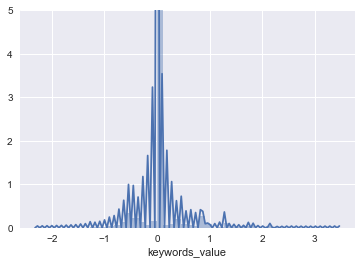

In [344]:
sns.distplot(train['keywords_value'] )
sns.plt.ylim(0,5)

## 7. Does the sentiment of the description (and name) affect the outcome?

Sentiment: How positive or negative the descriptions appear with vader a lexicon and rule-based sentiment analysis tool

In [220]:
#check for NaNs
train.isnull().sum().sum()


0

In [221]:
# Drop all rows with nulls
train.dropna(axis=0, inplace=True)
train=train.reset_index(drop=True)
train.isnull().sum().sum()

0

In [222]:
analyser = SentimentIntensityAnalyzer()

In [223]:
print ("no : ", analyser.polarity_scores("no")['compound'],"bad: ", analyser.polarity_scores("bad")['compound'],"worst: ", analyser.polarity_scores("worst")['compound'], "terrible disaster: ",analyser.polarity_scores("terrible disaster")['compound'])

no :  -0.296 bad:  -0.5423 worst:  -0.6249 terrible disaster:  -0.802


In [224]:
print ("keen : ", analyser.polarity_scores("keen")['compound'],"acceptable: ", analyser.polarity_scores("okay")['compound'],"good: ", analyser.polarity_scores("good")['compound'], "fantastic! :): ",analyser.polarity_scores("fantastic! :)")['compound'])

keen :  0.3612 acceptable:  0.2263 good:  0.4404 fantastic! :):  0.784


In [225]:
polarity_columns=['name', 'desc']
train2=train.copy(deep=True)
for i in polarity_columns:
    train2[i]=train2[i].apply(lambda y: analyser.polarity_scores(y.replace('-', ' '))['compound'])

train2.head()

project_id    name    desc    goal  \
0  kkst1451568084  0.0000  0.3612    20.0   
1  kkst1474482071  0.0000  0.0000   300.0   
2   kkst183622197  0.0000  0.5367    30.0   
3   kkst597742710  0.6124  0.7574   500.0   
4  kkst1913131122  0.4019  0.0000  2000.0   

                                            keywords  disable_communication  \
0                                drawing-for-dollars                  False   
1  sponsor-dereck-blackburn-lostwars-artist-in-re...                  False   
2                                       mr-squiggles                  False   
3                      help-me-write-my-second-novel                  False   
4             support-casting-my-sculpture-in-bronze                  False   

  country currency            deadline    state_changed_at  \
0      US      USD 2009-05-03 01:59:59 2009-05-03 02:00:17   
1      US      USD 2009-05-15 18:10:00 2009-05-15 19:00:18   
2      US      USD 2009-05-22 16:26:00 2009-05-22 16:30:18   
3      US      USD 2009-05-28 19:09:00 2009-05-28 19:15:21   
4      US      USD 2009-05-31 06:38:00 2009-05-31 06:45:17   

           created_at         launched_at  backers_count  final_status  \
0 2009-04-24 14:15:07 2009-04-24 14:52:03              3             1   
1 2009-04-28 18:10:24 2009-04-28 22:26:32              2             0   
2 2009-05-12 16:26:53 2009-05-12 16:39:58              0             0   
3 2009-04-28 19:09:55 2009-04-28 19:58:50             18             1   
4 2009-05-01 06:38:34 2009-05-01 07:22:21              1             0   

   currency_convert  keywords_value  create_to_launch  launch_to_deadline  \
0               1.0             0.0          0.025648            8.463843   
1               1.0             0.0          0.177870           16.821852   
2               1.0             0.0          0.009086            9.990301   
3               1.0             0.0          0.033970           29.965394   
4               1.0             0.0          0.030405           29.969201   

   deadline_to_statechange  
0                 0.000208  
1                 0.034931  
2                 0.002986  
3                 0.004410  
4                 0.005058

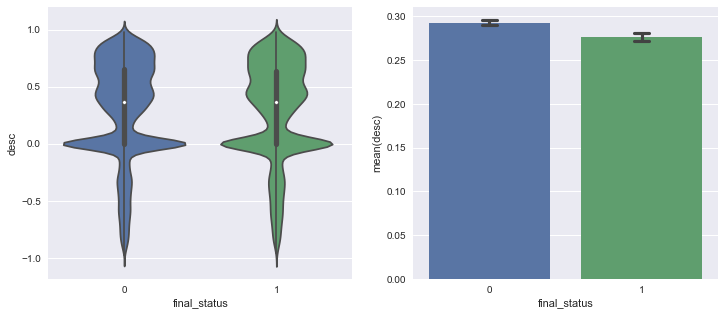

In [226]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
sns.violinplot ('final_status','desc',  data=train2, capsize=.1, ax=ax1)
sns.barplot ('final_status','desc',  data=train2, capsize=.1, ax=ax2)
# sns.plt.ylim(0.25,0.30)

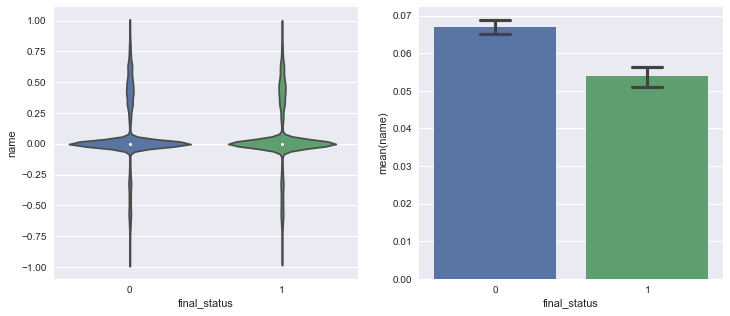

In [211]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
sns.violinplot ('final_status','name',  data=train2, capsize=.2, ax=ax1)
sns.barplot ('final_status','name',  data=train2, capsize=.2, ax=ax2)
# sns.plt.ylim(0.04,0.07)

In [227]:
from scipy import stats
Positive_desc=train2[train2.final_status==1]
Negative_desc=train2[train2.final_status==0]
t_stat, p_val=stats.ttest_ind(Positive_desc['desc'], Negative_desc['desc'])


t_stat2, p_val2=stats.ttest_ind(Positive_desc['name'], Negative_desc['name'])


print('p-values for the name is', p_val2, 'and for the description is', p_val)

p-values for the name is 1.75588227528e-14 and for the description is 1.3133399574e-08


In [294]:
Pos_list=train2['name'].sort_values()[-4:].index
Neg_list=train2['name'].sort_values()[:4].index

In [293]:
for i in reversed(Pos_list):
    print (train.loc[i,('name')], "score:", analyser.polarity_scores(train.loc[i,('name')])['compound'])

FREE ! FREE ART ! FREE ART!   HELP my Art get to the Gallery score: 0.9546
Sunny Adore for Peace Love Unity and Respect Merch score: 0.9531
Harmonic Tunes: Harmony, Love, Beauty, Peace and Music score: 0.9517
Thank you, I am truly grateful, you have enabled me to share my gift and inspire! score: 0.9476


In [285]:
for i in Neg_list:
    print (train.loc[i,('name')], "score:", analyser.polarity_scores(train.loc[i,('name')])['compound'])

We Kill The Dead! Z-E-R-T Zombie Killing 2014 Calendar score: -0.9402
POLLUTED ecological disaster meets human tragedy in China score: -0.9222
ALONE IN THE DEAD OF NIGHT -  a GHOSTLY HORROR feature film score: -0.9216
It's a Mad, Mad, Mad, Mad Book score: -0.9153


### Most projects have a greater number of descriptions with positive sentiment than negative - not surprising!
### The mean description and name are less positive for the population as a whole for successful kickstarter projects

## 8. Predicting kickstarter project success from features

Removing converted and non-helpful features...

In [281]:
train3=train2.copy(deep=True)
train2.drop(labels=['project_id','keywords', 'deadline', 'state_changed_at' , 'launched_at', 'created_at', 'currency', 'currency_convert'], axis=1, inplace=True)
train2=pd.get_dummies(columns=['country'], data=train2)
train2.disable_communication=train2.disable_communication.map({True:1, False:0})
train2.head(5)

name    desc    goal  disable_communication  backers_count  final_status  \
0  0.0000  0.3612    20.0                      0              3             1   
1  0.0000  0.0000   300.0                      0              2             0   
2  0.0000  0.5367    30.0                      0              0             0   
3  0.6124  0.7574   500.0                      0             18             1   
4  0.4019  0.0000  2000.0                      0              1             0   

   keywords_value  create_to_launch  launch_to_deadline  \
0             0.0          0.025648            8.463843   
1             0.0          0.177870           16.821852   
2             0.0          0.009086            9.990301   
3             0.0          0.033970           29.965394   
4             0.0          0.030405           29.969201   

   deadline_to_statechange     ...      country_CA  country_DE  country_DK  \
0                 0.000208     ...               0           0           0   
1                 0.034931     ...               0           0           0   
2                 0.002986     ...               0           0           0   
3                 0.004410     ...               0           0           0   
4                 0.005058     ...               0           0           0   

   country_GB  country_IE  country_NL  country_NO  country_NZ  country_SE  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   country_US  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 21 columns]

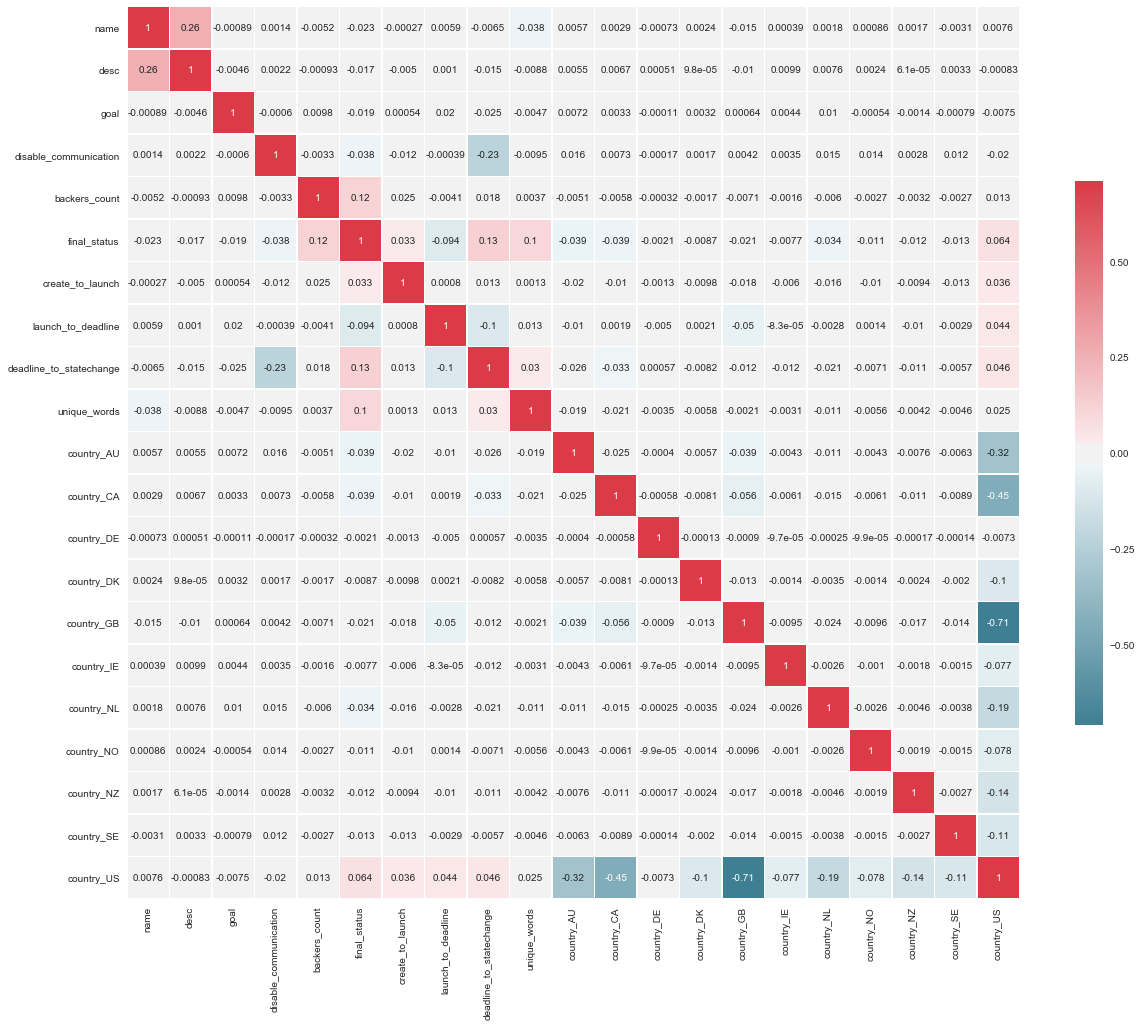

In [352]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(train2.corr(),  cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

** I removed Currency as it has strong correlation with Country (heatmap not shown). **



In [296]:
#Separating label from dataset
y=train2.final_status.copy() # Make a copy of labels
sub_train=train2.copy(deep=True)
sub_train.drop(labels=["final_status"], axis=1, inplace=True)

In [297]:
#Test train split

from sklearn.model_selection import train_test_split #Split data into test and train
data_train, data_test, Y_train, Y_test= train_test_split(sub_train, y, test_size=0.3, random_state=5)


#T=preprocessing.StandardScaler().fit_transform(data_train)
#T=preprocessing.MinMaxScaler().fit_transform(data_train)
#T=preprocessing.MaxAbsScaler().fit_transform(data_train)
# T=data_train
# T=preprocessing.Normalizer().fit_transform(data_train)
# Test_PCA = True
# model = None
# if Test_PCA:
#   print ("2D PCA")

#   from sklearn.decomposition import PCA
#   model=PCA(n_components=2).fit(T)
  
  

# else:
#   print (" 2D Isomap Manifold")

#   from sklearn.manifold import Isomap
#   model=Isomap(n_neighbors=5, n_components=2).fit(T)

# X_train=model.transform(data_train)
# X_test=model.transform(data_test)


In [298]:
X_train=data_train
X_test=data_test

In [299]:
# Random forest

random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=15, max_depth=16, max_features=7)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
score_random_forest_train=random_forest.score(X_train, Y_train)*100
score_random_forest_train

89.765340098303469

In [300]:
score_random_forest_test=random_forest.score(X_test, Y_test)*100
score_random_forest_test

87.982859080679475

In [124]:
#10-fold cross validation to check for overfitting 

from sklearn import cross_validation as cval

cval_score=cval.cross_val_score(random_forest, sub_train, y, cv=10)

In [127]:
mean_cval=cval_score.mean()*100
mean_cval

87.520508825597659

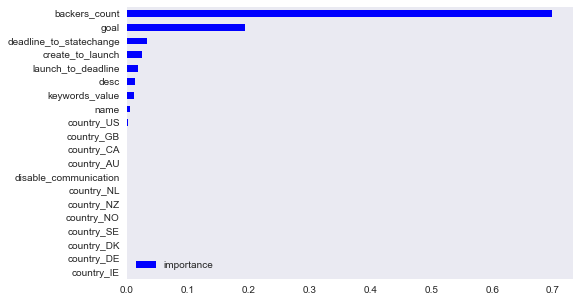

In [345]:
# predicting feature importance

names = train2.drop(['final_status'], axis=1).columns
ratios = random_forest.feature_importances_
ratios

feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
feature_important = feature_important.sort_values(by=['importance'], ascending=True)
feature_important.plot(kind='barh', stacked=True, color=['blue'], grid=False, figsize=(8, 5))



## Other models

In [302]:
# knn



knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
score_knn_train = round(knn.score(X_train, Y_train) * 100, 2)

print(score_knn_train)

88.2


In [303]:
score_knn_test = round(knn.score(X_test, Y_test) * 100, 2)
print(score_knn_test)

85.78


In [304]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
score_log_train = round(logreg.score(X_train, Y_train) * 100, 2)
print(score_log_train)



83.48


In [305]:
score_log_test= round(logreg.score(X_test, Y_test) * 100, 2)
print(score_log_test)

83.48


In [307]:
# Decision Tree

decision_tree = DecisionTreeClassifier(min_samples_leaf=10,  max_features=7)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
score_DT_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(score_DT_train)

90.02


In [308]:
score_DT_test = round(decision_tree.score(X_test, Y_test) * 100, 2)
print(score_DT_test)

85.47


In [309]:
Models=pd.DataFrame({
    'classifier':['Random Forest', 'KNeighbors', 'Decision Tree',  'Logistic Regression'],
    'Train scores':[score_random_forest_train, score_knn_train,score_DT_train,  score_log_train],
    'Test scores':[score_random_forest_test, score_knn_test,score_DT_test,  score_log_test]                
    
})

Models.sort_values(['Test scores'], ascending=[0])

Test scores  Train scores           classifier
0    87.982859      89.76534        Random Forest
1    85.780000      88.20000           KNeighbors
2    85.470000      90.02000        Decision Tree
3    83.480000      83.48000  Logistic Regression

## Conclusions:

    1. USA accounts for 85% of  all projects

    2. About 30% of the projects succeed.

    3. Successful projects have smaller financial goals.

    4. Invest in advertising! Successful projects also have 15x more median backers.

    5. Do not disable communication with backers, such projects always fail! 

    6. Set deadline to ~30 days after launch.

    7. Popular keywords are common between successful and failed projects.  However, projects with certain keywords  showed low chance of getting funded (e.g. app, web, food, movie failed for > 500 occurences).

    8.Sentiment analysis on the descriptions and names of projects shows a majority of projects reflect a positive sentiment. However, the mean sentiment of the population for successful projects is significantly (*p* <<< 0.0001) lower than failed projects.

    9.Backers count is the most important feature for predicting the success.